## Exploring Neural Networks using [Concrete Compressive Strength Set from UCI](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

#### Analysis follows Chapter 7 of *Machine Learning with R* by Brett Lantz (though of course here we use Python, not R)

Objective:  Use a neural network to predict the compressive strength of concrete.

We'll first use the MLPRegressor function provided by scikit-learn, then use Keras to create a customized neural net.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline

from scipy.stats import pearsonr

warnings.filterwarnings("ignore")
%matplotlib

Using matplotlib backend: MacOSX


In [2]:
data = pd.read_excel('Concrete_Data.xls')

In [3]:
data.columns = ['Cement','Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 
                'Fine Aggregate', 'Age', 'Compressive Strength']

In [4]:
data.head(5)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Compressive Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [5]:
data.shape

(1030, 9)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
Blast Furnace Slag,1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
Fly Ash,1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
Water,1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
Superplasticizer,1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
Coarse Aggregate,1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
Fine Aggregate,1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
Age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
Compressive Strength,1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225


In [10]:
y = data['Compressive Strength']
X = data.drop(labels = ['Compressive Strength'], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)

Ok, let's start by following the exercise in Lantz:
- scale the data to be in [0, 1]
- train the neural net with only 1 node (otherwise we'll use the default parameters)
- check the correlation between the predictions and the test data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)
MMS = MinMaxScaler()
MMS.fit(X_train)
X_train = MMS.transform(X_train)
X_test = MMS.transform(X_test)

In [10]:

NN = MLPRegressor(hidden_layer_sizes=(1,))
NN.fit(X_train, y_train)
predictions = NN.predict(X_test)

In [11]:
NN.n_outputs_ 

1

In [12]:
print('correlation =', pearsonr(predictions, y_test)[0])

correlation = 2.45398506533e-16


In [13]:
print('R2 score =',NN.score(X_test, y_test))

R2 score = -4.13263378834


Well, this net doesn't do a very good job.  Let's create a pipeline and try varying the parameters to find one that works:
- different scalers
- different # of nodes/layers
- different activation functions
- different algorithms
- different weights (alpha) for the l2 correction term

We'll use R2 score as the accuracy measure.  Correlation will be used as a sanity check.

In [14]:
#scaler to be used in the grid search
scaler_list = [
    ('mm', MinMaxScaler(), {})
    ,('std', StandardScaler(), {})

]
#parameters for the MLP regressor to be used in the grid search
classifier_list = [
    ('mlp', MLPRegressor(), {'mlp__hidden_layer_sizes': ((10,),(10, 10),(10, 10, 10), (30,),(30, 30),(30, 30, 30),
                                                        (50,),(50, 50),(50, 50, 50),(100,),(100, 100),(100, 100, 100)),        
    'mlp__activation':('logistic','relu','identity','tanh'),
    #'mlp__activation':('logistic',),
     'mlp__solver':('lbfgs','sgd','adam'),
     #'mlp__solver':('lbfgs',),
    'mlp__alpha':(1.0e-4,1.0e-3,1.0e-2,1.0e-1,1.0, 1.0e+1, 1.0e+2)})
]
results = {}

#loop over all scalers (2) and classifiers (only 1 here)
for s in scaler_list:
    for c in classifier_list:
        
        pipeline = Pipeline([ (s[0], s[1]), (c[0], c[1]) ])

        parameters = {}
        parameters.update(s[2])
        parameters.update(c[2])
        
        #do a grid search on the current scaler and classifier
        grid_search = GridSearchCV(pipeline, parameters, scoring='r2', verbose=1, n_jobs=4)

        results[(s[0], c[0])] = grid_search.fit(X_train,y_train)


Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=4)]: Done 115 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 267 tasks      | elapsed:   37.6s
[Parallel(n_jobs=4)]: Done 517 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 867 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1317 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 1972 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 2718 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 3024 out of 3024 | elapsed:  6.3min finished


Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 228 tasks      | elapsed:   40.7s
[Parallel(n_jobs=4)]: Done 478 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 828 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 1278 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 2027 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 2691 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 3024 out of 3024 | elapsed:  7.2min finished


In [15]:
print('Best R2 for MinMax scaling: ', results[('mm', 'mlp')].best_score_)

Best R2 for MinMax scaling:  0.867574944301


In [16]:
print('Best R2 for Z-scaling: ',results[('std', 'mlp')].best_score_)

Best R2 for Z-scaling:  0.88321339547


Much better.  Let's see which parameters give the best test scores.  First, MinMax scaling:

In [17]:
rdf = pd.DataFrame(results[('mm', 'mlp')].cv_results_)
rdf.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
891,0.450609,0.001303,0.867575,0.939786,tanh,0.1,"(100,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",1,0.850824,0.947467,0.871374,0.917285,0.880596,0.954605,0.012041,0.000094,0.012451,0.016175
156,0.364964,0.000899,0.865029,0.921015,logistic,1,"(30, 30)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",2,0.838239,0.932051,0.878623,0.918991,0.878337,0.912003,0.013088,0.000007,0.018983,0.008309
918,0.309197,0.000922,0.864191,0.931705,tanh,1,"(50,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",3,0.826752,0.921247,0.884791,0.930050,0.881187,0.943817,0.043277,0.000009,0.026569,0.009288
774,0.283045,0.000921,0.861704,0.931986,tanh,0.0001,"(50,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",4,0.841407,0.948905,0.874509,0.908709,0.869281,0.938345,0.009865,0.000007,0.014539,0.017015
162,0.311746,0.000850,0.861549,0.913276,logistic,1,"(50,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",5,0.830536,0.914009,0.889772,0.915572,0.864468,0.910246,0.027704,0.000011,0.024279,0.002236
927,0.534502,0.001238,0.860856,0.946363,tanh,1,"(100,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",6,0.832491,0.945632,0.884705,0.947393,0.865489,0.946064,0.116746,0.000092,0.021573,0.000749
882,0.335539,0.000932,0.860432,0.944932,tanh,0.1,"(50,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",7,0.834305,0.942118,0.879844,0.950662,0.867255,0.942017,0.021517,0.000006,0.019212,0.004052
345,0.491210,0.000953,0.856993,0.902386,relu,0.01,"(50, 50)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",8,0.848044,0.902672,0.872158,0.897874,0.850815,0.906612,0.000933,0.000051,0.010772,0.003573
153,0.172371,0.000690,0.856368,0.911016,logistic,1,"(30,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",9,0.838526,0.919521,0.878853,0.908534,0.851800,0.904992,0.008044,0.000003,0.016782,0.006186
456,1.089095,0.001097,0.856169,0.919557,relu,10,"(50, 50, 50)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",10,0.830316,0.924723,0.887243,0.916828,0.851056,0.917120,0.067357,0.000111,0.023527,0.003655


In [18]:
rdf = pd.DataFrame(results[('std', 'mlp')].cv_results_)
rdf.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
945,0.205664,0.000747,0.883213,0.954375,tanh,10,"(30,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",1,0.863491,0.958057,0.896081,0.949207,0.890151,0.955861,0.007317,0.000002,0.014183,0.003763
954,0.315621,0.000923,0.882161,0.963578,tanh,10,"(50,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",2,0.854947,0.966162,0.901655,0.961874,0.889994,0.962697,0.013440,0.000011,0.019861,0.001858
483,0.536236,0.001108,0.882097,0.956138,relu,100,"(30, 30, 30)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",3,0.854845,0.957632,0.909245,0.958502,0.882316,0.952279,0.051510,0.000171,0.022217,0.002752
501,2.589816,0.002403,0.879980,0.973664,relu,100,"(100, 100, 100)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",4,0.845775,0.976483,0.896424,0.971295,0.897882,0.973214,0.211383,0.000350,0.024244,0.002142
498,1.915467,0.003564,0.877807,0.948502,relu,100,"(100, 100)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",5,0.852084,0.952452,0.897002,0.947859,0.884442,0.945194,0.281261,0.003018,0.018933,0.002997
963,0.442590,0.001161,0.877490,0.967674,tanh,10,"(100,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",6,0.851494,0.970619,0.893406,0.965536,0.887679,0.966868,0.005435,0.000038,0.018568,0.002152
492,1.397099,0.001324,0.876837,0.964710,relu,100,"(50, 50, 50)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",7,0.857907,0.968555,0.886467,0.964018,0.886215,0.961556,0.032101,0.000019,0.013413,0.002899
309,0.521246,0.001041,0.876177,0.979235,relu,0.001,"(50, 50)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",8,0.825713,0.981850,0.896799,0.978514,0.906229,0.977342,0.016994,0.000014,0.035964,0.001910
384,1.382679,0.001564,0.875265,0.984060,relu,0.1,"(50, 50, 50)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",9,0.827774,0.982109,0.909462,0.981592,0.888756,0.988480,0.111178,0.000389,0.034695,0.003132
927,0.478181,0.001426,0.873446,0.990754,tanh,1,"(100,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",10,0.850681,0.989319,0.899985,0.989441,0.869767,0.993501,0.010521,0.000300,0.020302,0.001943


The highest scores are for Z-scaled data, the lbfgs algorithm, and the relu function with higher alpha.  Higher alphas seem to require more hidden layers, while lower alphas require fewer.  At the risk of overfitting, let's try to come up with even better values, using alphas between 1 and 100, and varying the number of nodes, keeping only one or 2 hidden layers.

In [21]:
scaler_list = [
    ('std', StandardScaler(), {})
]
classifier_list = [
    ('mlp', MLPRegressor(), {'mlp__hidden_layer_sizes': ((30,),(30, 30), (40,),(40, 40), (50,),(50, 50),
                                                        (60,),(60, 60),(70,),(70, 70),(80,), (80, 80),
                                                        (90,),(90, 90),(100,),(100, 100)),        
    'mlp__activation':('relu',),
    'mlp__solver':('lbfgs',),
    'mlp__alpha':(1, 5, 10, 20, 50, 100)})
]
results = {}

for s in scaler_list:
    for c in classifier_list:
        
        pipeline = Pipeline([ (s[0], s[1]), (c[0], c[1]) ])

        parameters = {}
        parameters.update(s[2])
        parameters.update(c[2])

        grid_search = GridSearchCV(pipeline, parameters, scoring='r2', verbose=1, n_jobs=4)

        results[(s[0], c[0])] = grid_search.fit(X_train,y_train)
    

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 210 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done 288 out of 288 | elapsed:   51.2s finished


In [20]:
rdf = pd.DataFrame(results[('std', 'mlp')].cv_results_)
rdf.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
57,1.140801,0.001169,0.889375,0.973534,relu,20,"(70, 70)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",1,0.876955,0.976937,0.896904,0.971707,0.894318,0.971959,0.010880,0.000101,0.008864,0.002408
59,1.229386,0.001206,0.884732,0.975883,relu,20,"(80, 80)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",2,0.854655,0.976362,0.901716,0.973599,0.897949,0.977687,0.036764,0.000104,0.021367,0.001703
61,1.509322,0.001436,0.880366,0.976886,relu,20,"(90, 90)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",3,0.850386,0.979228,0.898103,0.973753,0.892732,0.977677,0.027435,0.000042,0.021355,0.002304
13,1.383741,0.001569,0.880322,0.984173,relu,1,"(90, 90)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",4,0.845040,0.983871,0.892177,0.981847,0.903896,0.986800,0.033094,0.000199,0.025453,0.002033
77,1.358496,0.001426,0.879551,0.968527,relu,50,"(90, 90)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",5,0.847790,0.972043,0.902017,0.967393,0.888980,0.966146,0.050238,0.000013,0.023126,0.002538
79,1.693139,0.001585,0.878988,0.967906,relu,50,"(100, 100)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",6,0.844140,0.971995,0.904503,0.964432,0.888467,0.967292,0.073923,0.000167,0.025545,0.003118
45,1.459078,0.004091,0.877070,0.980365,relu,10,"(90, 90)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",7,0.852248,0.980741,0.888522,0.976175,0.890543,0.984178,0.032066,0.003614,0.017608,0.003278
75,1.234082,0.001308,0.875767,0.964333,relu,50,"(80, 80)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",8,0.854729,0.970105,0.898381,0.961228,0.874279,0.961666,0.030047,0.000007,0.017858,0.004085
63,1.651803,0.001549,0.875658,0.976866,relu,20,"(100, 100)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",9,0.830326,0.977618,0.902042,0.976551,0.894795,0.976429,0.028968,0.000155,0.032257,0.000534
49,0.369518,0.001840,0.875640,0.963136,relu,20,"(30, 30)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__hidden_layer_si...",10,0.856478,0.968323,0.898815,0.961040,0.871707,0.960046,0.014081,0.001365,0.017512,0.003690


The best values are alpha=20 and two hidden layers of 70 nodes each.  Let's see how this looks on the test data:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)
ZS = StandardScaler()
ZS.fit(X_train)
X_train = ZS.transform(X_train)
X_test = ZS.transform(X_test)
NN = MLPRegressor(hidden_layer_sizes=(70, 70), solver='lbfgs', alpha=20, activation='relu')
#NN = MLPRegressor(hidden_layer_sizes=(30,30), solver='lbfgs', alpha=10, activation='relu')
NN.fit(X_train, y_train)
predictions = NN.predict(X_test)
print('correlation =', pearsonr(predictions, y_test)[0])
print('R2 score =',NN.score(X_test, y_test))

correlation = 0.957741915884
R2 score = 0.916875644796


This is quite nice.  And visually, the points lie fairly close to the 45 degree line:

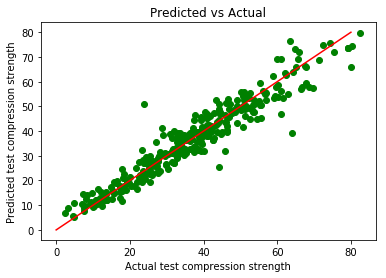

In [23]:
%matplotlib inline 
plt.scatter(y_test, predictions, marker='o', color='g')
plt.plot((0,80),(0,80), color='r')
plt.xlabel('Actual test compression strength')
plt.ylabel('Predicted test compression strength')
plt.title('Predicted vs Actual')
plt.show()

Next, let's try creating a neural net in Keras:

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K

Using TensorFlow backend.


In [11]:
#standard scaler had the best performance above, so let's just stick with that

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)
SS = StandardScaler()
SS.fit(X_train)
X_train = SS.transform(X_train)
X_test = SS.transform(X_test)

In [14]:
#customized metric - doesn't already exist ?!?
def r_squared(y_true, y_pred):
    ''' Customized loss function for R^2 
    y_true = Keras tensor of actual values
    y_pred = Keras tensor of predicted values
    
    '''
    mu = K.mean(y_true)
    tss = K.sum(K.square(y_true - mu)) #total sum of squares
    rss = K.sum(K.square(y_true - y_pred)) #residual sum of squares

    return (1 - rss/(K.epsilon() + tss))

#each hidden layer can be a different size
def nn_model(layers, activation, optimizer, input_shape, alpha=1):
    '''Neural net model of only dense layers

    layers: List of integers, the number of hidden units in each layer
    activation:  String, name of activation function used for each layer ('relu', etc.)
    optimizer:  String, name of optimization algorithm ('sgd', etc.)
    input_shape:  Sequence of integers, dimensions of the input layer
    '''

    model = Sequential()
   
    first_layer = True

    for layer in layers:
        #if 1st layer, need to specify input shape
        if first_layer:
            model.add(Dense(layer, input_shape = input_shape, kernel_regularizer=regularizers.l2(alpha)) )
            first_layer = False
        else:
            model.add(Dense(layer, kernel_regularizer=regularizers.l2(alpha)))

        model.add(Activation(activation))

    model.add(Dense(1))
    model.add(Activation('linear'))
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=[r_squared])

    return model

#each hidden layer is the same size
def nn_model_same_size(layer_size, no_layers, activation, optimizer, input_shape, alpha=1):
    '''Neural net model of only dense layers

    layer_size: Integer, the number of hidden units in each layer
    no_layers: Integer, the number of hidden layers
    activation:  String, name of activation function used for each layer ('relu', etc.)
    optimizer:  String, name of optimization algorithm ('sgd', etc.)
    input_shape:  Sequence of integers, dimensions of the input layer
    '''

    model = Sequential()

    for layer in range(no_layers):
        #if 1st layer, need to specify input shape
        if layer:
            model.add(Dense(layer_size, kernel_regularizer=regularizers.l2(alpha)))
        else:
            model.add(Dense(layer_size, input_shape = input_shape, kernel_regularizer=regularizers.l2(alpha)) )
            
        model.add(Activation(activation))

    model.add(Dense(1))
    model.add(Activation('linear'))
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=[r_squared])

    return model

Let's do a sanity check using the optimal parameters found above:

In [15]:
myModel = nn_model_same_size(30, 1, 'tanh', 'sgd', (X_train.shape[1],), alpha=0)
myModel.fit(X_train, y_train, epochs=200, batch_size=32)
myModel.evaluate(X_test, y_test)

Epoch 1/200
721/721 [==============================] - 0s 373us/step - loss: 400.2504 - r_squared: -0.5885
Epoch 2/200
721/721 [==============================] - 0s 41us/step - loss: 88.5589 - r_squared: 0.6610
Epoch 3/200
721/721 [==============================] - 0s 41us/step - loss: 74.3385 - r_squared: 0.7071
Epoch 4/200
721/721 [==============================] - 0s 43us/step - loss: 64.7665 - r_squared: 0.7374
Epoch 5/200
721/721 [==============================] - 0s 41us/step - loss: 58.7572 - r_squared: 0.7739
Epoch 6/200
721/721 [==============================] - 0s 42us/step - loss: 54.9382 - r_squared: 0.7862
Epoch 7/200
721/721 [==============================] - 0s 40us/step - loss: 51.8376 - r_squared: 0.7831
Epoch 8/200
721/721 [==============================] - 0s 41us/step - loss: 46.0673 - r_squared: 0.8172
Epoch 9/200
721/721 [==============================] - 0s 41us/step - loss: 45.0659 - r_squared: 0.8117
Epoch 10/200
721/721 [==============================] - 0s 43

721/721 [==============================] - 0s 42us/step - loss: 19.0754 - r_squared: 0.9234
Epoch 79/200
721/721 [==============================] - 0s 44us/step - loss: 18.6587 - r_squared: 0.9262
Epoch 80/200
721/721 [==============================] - 0s 46us/step - loss: 19.5696 - r_squared: 0.9216
Epoch 81/200
721/721 [==============================] - 0s 49us/step - loss: 19.5468 - r_squared: 0.9219
Epoch 82/200
721/721 [==============================] - 0s 47us/step - loss: 19.9496 - r_squared: 0.9199
Epoch 83/200
721/721 [==============================] - 0s 47us/step - loss: 18.3937 - r_squared: 0.9269
Epoch 84/200
721/721 [==============================] - 0s 47us/step - loss: 18.7669 - r_squared: 0.9270
Epoch 85/200
721/721 [==============================] - 0s 56us/step - loss: 19.0849 - r_squared: 0.9246
Epoch 86/200
721/721 [==============================] - 0s 48us/step - loss: 18.6014 - r_squared: 0.9240
Epoch 87/200
721/721 [==============================] - 0s 48us/step

721/721 [==============================] - 0s 42us/step - loss: 16.0651 - r_squared: 0.9347
Epoch 156/200
721/721 [==============================] - 0s 43us/step - loss: 15.8396 - r_squared: 0.9321
Epoch 157/200
721/721 [==============================] - 0s 43us/step - loss: 15.7394 - r_squared: 0.9320
Epoch 158/200
721/721 [==============================] - 0s 43us/step - loss: 15.0374 - r_squared: 0.9362
Epoch 159/200
721/721 [==============================] - 0s 43us/step - loss: 15.6898 - r_squared: 0.9373
Epoch 160/200
721/721 [==============================] - 0s 43us/step - loss: 14.9782 - r_squared: 0.9409
Epoch 161/200
721/721 [==============================] - 0s 43us/step - loss: 14.8194 - r_squared: 0.9423
Epoch 162/200
721/721 [==============================] - 0s 44us/step - loss: 15.1074 - r_squared: 0.9368
Epoch 163/200
721/721 [==============================] - 0s 44us/step - loss: 15.0470 - r_squared: 0.9373
Epoch 164/200
721/721 [==============================] - 0s 

[28.482716927636403, 0.89844691830545564]

Ok, that's pretty close to the above result.  Let's set up a grid search.  First test using the same parameters as above:

In [16]:
#Based on this post on using GridSearchCV with keras:
#    https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
keras_model = KerasRegressor(build_fn=nn_model_same_size, input_shape=(X_train.shape[1],), alpha=0)
layer_list = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
layer_depth = (1, 2)

grid_search = GridSearchCV(keras_model
                         ,param_grid={'layer_size': (30,)
                                      ,'no_layers': (1,)
                                     ,'activation': ('tanh',)
                                     ,'optimizer': ('sgd',)
                                     } 
                        ,scoring='r2'
                        
                        )
result = grid_search.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
480/480 [==============================] - 0s 434us/step - loss: 560.4482 - r_squared: -0.9501
Epoch 2/200
480/480 [==============================] - 0s 41us/step - loss: 105.2651 - r_squared: 0.6323
Epoch 3/200
480/480 [==============================] - 0s 41us/step - loss: 86.0824 - r_squared: 0.7031
Epoch 4/200
480/480 [==============================] - 0s 41us/step - loss: 80.8537 - r_squared: 0.7179
Epoch 5/200
480/480 [==============================] - 0s 40us/step - loss: 67.3860 - r_squared: 0.7660
Epoch 6/200
480/480 [==============================] - 0s 40us/step - loss: 55.8281 - r_squared: 0.8113
Epoch 7/200
480/480 [==============================] - 0s 40us/step - loss: 51.3208 - r_squared: 0.8196
Epoch 8/200
480/480 [==============================] - 0s 42us/step - loss: 46.6469 - r_squared: 0.8391
Epoch 9/200
480/480 [==============================] - 0s 43us/step - loss: 50.4451 - r_squared: 0.8075
Epoch 10/200
480/480 [==============================] - 0s 4

480/480 [==============================] - 0s 44us/step - loss: 19.4134 - r_squared: 0.9311
Epoch 80/200
480/480 [==============================] - 0s 41us/step - loss: 19.6045 - r_squared: 0.9326
Epoch 81/200
480/480 [==============================] - 0s 40us/step - loss: 18.8719 - r_squared: 0.9302
Epoch 82/200
480/480 [==============================] - 0s 46us/step - loss: 19.4982 - r_squared: 0.9291
Epoch 83/200
480/480 [==============================] - 0s 43us/step - loss: 18.8440 - r_squared: 0.9304
Epoch 84/200
480/480 [==============================] - 0s 43us/step - loss: 19.1987 - r_squared: 0.9308
Epoch 85/200
480/480 [==============================] - ETA: 0s - loss: 9.4764 - r_squared: 0.943 - 0s 45us/step - loss: 19.6527 - r_squared: 0.9315
Epoch 86/200
480/480 [==============================] - 0s 45us/step - loss: 18.4645 - r_squared: 0.9354
Epoch 87/200
480/480 [==============================] - 0s 44us/step - loss: 18.6512 - r_squared: 0.9281
Epoch 88/200
480/480 [==

480/480 [==============================] - 0s 43us/step - loss: 14.7078 - r_squared: 0.9466
Epoch 156/200
480/480 [==============================] - 0s 41us/step - loss: 14.7331 - r_squared: 0.9487
Epoch 157/200
480/480 [==============================] - 0s 43us/step - loss: 14.0756 - r_squared: 0.9504
Epoch 158/200
480/480 [==============================] - 0s 41us/step - loss: 14.8220 - r_squared: 0.9477
Epoch 159/200
480/480 [==============================] - 0s 43us/step - loss: 15.0245 - r_squared: 0.9450
Epoch 160/200
480/480 [==============================] - 0s 45us/step - loss: 15.4829 - r_squared: 0.9411
Epoch 161/200
480/480 [==============================] - 0s 43us/step - loss: 13.9739 - r_squared: 0.9506
Epoch 162/200
480/480 [==============================] - 0s 43us/step - loss: 14.5405 - r_squared: 0.9469
Epoch 163/200
480/480 [==============================] - 0s 42us/step - loss: 14.4618 - r_squared: 0.9469
Epoch 164/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 50us/step - loss: 41.5111 - r_squared: -4196803.5777
Epoch 30/200
481/481 [==============================] - 0s 51us/step - loss: 79.9111 - r_squared: -130836.7065
Epoch 31/200
481/481 [==============================] - 0s 53us/step - loss: 46.6248 - r_squared: -698974.2710
Epoch 32/200
481/481 [==============================] - 0s 48us/step - loss: 49.6633 - r_squared: -987064.0840
Epoch 33/200
481/481 [==============================] - 0s 47us/step - loss: 46.0015 - r_squared: -808.8025
Epoch 34/200
481/481 [==============================] - 0s 57us/step - loss: 37.5940 - r_squared: -13436.2706
Epoch 35/200
481/481 [==============================] - 0s 53us/step - loss: 34.8278 - r_squared: -231404.8995
Epoch 36/200
481/481 [==============================] - 0s 51us/step - loss: 35.5855 - r_squared: -430114.3423
Epoch 37/200
481/481 [==============================] - 0s 55us/step - loss: 35.3494 - r_squared: -149984.8808
Epoch 38/200
481/

Epoch 103/200
481/481 [==============================] - 0s 45us/step - loss: 17.8958 - r_squared: -59238.0503
Epoch 104/200
481/481 [==============================] - 0s 44us/step - loss: 17.4145 - r_squared: -17696.0352
Epoch 105/200
481/481 [==============================] - 0s 45us/step - loss: 15.5847 - r_squared: -40005.0027
Epoch 106/200
481/481 [==============================] - 0s 44us/step - loss: 15.9802 - r_squared: -195.0218
Epoch 107/200
481/481 [==============================] - 0s 47us/step - loss: 15.1859 - r_squared: -184416.6832
Epoch 108/200
481/481 [==============================] - 0s 45us/step - loss: 15.8659 - r_squared: -784104.5183
Epoch 109/200
481/481 [==============================] - 0s 44us/step - loss: 22.6851 - r_squared: -64169.7087
Epoch 110/200
481/481 [==============================] - 0s 46us/step - loss: 17.3241 - r_squared: -310775.6549
Epoch 111/200
481/481 [==============================] - 0s 47us/step - loss: 17.5785 - r_squared: -327558.8272

481/481 [==============================] - 0s 49us/step - loss: 18.3816 - r_squared: -196222.7622
Epoch 177/200
481/481 [==============================] - 0s 48us/step - loss: 17.7472 - r_squared: -57571.0541
Epoch 178/200
481/481 [==============================] - 0s 45us/step - loss: 16.3978 - r_squared: -220015.2900
Epoch 179/200
481/481 [==============================] - 0s 48us/step - loss: 16.3042 - r_squared: -48711.9350
Epoch 180/200
481/481 [==============================] - 0s 47us/step - loss: 16.7487 - r_squared: -611809.2672
Epoch 181/200
481/481 [==============================] - 0s 53us/step - loss: 18.4597 - r_squared: -1396415.8793
Epoch 182/200
481/481 [==============================] - 0s 49us/step - loss: 22.7521 - r_squared: -3555.2939
Epoch 183/200
481/481 [==============================] - 0s 49us/step - loss: 17.3953 - r_squared: -1047935.7432
Epoch 184/200
481/481 [==============================] - 0s 46us/step - loss: 28.7476 - r_squared: -483932.0028
Epoch 18

Epoch 50/200
481/481 [==============================] - 0s 47us/step - loss: 24.6292 - r_squared: -502379.7452
Epoch 51/200
481/481 [==============================] - 0s 47us/step - loss: 26.3185 - r_squared: -126544.5835
Epoch 52/200
481/481 [==============================] - 0s 46us/step - loss: 24.4781 - r_squared: -2452334.6073
Epoch 53/200
481/481 [==============================] - 0s 47us/step - loss: 66.3066 - r_squared: -3414762.2656
Epoch 54/200
481/481 [==============================] - 0s 47us/step - loss: 43.2227 - r_squared: -111092.1700
Epoch 55/200
481/481 [==============================] - 0s 45us/step - loss: 33.5081 - r_squared: -92976.4975
Epoch 56/200
481/481 [==============================] - 0s 46us/step - loss: 30.5920 - r_squared: -34471.5560
Epoch 57/200
481/481 [==============================] - 0s 42us/step - loss: 28.1721 - r_squared: -114861.8072
Epoch 58/200
481/481 [==============================] - 0s 45us/step - loss: 27.6621 - r_squared: -338561.9470
E

481/481 [==============================] - 0s 44us/step - loss: 17.9542 - r_squared: -187516.3347
Epoch 124/200
481/481 [==============================] - 0s 43us/step - loss: 18.4262 - r_squared: -44785.9137
Epoch 125/200
481/481 [==============================] - 0s 44us/step - loss: 17.1342 - r_squared: -400326.9212
Epoch 126/200
481/481 [==============================] - 0s 44us/step - loss: 22.5128 - r_squared: -17085.7846
Epoch 127/200
481/481 [==============================] - 0s 48us/step - loss: 18.1164 - r_squared: -70089.7158
Epoch 128/200
481/481 [==============================] - 0s 44us/step - loss: 17.6688 - r_squared: -258352.3389
Epoch 129/200
481/481 [==============================] - 0s 46us/step - loss: 18.2004 - r_squared: -3039252.3643
Epoch 130/200
481/481 [==============================] - 0s 48us/step - loss: 42.7418 - r_squared: -1126788.9072
Epoch 131/200
481/481 [==============================] - 0s 52us/step - loss: 22.4869 - r_squared: -208416.7046
Epoch 1

481/481 [==============================] - 0s 52us/step - loss: 16.1439 - r_squared: -478.7770
Epoch 197/200
481/481 [==============================] - 0s 46us/step - loss: 15.1232 - r_squared: -723798.2824
Epoch 198/200
481/481 [==============================] - 0s 45us/step - loss: 15.9955 - r_squared: -103726.6286
Epoch 199/200
481/481 [==============================] - 0s 48us/step - loss: 15.3132 - r_squared: -70568.5886
Epoch 200/200
481/481 [==============================] - 0s 51us/step - loss: 15.5705 - r_squared: -590224.2291
Epoch 1/200
721/721 [==============================] - 0s 378us/step - loss: 392.6269 - r_squared: -0.6447
Epoch 2/200
721/721 [==============================] - 0s 43us/step - loss: 83.7958 - r_squared: 0.6841
Epoch 3/200
721/721 [==============================] - 0s 44us/step - loss: 66.1951 - r_squared: 0.7484
Epoch 4/200
721/721 [==============================] - 0s 43us/step - loss: 57.4276 - r_squared: 0.7759
Epoch 5/200
721/721 [==================

721/721 [==============================] - 0s 42us/step - loss: 19.1102 - r_squared: 0.9247
Epoch 74/200
721/721 [==============================] - 0s 42us/step - loss: 19.4549 - r_squared: 0.9223
Epoch 75/200
721/721 [==============================] - 0s 44us/step - loss: 18.9604 - r_squared: 0.9265
Epoch 76/200
721/721 [==============================] - 0s 44us/step - loss: 19.6674 - r_squared: 0.9206
Epoch 77/200
721/721 [==============================] - 0s 42us/step - loss: 18.7500 - r_squared: 0.9237
Epoch 78/200
721/721 [==============================] - 0s 42us/step - loss: 19.6383 - r_squared: 0.9212
Epoch 79/200
721/721 [==============================] - 0s 43us/step - loss: 18.6731 - r_squared: 0.9249
Epoch 80/200
721/721 [==============================] - 0s 42us/step - loss: 19.2644 - r_squared: 0.9214
Epoch 81/200
721/721 [==============================] - 0s 45us/step - loss: 18.4059 - r_squared: 0.9257
Epoch 82/200
721/721 [==============================] - 0s 43us/step

721/721 [==============================] - 0s 42us/step - loss: 16.0764 - r_squared: 0.9342
Epoch 151/200
721/721 [==============================] - 0s 42us/step - loss: 16.2860 - r_squared: 0.9347
Epoch 152/200
721/721 [==============================] - 0s 40us/step - loss: 15.3369 - r_squared: 0.9389
Epoch 153/200
721/721 [==============================] - 0s 41us/step - loss: 15.8619 - r_squared: 0.9395
Epoch 154/200
721/721 [==============================] - 0s 40us/step - loss: 15.3114 - r_squared: 0.9390
Epoch 155/200
721/721 [==============================] - 0s 43us/step - loss: 15.2584 - r_squared: 0.9376
Epoch 156/200
721/721 [==============================] - 0s 45us/step - loss: 15.3390 - r_squared: 0.9382
Epoch 157/200
721/721 [==============================] - 0s 47us/step - loss: 15.4716 - r_squared: 0.9381
Epoch 158/200
721/721 [==============================] - 0s 46us/step - loss: 15.7533 - r_squared: 0.9356
Epoch 159/200
721/721 [==============================] - 0s 

R squared is around 0.94, looks good.  Now, let's vary the parameters:

In [17]:
#Based on this post on using GridSearchCV with keras:
#    https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
keras_model = KerasRegressor(build_fn=nn_model_same_size, input_shape=(X_train.shape[1],), alpha=0)
layer_list = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
layer_depth = (1, 2)

grid_search = GridSearchCV(keras_model
                         ,param_grid={'layer_size': layer_list
                                      ,'no_layers': layer_depth
                                     ,'activation': ('tanh',)
                                     ,'optimizer': ('sgd',)
                                     } 
                        ,scoring='r2'
                        
                        )
result = grid_search.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
480/480 [==============================] - 0s 547us/step - loss: 734.5873 - r_squared: -1.6427
Epoch 2/200
480/480 [==============================] - 0s 40us/step - loss: 151.4878 - r_squared: 0.4855
Epoch 3/200
480/480 [==============================] - 0s 42us/step - loss: 108.5754 - r_squared: 0.6270
Epoch 4/200
480/480 [==============================] - 0s 39us/step - loss: 87.8605 - r_squared: 0.6953
Epoch 5/200
480/480 [==============================] - 0s 41us/step - loss: 83.1209 - r_squared: 0.7074
Epoch 6/200
480/480 [==============================] - 0s 46us/step - loss: 75.4939 - r_squared: 0.7113
Epoch 7/200
480/480 [==============================] - 0s 40us/step - loss: 62.5031 - r_squared: 0.7838
Epoch 8/200
480/480 [==============================] - 0s 41us/step - loss: 59.6266 - r_squared: 0.7858
Epoch 9/200
480/480 [==============================] - 0s 42us/step - loss: 51.1624 - r_squared: 0.8225
Epoch 10/200
480/480 [==============================] - 0s 

480/480 [==============================] - 0s 41us/step - loss: 30.8535 - r_squared: 0.8909
Epoch 80/200
480/480 [==============================] - 0s 42us/step - loss: 30.7626 - r_squared: 0.8935
Epoch 81/200
480/480 [==============================] - 0s 41us/step - loss: 31.2689 - r_squared: 0.8851
Epoch 82/200
480/480 [==============================] - 0s 45us/step - loss: 30.0442 - r_squared: 0.8925
Epoch 83/200
480/480 [==============================] - 0s 42us/step - loss: 29.9769 - r_squared: 0.8920
Epoch 84/200
480/480 [==============================] - 0s 41us/step - loss: 31.5504 - r_squared: 0.8866
Epoch 85/200
480/480 [==============================] - 0s 41us/step - loss: 30.6029 - r_squared: 0.8927
Epoch 86/200
480/480 [==============================] - 0s 40us/step - loss: 30.5875 - r_squared: 0.8917
Epoch 87/200
480/480 [==============================] - 0s 40us/step - loss: 28.2828 - r_squared: 0.8942
Epoch 88/200
480/480 [==============================] - 0s 41us/step

480/480 [==============================] - 0s 40us/step - loss: 29.7209 - r_squared: 0.8958
Epoch 157/200
480/480 [==============================] - 0s 41us/step - loss: 30.8292 - r_squared: 0.8921
Epoch 158/200
480/480 [==============================] - 0s 40us/step - loss: 29.3935 - r_squared: 0.8957
Epoch 159/200
480/480 [==============================] - 0s 41us/step - loss: 29.3612 - r_squared: 0.8944
Epoch 160/200
480/480 [==============================] - 0s 40us/step - loss: 31.7886 - r_squared: 0.8832
Epoch 161/200
480/480 [==============================] - 0s 43us/step - loss: 28.9966 - r_squared: 0.8919
Epoch 162/200
480/480 [==============================] - 0s 41us/step - loss: 28.4919 - r_squared: 0.8958
Epoch 163/200
480/480 [==============================] - 0s 44us/step - loss: 28.3549 - r_squared: 0.8994
Epoch 164/200
480/480 [==============================] - 0s 44us/step - loss: 29.4481 - r_squared: 0.8932
Epoch 165/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 46us/step - loss: 48.9962 - r_squared: -527192.2268
Epoch 32/200
481/481 [==============================] - 0s 46us/step - loss: 55.3201 - r_squared: -1431922.0628
Epoch 33/200
481/481 [==============================] - 0s 49us/step - loss: 86.5772 - r_squared: -1452639.8479
Epoch 34/200
481/481 [==============================] - 0s 43us/step - loss: 51.4923 - r_squared: -162123.1255
Epoch 35/200
481/481 [==============================] - 0s 45us/step - loss: 46.5350 - r_squared: -508893.5018
Epoch 36/200
481/481 [==============================] - 0s 44us/step - loss: 51.9399 - r_squared: -328571.2035
Epoch 37/200
481/481 [==============================] - 0s 42us/step - loss: 46.2738 - r_squared: -549253.2896
Epoch 38/200
481/481 [==============================] - 0s 43us/step - loss: 46.1316 - r_squared: -3912376.6721
Epoch 39/200
481/481 [==============================] - 0s 43us/step - loss: 67.9972 - r_squared: -981991.8771
Epoch 40/20

481/481 [==============================] - 0s 45us/step - loss: 39.6131 - r_squared: -893293.9452
Epoch 106/200
481/481 [==============================] - 0s 44us/step - loss: 50.9494 - r_squared: -680369.9776
Epoch 107/200
481/481 [==============================] - 0s 45us/step - loss: 44.2841 - r_squared: -96048.0014
Epoch 108/200
481/481 [==============================] - 0s 44us/step - loss: 41.4471 - r_squared: -281548.9143
Epoch 109/200
481/481 [==============================] - 0s 45us/step - loss: 37.5189 - r_squared: -285523.2897
Epoch 110/200
481/481 [==============================] - 0s 44us/step - loss: 34.6162 - r_squared: -46900.3129
Epoch 111/200
481/481 [==============================] - 0s 44us/step - loss: 34.0074 - r_squared: -365485.2223
Epoch 112/200
481/481 [==============================] - 0s 43us/step - loss: 32.1775 - r_squared: -24354.9371
Epoch 113/200
481/481 [==============================] - 0s 47us/step - loss: 31.8673 - r_squared: -129736.1911
Epoch 114

481/481 [==============================] - 0s 45us/step - loss: 30.4042 - r_squared: -44449.9609
Epoch 179/200
481/481 [==============================] - 0s 47us/step - loss: 30.0285 - r_squared: -8472.7229
Epoch 180/200
481/481 [==============================] - 0s 44us/step - loss: 29.6331 - r_squared: -9618969.7370
Epoch 181/200
481/481 [==============================] - 0s 47us/step - loss: 68.7467 - r_squared: -373575.6963
Epoch 182/200
481/481 [==============================] - 0s 45us/step - loss: 50.1807 - r_squared: -720036.4035
Epoch 183/200
481/481 [==============================] - 0s 45us/step - loss: 47.5734 - r_squared: -476217.1126
Epoch 184/200
481/481 [==============================] - 0s 45us/step - loss: 42.8123 - r_squared: -314750.0289
Epoch 185/200
481/481 [==============================] - 0s 43us/step - loss: 38.7562 - r_squared: -88702.7400
Epoch 186/200
481/481 [==============================] - 0s 47us/step - loss: 37.2077 - r_squared: -10526621.2345
Epoch 1

Epoch 52/200
481/481 [==============================] - 0s 46us/step - loss: 53.9173 - r_squared: -3359084.5887
Epoch 53/200
481/481 [==============================] - 0s 45us/step - loss: 50.1246 - r_squared: -144892.6653
Epoch 54/200
481/481 [==============================] - 0s 44us/step - loss: 44.0887 - r_squared: -1201908.2715
Epoch 55/200
481/481 [==============================] - 0s 44us/step - loss: 45.4552 - r_squared: -101344.1330
Epoch 56/200
481/481 [==============================] - 0s 46us/step - loss: 40.6191 - r_squared: -189440.8308
Epoch 57/200
481/481 [==============================] - 0s 48us/step - loss: 43.4554 - r_squared: -32848.6226
Epoch 58/200
481/481 [==============================] - 0s 44us/step - loss: 38.6017 - r_squared: -54060.5127
Epoch 59/200
481/481 [==============================] - 0s 47us/step - loss: 39.9901 - r_squared: -194281.1570
Epoch 60/200
481/481 [==============================] - 0s 44us/step - loss: 38.1847 - r_squared: -297497.7404
E

481/481 [==============================] - 0s 45us/step - loss: 94.3269 - r_squared: -110610.9189
Epoch 126/200
481/481 [==============================] - 0s 45us/step - loss: 69.9430 - r_squared: -2032197.1461
Epoch 127/200
481/481 [==============================] - 0s 42us/step - loss: 68.5319 - r_squared: -49176.5635
Epoch 128/200
481/481 [==============================] - 0s 45us/step - loss: 60.1326 - r_squared: -927454.7056
Epoch 129/200
481/481 [==============================] - 0s 44us/step - loss: 64.9483 - r_squared: -13718.9089
Epoch 130/200
481/481 [==============================] - 0s 44us/step - loss: 59.1132 - r_squared: -2313138.5987
Epoch 131/200
481/481 [==============================] - 0s 44us/step - loss: 57.2751 - r_squared: -734291.3410
Epoch 132/200
481/481 [==============================] - 0s 43us/step - loss: 65.8436 - r_squared: -415537.5408
Epoch 133/200
481/481 [==============================] - ETA: 0s - loss: 50.8582 - r_squared: 0.80 - 0s 42us/step - lo

481/481 [==============================] - 0s 45us/step - loss: 41.7326 - r_squared: -822170.7795
Epoch 198/200
481/481 [==============================] - 0s 43us/step - loss: 49.5731 - r_squared: -291750.6838
Epoch 199/200
481/481 [==============================] - 0s 43us/step - loss: 43.8398 - r_squared: -15858.5788
Epoch 200/200
481/481 [==============================] - 0s 43us/step - loss: 41.5831 - r_squared: -761913.1865
Epoch 1/200
480/480 [==============================] - 0s 714us/step - loss: 696.8618 - r_squared: -1.5065
Epoch 2/200
480/480 [==============================] - 0s 50us/step - loss: 197.3451 - r_squared: 0.3324
Epoch 3/200
480/480 [==============================] - 0s 46us/step - loss: 121.5255 - r_squared: 0.5671
Epoch 4/200
480/480 [==============================] - 0s 46us/step - loss: 119.1743 - r_squared: 0.5788
Epoch 5/200
480/480 [==============================] - 0s 47us/step - loss: 93.7195 - r_squared: 0.6726
Epoch 6/200
480/480 [====================

480/480 [==============================] - 0s 48us/step - loss: 26.8551 - r_squared: 0.9045
Epoch 75/200
480/480 [==============================] - 0s 49us/step - loss: 23.7132 - r_squared: 0.9184
Epoch 76/200
480/480 [==============================] - 0s 47us/step - loss: 25.0653 - r_squared: 0.9124
Epoch 77/200
480/480 [==============================] - 0s 47us/step - loss: 24.7197 - r_squared: 0.9138
Epoch 78/200
480/480 [==============================] - 0s 49us/step - loss: 27.3438 - r_squared: 0.8954
Epoch 79/200
480/480 [==============================] - 0s 48us/step - loss: 25.1505 - r_squared: 0.9061
Epoch 80/200
480/480 [==============================] - 0s 47us/step - loss: 27.1755 - r_squared: 0.9009
Epoch 81/200
480/480 [==============================] - 0s 46us/step - loss: 27.8761 - r_squared: 0.9013
Epoch 82/200
480/480 [==============================] - 0s 49us/step - loss: 24.7081 - r_squared: 0.9085
Epoch 83/200
480/480 [==============================] - 0s 50us/step

480/480 [==============================] - 0s 48us/step - loss: 20.5775 - r_squared: 0.9242
Epoch 152/200
480/480 [==============================] - ETA: 0s - loss: 10.0405 - r_squared: 0.95 - 0s 46us/step - loss: 17.5651 - r_squared: 0.9364
Epoch 153/200
480/480 [==============================] - 0s 52us/step - loss: 23.9333 - r_squared: 0.9149
Epoch 154/200
480/480 [==============================] - 0s 46us/step - loss: 24.5491 - r_squared: 0.9125
Epoch 155/200
480/480 [==============================] - 0s 51us/step - loss: 21.0541 - r_squared: 0.9231
Epoch 156/200
480/480 [==============================] - 0s 47us/step - loss: 24.5422 - r_squared: 0.9101
Epoch 157/200
480/480 [==============================] - 0s 46us/step - loss: 22.0887 - r_squared: 0.9214
Epoch 158/200
480/480 [==============================] - 0s 49us/step - loss: 20.5503 - r_squared: 0.9259
Epoch 159/200
480/480 [==============================] - 0s 56us/step - loss: 20.4938 - r_squared: 0.9243
Epoch 160/200
48

481/481 [==============================] - 0s 50us/step - loss: 67.7004 - r_squared: -156108.7047
Epoch 27/200
481/481 [==============================] - 0s 55us/step - loss: 64.1918 - r_squared: -761197.1044
Epoch 28/200
481/481 [==============================] - 0s 51us/step - loss: 72.5090 - r_squared: -1422.8619
Epoch 29/200
481/481 [==============================] - 0s 51us/step - loss: 60.3931 - r_squared: -375.9013
Epoch 30/200
481/481 [==============================] - 0s 54us/step - loss: 64.5352 - r_squared: -751111.8731
Epoch 31/200
481/481 [==============================] - 0s 48us/step - loss: 54.5696 - r_squared: -32858.2488
Epoch 32/200
481/481 [==============================] - 0s 48us/step - loss: 53.8116 - r_squared: -911896.8482
Epoch 33/200
481/481 [==============================] - 0s 50us/step - loss: 89.0237 - r_squared: -214326.6096
Epoch 34/200
481/481 [==============================] - 0s 49us/step - loss: 67.0426 - r_squared: -9410523.0894
Epoch 35/200
481/48

481/481 [==============================] - 0s 48us/step - loss: 60.5045 - r_squared: -2509122.8428
Epoch 100/200
481/481 [==============================] - 0s 49us/step - loss: 62.8159 - r_squared: -17328.8189
Epoch 101/200
481/481 [==============================] - 0s 48us/step - loss: 58.2037 - r_squared: -1456001.5041
Epoch 102/200
481/481 [==============================] - 0s 48us/step - loss: 58.0036 - r_squared: -86373.8627
Epoch 103/200
481/481 [==============================] - 0s 50us/step - loss: 61.8189 - r_squared: -2450.0296
Epoch 104/200
481/481 [==============================] - 0s 47us/step - loss: 57.9062 - r_squared: -43108.8964
Epoch 105/200
481/481 [==============================] - 0s 48us/step - loss: 55.0922 - r_squared: -2479433.2069
Epoch 106/200
481/481 [==============================] - 0s 49us/step - loss: 81.7649 - r_squared: -69012.6520
Epoch 107/200
481/481 [==============================] - 0s 47us/step - loss: 64.5350 - r_squared: -59059.0163
Epoch 108/

481/481 [==============================] - 0s 48us/step - loss: 57.7854 - r_squared: -1083442.0815
Epoch 173/200
481/481 [==============================] - 0s 50us/step - loss: 48.9186 - r_squared: -180958.1514
Epoch 174/200
481/481 [==============================] - 0s 46us/step - loss: 47.4804 - r_squared: -196351.3066
Epoch 175/200
481/481 [==============================] - 0s 46us/step - loss: 47.7350 - r_squared: -501190.6996
Epoch 176/200
481/481 [==============================] - 0s 47us/step - loss: 46.8285 - r_squared: -495364.4884
Epoch 177/200
481/481 [==============================] - 0s 46us/step - loss: 60.8003 - r_squared: -169245.9727
Epoch 178/200
481/481 [==============================] - 0s 47us/step - loss: 53.1118 - r_squared: -1918134.8429
Epoch 179/200
481/481 [==============================] - 0s 47us/step - loss: 67.2268 - r_squared: -215553.0796
Epoch 180/200
481/481 [==============================] - 0s 46us/step - loss: 69.4449 - r_squared: -202037.2056
Epoc

481/481 [==============================] - 0s 51us/step - loss: 48.7539 - r_squared: -761330.8935
Epoch 46/200
481/481 [==============================] - 0s 58us/step - loss: 46.2617 - r_squared: -3178812.1374
Epoch 47/200
481/481 [==============================] - 0s 53us/step - loss: 91.5678 - r_squared: -3731984.1431
Epoch 48/200
481/481 [==============================] - 0s 51us/step - loss: 149.5016 - r_squared: -256025.3875
Epoch 49/200
481/481 [==============================] - 0s 51us/step - loss: 117.4723 - r_squared: -5106799.7789
Epoch 50/200
481/481 [==============================] - 0s 49us/step - loss: 104.3138 - r_squared: -2287195.4981
Epoch 51/200
481/481 [==============================] - 0s 53us/step - loss: 94.7411 - r_squared: -2419006.4703
Epoch 52/200
481/481 [==============================] - 0s 48us/step - loss: 86.4408 - r_squared: -860411.0273
Epoch 53/200
481/481 [==============================] - 0s 48us/step - loss: 101.4264 - r_squared: -227139.4688
Epoch

481/481 [==============================] - 0s 47us/step - loss: 45.5862 - r_squared: -7973.2981
Epoch 119/200
481/481 [==============================] - 0s 49us/step - loss: 43.2717 - r_squared: -3025730.7667
Epoch 120/200
481/481 [==============================] - 0s 48us/step - loss: 48.1544 - r_squared: -61862.9456
Epoch 121/200
481/481 [==============================] - 0s 53us/step - loss: 42.5656 - r_squared: -162382.3169
Epoch 122/200
481/481 [==============================] - 0s 58us/step - loss: 40.3020 - r_squared: -1724099.4206
Epoch 123/200
481/481 [==============================] - 0s 57us/step - loss: 41.5520 - r_squared: -109893.5040
Epoch 124/200
481/481 [==============================] - 0s 50us/step - loss: 48.8160 - r_squared: -462185.3769
Epoch 125/200
481/481 [==============================] - 0s 48us/step - loss: 48.1859 - r_squared: -67735.3368
Epoch 126/200
481/481 [==============================] - 0s 48us/step - loss: 42.9478 - r_squared: -1272158.8360
Epoch 1

481/481 [==============================] - 0s 51us/step - loss: 123.1977 - r_squared: -2002559.0206
Epoch 191/200
481/481 [==============================] - 0s 55us/step - loss: 102.0197 - r_squared: -483134.0860
Epoch 192/200
481/481 [==============================] - 0s 57us/step - loss: 116.1636 - r_squared: -1259652.5541
Epoch 193/200
481/481 [==============================] - 0s 49us/step - loss: 98.1056 - r_squared: -11756.4812
Epoch 194/200
481/481 [==============================] - 0s 49us/step - loss: 83.3673 - r_squared: -1985023.6066
Epoch 195/200
481/481 [==============================] - 0s 51us/step - loss: 78.4963 - r_squared: -308683.3388
Epoch 196/200
481/481 [==============================] - 0s 50us/step - loss: 73.0658 - r_squared: -24859.9542
Epoch 197/200
481/481 [==============================] - 0s 56us/step - loss: 73.4441 - r_squared: -547526.2246
Epoch 198/200
481/481 [==============================] - 0s 48us/step - loss: 75.1690 - r_squared: -2592732.9770
E

480/480 [==============================] - 0s 46us/step - loss: 22.8113 - r_squared: 0.9198
Epoch 68/200
480/480 [==============================] - 0s 44us/step - loss: 23.1078 - r_squared: 0.9170
Epoch 69/200
480/480 [==============================] - 0s 44us/step - loss: 22.1767 - r_squared: 0.9200
Epoch 70/200
480/480 [==============================] - 0s 50us/step - loss: 23.6663 - r_squared: 0.9176
Epoch 71/200
480/480 [==============================] - 0s 52us/step - loss: 23.7192 - r_squared: 0.9119
Epoch 72/200
480/480 [==============================] - 0s 47us/step - loss: 22.9259 - r_squared: 0.9188
Epoch 73/200
480/480 [==============================] - 0s 48us/step - loss: 21.5032 - r_squared: 0.9222
Epoch 74/200
480/480 [==============================] - 0s 48us/step - loss: 21.4474 - r_squared: 0.9216
Epoch 75/200
480/480 [==============================] - 0s 45us/step - loss: 21.6160 - r_squared: 0.9235
Epoch 76/200
480/480 [==============================] - 0s 44us/step

480/480 [==============================] - 0s 45us/step - loss: 18.1866 - r_squared: 0.9380
Epoch 145/200
480/480 [==============================] - 0s 42us/step - loss: 18.3413 - r_squared: 0.9323
Epoch 146/200
480/480 [==============================] - 0s 42us/step - loss: 18.6491 - r_squared: 0.9360
Epoch 147/200
480/480 [==============================] - 0s 42us/step - loss: 18.9739 - r_squared: 0.9320
Epoch 148/200
480/480 [==============================] - 0s 42us/step - loss: 18.3401 - r_squared: 0.9284
Epoch 149/200
480/480 [==============================] - 0s 43us/step - loss: 19.2299 - r_squared: 0.9306
Epoch 150/200
480/480 [==============================] - 0s 43us/step - loss: 18.6115 - r_squared: 0.9329
Epoch 151/200
480/480 [==============================] - 0s 47us/step - loss: 17.8319 - r_squared: 0.9370
Epoch 152/200
480/480 [==============================] - 0s 45us/step - loss: 17.3099 - r_squared: 0.9386
Epoch 153/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 45us/step - loss: 67.8895 - r_squared: -327614.1654
Epoch 21/200
481/481 [==============================] - 0s 47us/step - loss: 48.6416 - r_squared: -1359758.2447
Epoch 22/200
481/481 [==============================] - 0s 47us/step - loss: 42.5487 - r_squared: -2199621.9717
Epoch 23/200
481/481 [==============================] - 0s 47us/step - loss: 56.2213 - r_squared: -5499151.7328
Epoch 24/200
481/481 [==============================] - 0s 50us/step - loss: 41.7856 - r_squared: -326436.9982
Epoch 25/200
481/481 [==============================] - 0s 47us/step - loss: 47.3964 - r_squared: -435784.8172
Epoch 26/200
481/481 [==============================] - 0s 46us/step - loss: 39.8742 - r_squared: -572497.1306
Epoch 27/200
481/481 [==============================] - 0s 45us/step - loss: 36.2357 - r_squared: -110783.0787
Epoch 28/200
481/481 [==============================] - 0s 46us/step - loss: 33.0278 - r_squared: -49.4699
Epoch 29/200
48

481/481 [==============================] - 0s 47us/step - loss: 24.9589 - r_squared: -709563.8498
Epoch 95/200
481/481 [==============================] - 0s 46us/step - loss: 25.2616 - r_squared: -1718626.3721
Epoch 96/200
481/481 [==============================] - 0s 44us/step - loss: 22.7361 - r_squared: -411934.3297
Epoch 97/200
481/481 [==============================] - 0s 47us/step - loss: 24.3268 - r_squared: -59815.2659
Epoch 98/200
481/481 [==============================] - 0s 45us/step - loss: 23.0030 - r_squared: -260590.4173
Epoch 99/200
481/481 [==============================] - 0s 45us/step - loss: 24.1857 - r_squared: -548.8285
Epoch 100/200
481/481 [==============================] - 0s 47us/step - loss: 21.6747 - r_squared: -432168.5814
Epoch 101/200
481/481 [==============================] - 0s 44us/step - loss: 22.5532 - r_squared: -26526.3869
Epoch 102/200
481/481 [==============================] - 0s 46us/step - loss: 20.7515 - r_squared: -2508101.6072
Epoch 103/200


481/481 [==============================] - 0s 47us/step - loss: 18.6932 - r_squared: -243035.4234
Epoch 168/200
481/481 [==============================] - 0s 45us/step - loss: 22.6979 - r_squared: -275058.2243
Epoch 169/200
481/481 [==============================] - 0s 46us/step - loss: 21.2914 - r_squared: -739568.8591
Epoch 170/200
481/481 [==============================] - 0s 46us/step - loss: 19.1461 - r_squared: -138956.1995
Epoch 171/200
481/481 [==============================] - 0s 43us/step - loss: 18.5613 - r_squared: -120534.0843
Epoch 172/200
481/481 [==============================] - 0s 46us/step - loss: 18.3076 - r_squared: -18089.5570
Epoch 173/200
481/481 [==============================] - 0s 47us/step - loss: 18.0361 - r_squared: -11898.0139
Epoch 174/200
481/481 [==============================] - 0s 45us/step - loss: 18.9009 - r_squared: -436701.6565
Epoch 175/200
481/481 [==============================] - 0s 47us/step - loss: 22.4506 - r_squared: -344935.2126
Epoch 17

481/481 [==============================] - 0s 46us/step - loss: 27.3604 - r_squared: -433725.7203
Epoch 41/200
481/481 [==============================] - 0s 44us/step - loss: 28.8310 - r_squared: -62111.4108
Epoch 42/200
481/481 [==============================] - 0s 44us/step - loss: 25.2787 - r_squared: -1018622.3757
Epoch 43/200
481/481 [==============================] - 0s 47us/step - loss: 30.6496 - r_squared: -49408.9219
Epoch 44/200
481/481 [==============================] - 0s 45us/step - loss: 25.1280 - r_squared: -2986.2706
Epoch 45/200
481/481 [==============================] - 0s 46us/step - loss: 23.8092 - r_squared: -736160.9632
Epoch 46/200
481/481 [==============================] - 0s 46us/step - loss: 28.3856 - r_squared: -915018.2306
Epoch 47/200
481/481 [==============================] - 0s 45us/step - loss: 61.1997 - r_squared: -722970.5269
Epoch 48/200
481/481 [==============================] - 0s 44us/step - loss: 35.7319 - r_squared: -1819055.3213
Epoch 49/200
481

Epoch 114/200
481/481 [==============================] - 0s 46us/step - loss: 18.8291 - r_squared: -571642.1559
Epoch 115/200
481/481 [==============================] - 0s 46us/step - loss: 24.7359 - r_squared: -37426.8680
Epoch 116/200
481/481 [==============================] - 0s 46us/step - loss: 19.5467 - r_squared: -25079.4424
Epoch 117/200
481/481 [==============================] - 0s 46us/step - loss: 18.7993 - r_squared: -292053.4001
Epoch 118/200
481/481 [==============================] - 0s 47us/step - loss: 18.6259 - r_squared: -121019.9941
Epoch 119/200
481/481 [==============================] - 0s 45us/step - loss: 19.2810 - r_squared: -449336.8962
Epoch 120/200
481/481 [==============================] - 0s 46us/step - loss: 20.6240 - r_squared: -40153.6702
Epoch 121/200
481/481 [==============================] - 0s 46us/step - loss: 17.5454 - r_squared: -196549.6284
Epoch 122/200
481/481 [==============================] - 0s 45us/step - loss: 19.3074 - r_squared: -4260.62

481/481 [==============================] - 0s 42us/step - loss: 15.7328 - r_squared: -15457.8859
Epoch 188/200
481/481 [==============================] - 0s 46us/step - loss: 16.0074 - r_squared: -825492.5541
Epoch 189/200
481/481 [==============================] - 0s 44us/step - loss: 19.1818 - r_squared: -277947.8543
Epoch 190/200
481/481 [==============================] - 0s 45us/step - loss: 17.4321 - r_squared: -11006.2706
Epoch 191/200
481/481 [==============================] - 0s 50us/step - loss: 15.9511 - r_squared: -1678.9506
Epoch 192/200
481/481 [==============================] - 0s 46us/step - loss: 15.9073 - r_squared: -172.7054
Epoch 193/200
481/481 [==============================] - 0s 45us/step - loss: 15.8947 - r_squared: -115337.9901
Epoch 194/200
481/481 [==============================] - 0s 47us/step - loss: 15.0153 - r_squared: -21934.4125
Epoch 195/200
481/481 [==============================] - 0s 48us/step - loss: 15.8819 - r_squared: -32686.4204
Epoch 196/200
4

480/480 [==============================] - 0s 46us/step - loss: 17.6905 - r_squared: 0.9331
Epoch 65/200
480/480 [==============================] - 0s 45us/step - loss: 16.5711 - r_squared: 0.9379
Epoch 66/200
480/480 [==============================] - 0s 48us/step - loss: 13.8249 - r_squared: 0.9477
Epoch 67/200
480/480 [==============================] - 0s 46us/step - loss: 13.6264 - r_squared: 0.9519
Epoch 68/200
480/480 [==============================] - 0s 48us/step - loss: 14.4817 - r_squared: 0.9471
Epoch 69/200
480/480 [==============================] - 0s 49us/step - loss: 13.8966 - r_squared: 0.9508
Epoch 70/200
480/480 [==============================] - 0s 50us/step - loss: 15.2776 - r_squared: 0.9413
Epoch 71/200
480/480 [==============================] - 0s 50us/step - loss: 15.4427 - r_squared: 0.9435
Epoch 72/200
480/480 [==============================] - 0s 47us/step - loss: 13.0461 - r_squared: 0.9528
Epoch 73/200
480/480 [==============================] - 0s 44us/step

480/480 [==============================] - 0s 48us/step - loss: 9.0239 - r_squared: 0.9628
Epoch 142/200
480/480 [==============================] - 0s 45us/step - loss: 10.2875 - r_squared: 0.9629
Epoch 143/200
480/480 [==============================] - 0s 45us/step - loss: 10.3742 - r_squared: 0.9625
Epoch 144/200
480/480 [==============================] - 0s 47us/step - loss: 8.7519 - r_squared: 0.9671
Epoch 145/200
480/480 [==============================] - 0s 47us/step - loss: 9.4593 - r_squared: 0.9683
Epoch 146/200
480/480 [==============================] - 0s 46us/step - loss: 11.0072 - r_squared: 0.9589
Epoch 147/200
480/480 [==============================] - 0s 44us/step - loss: 10.0243 - r_squared: 0.9619
Epoch 148/200
480/480 [==============================] - 0s 46us/step - loss: 9.1349 - r_squared: 0.9662
Epoch 149/200
480/480 [==============================] - 0s 48us/step - loss: 9.5741 - r_squared: 0.9647
Epoch 150/200
480/480 [==============================] - 0s 45us/

481/481 [==============================] - 0s 55us/step - loss: 47.0548 - r_squared: -448535.8073
Epoch 19/200
481/481 [==============================] - 0s 56us/step - loss: 55.0882 - r_squared: -681706.3526
Epoch 20/200
481/481 [==============================] - 0s 49us/step - loss: 39.3321 - r_squared: -1110966.1906
Epoch 21/200
481/481 [==============================] - 0s 53us/step - loss: 55.1939 - r_squared: -129388.4415
Epoch 22/200
481/481 [==============================] - 0s 55us/step - loss: 41.8692 - r_squared: -609358.7559
Epoch 23/200
481/481 [==============================] - 0s 51us/step - loss: 46.0685 - r_squared: -275983.0512
Epoch 24/200
481/481 [==============================] - 0s 50us/step - loss: 39.5633 - r_squared: -1081943.6519
Epoch 25/200
481/481 [==============================] - 0s 52us/step - loss: 42.6330 - r_squared: -485707.5599
Epoch 26/200
481/481 [==============================] - 0s 50us/step - loss: 63.1590 - r_squared: -5810372.7212
Epoch 27/20

481/481 [==============================] - 0s 46us/step - loss: 23.7172 - r_squared: -104340.4914
Epoch 93/200
481/481 [==============================] - 0s 51us/step - loss: 26.8756 - r_squared: -2318.7022
Epoch 94/200
481/481 [==============================] - 0s 49us/step - loss: 24.7717 - r_squared: -1776005.8915
Epoch 95/200
481/481 [==============================] - 0s 50us/step - loss: 47.4664 - r_squared: -58364.5549
Epoch 96/200
481/481 [==============================] - 0s 49us/step - loss: 32.9381 - r_squared: -4298696.0489
Epoch 97/200
481/481 [==============================] - 0s 48us/step - loss: 38.8385 - r_squared: -709280.4386
Epoch 98/200
481/481 [==============================] - 0s 50us/step - loss: 28.5690 - r_squared: -62850.5481
Epoch 99/200
481/481 [==============================] - 0s 50us/step - loss: 25.8068 - r_squared: -451271.0287
Epoch 100/200
481/481 [==============================] - 0s 49us/step - loss: 39.1521 - r_squared: -1284938.3390
Epoch 101/200


481/481 [==============================] - 0s 48us/step - loss: 31.7232 - r_squared: -55.9725
Epoch 165/200
481/481 [==============================] - 0s 50us/step - loss: 26.2038 - r_squared: -49683.5136
Epoch 166/200
481/481 [==============================] - 0s 50us/step - loss: 24.9522 - r_squared: -688885.3960
Epoch 167/200
481/481 [==============================] - 0s 49us/step - loss: 32.4731 - r_squared: -878462.0797
Epoch 168/200
481/481 [==============================] - 0s 48us/step - loss: 30.9943 - r_squared: -11547.6483
Epoch 169/200
481/481 [==============================] - 0s 48us/step - loss: 29.6847 - r_squared: -160834.0053
Epoch 170/200
481/481 [==============================] - 0s 50us/step - loss: 32.0782 - r_squared: -63183.0447
Epoch 171/200
481/481 [==============================] - ETA: 0s - loss: 31.9152 - r_squared: 0.86 - 0s 49us/step - loss: 28.2957 - r_squared: -2599.2229
Epoch 172/200
481/481 [==============================] - 0s 50us/step - loss: 26.26

481/481 [==============================] - 0s 50us/step - loss: 36.3735 - r_squared: -520137.5636
Epoch 38/200
481/481 [==============================] - 0s 49us/step - loss: 34.3015 - r_squared: -41437.6279
Epoch 39/200
481/481 [==============================] - 0s 50us/step - loss: 30.3852 - r_squared: -215607.5755
Epoch 40/200
481/481 [==============================] - 0s 52us/step - loss: 26.0891 - r_squared: -3076.4685
Epoch 41/200
481/481 [==============================] - 0s 54us/step - loss: 28.1628 - r_squared: -59880.3949
Epoch 42/200
481/481 [==============================] - 0s 50us/step - loss: 25.2985 - r_squared: -797776.7381
Epoch 43/200
481/481 [==============================] - 0s 50us/step - loss: 34.5517 - r_squared: -1485.0164
Epoch 44/200
481/481 [==============================] - 0s 50us/step - loss: 29.8215 - r_squared: -528964.2562
Epoch 45/200
481/481 [==============================] - 0s 50us/step - loss: 27.6715 - r_squared: -664399.2898
Epoch 46/200
481/481

481/481 [==============================] - 0s 51us/step - loss: 28.5477 - r_squared: -4088023.1994
Epoch 112/200
481/481 [==============================] - 0s 49us/step - loss: 91.0002 - r_squared: -42003.4429
Epoch 113/200
481/481 [==============================] - 0s 48us/step - loss: 38.2613 - r_squared: -60356.1059
Epoch 114/200
481/481 [==============================] - ETA: 0s - loss: 29.9990 - r_squared: 0.90 - 0s 50us/step - loss: 29.9095 - r_squared: -2262.3570
Epoch 115/200
481/481 [==============================] - 0s 53us/step - loss: 24.3731 - r_squared: -76172.6859
Epoch 116/200
481/481 [==============================] - 0s 49us/step - loss: 27.1606 - r_squared: -174860.8546
Epoch 117/200
481/481 [==============================] - 0s 49us/step - loss: 25.0857 - r_squared: -633788.9765
Epoch 118/200
481/481 [==============================] - 0s 49us/step - loss: 24.9469 - r_squared: -20398.5660
Epoch 119/200
481/481 [==============================] - 0s 53us/step - loss: 2

481/481 [==============================] - 0s 51us/step - loss: 21.4859 - r_squared: -141296.4065
Epoch 184/200
481/481 [==============================] - 0s 51us/step - loss: 19.8109 - r_squared: -30541.4373
Epoch 185/200
481/481 [==============================] - 0s 50us/step - loss: 18.9968 - r_squared: -863354.6206
Epoch 186/200
481/481 [==============================] - 0s 48us/step - loss: 39.6608 - r_squared: -33458.7315
Epoch 187/200
481/481 [==============================] - 0s 49us/step - loss: 28.2346 - r_squared: -28119.2486
Epoch 188/200
481/481 [==============================] - 0s 50us/step - loss: 21.8244 - r_squared: -64590.6899
Epoch 189/200
481/481 [==============================] - 0s 48us/step - loss: 19.6306 - r_squared: -21586.5971
Epoch 190/200
481/481 [==============================] - 0s 50us/step - loss: 17.7632 - r_squared: -2007803.4823
Epoch 191/200
481/481 [==============================] - 0s 49us/step - loss: 34.3076 - r_squared: -3150778.2180
Epoch 192

480/480 [==============================] - 0s 44us/step - loss: 22.7112 - r_squared: 0.9181
Epoch 59/200
480/480 [==============================] - 0s 44us/step - loss: 21.1259 - r_squared: 0.9235
Epoch 60/200
480/480 [==============================] - 0s 45us/step - loss: 21.7631 - r_squared: 0.9174
Epoch 61/200
480/480 [==============================] - 0s 44us/step - loss: 21.7045 - r_squared: 0.9223
Epoch 62/200
480/480 [==============================] - 0s 40us/step - loss: 20.5821 - r_squared: 0.9257
Epoch 63/200
480/480 [==============================] - ETA: 0s - loss: 16.7172 - r_squared: 0.94 - 0s 44us/step - loss: 21.6935 - r_squared: 0.9218
Epoch 64/200
480/480 [==============================] - 0s 44us/step - loss: 20.1277 - r_squared: 0.9253
Epoch 65/200
480/480 [==============================] - 0s 43us/step - loss: 21.1073 - r_squared: 0.9223
Epoch 66/200
480/480 [==============================] - 0s 45us/step - loss: 19.7531 - r_squared: 0.9238
Epoch 67/200
480/480 [==

480/480 [==============================] - 0s 47us/step - loss: 16.0701 - r_squared: 0.9410
Epoch 135/200
480/480 [==============================] - 0s 45us/step - loss: 15.8988 - r_squared: 0.9432
Epoch 136/200
480/480 [==============================] - 0s 48us/step - loss: 15.4311 - r_squared: 0.9455
Epoch 137/200
480/480 [==============================] - 0s 46us/step - loss: 15.0955 - r_squared: 0.9439
Epoch 138/200
480/480 [==============================] - 0s 45us/step - loss: 15.2067 - r_squared: 0.9468
Epoch 139/200
480/480 [==============================] - 0s 46us/step - loss: 15.5472 - r_squared: 0.9437
Epoch 140/200
480/480 [==============================] - 0s 46us/step - loss: 15.8418 - r_squared: 0.9434
Epoch 141/200
480/480 [==============================] - 0s 44us/step - loss: 15.7542 - r_squared: 0.9426
Epoch 142/200
480/480 [==============================] - 0s 46us/step - loss: 16.7816 - r_squared: 0.9381
Epoch 143/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 45us/step - loss: 45.9222 - r_squared: -803928.7432
Epoch 12/200
481/481 [==============================] - 0s 48us/step - loss: 57.0584 - r_squared: -34729.8994
Epoch 13/200
481/481 [==============================] - 0s 47us/step - loss: 44.6851 - r_squared: -1236644.0444
Epoch 14/200
481/481 [==============================] - 0s 48us/step - loss: 42.4578 - r_squared: -96.0929
Epoch 15/200
481/481 [==============================] - 0s 51us/step - loss: 37.9720 - r_squared: -3237090.9541
Epoch 16/200
481/481 [==============================] - 0s 47us/step - loss: 61.4547 - r_squared: -1050025.9278
Epoch 17/200
481/481 [==============================] - 0s 49us/step - loss: 118.3265 - r_squared: -218596.6581
Epoch 18/200
481/481 [==============================] - 0s 46us/step - loss: 46.4608 - r_squared: -59042.8700
Epoch 19/200
481/481 [==============================] - 0s 46us/step - loss: 40.1289 - r_squared: -177866.5308
Epoch 20/200
481

481/481 [==============================] - 0s 46us/step - loss: 17.8409 - r_squared: -465261.8514
Epoch 86/200
481/481 [==============================] - 0s 47us/step - loss: 19.1360 - r_squared: -174948.2402
Epoch 87/200
481/481 [==============================] - 0s 46us/step - loss: 19.5868 - r_squared: -40958.8462
Epoch 88/200
481/481 [==============================] - 0s 48us/step - loss: 17.8767 - r_squared: -56248.8150
Epoch 89/200
481/481 [==============================] - 0s 46us/step - loss: 17.8215 - r_squared: -2121.2259
Epoch 90/200
481/481 [==============================] - 0s 46us/step - loss: 17.2984 - r_squared: -649436.7438
Epoch 91/200
481/481 [==============================] - 0s 47us/step - loss: 18.4090 - r_squared: -84320.1256
Epoch 92/200
481/481 [==============================] - 0s 49us/step - loss: 17.2299 - r_squared: -20346.9522
Epoch 93/200
481/481 [==============================] - 0s 47us/step - loss: 17.0435 - r_squared: -13570.9313
Epoch 94/200
481/481 

481/481 [==============================] - 0s 45us/step - loss: 14.7437 - r_squared: -31453.9203
Epoch 159/200
481/481 [==============================] - 0s 46us/step - loss: 13.2311 - r_squared: -15676.4577
Epoch 160/200
481/481 [==============================] - 0s 43us/step - loss: 13.1308 - r_squared: -21206.0044
Epoch 161/200
481/481 [==============================] - 0s 45us/step - loss: 12.6053 - r_squared: -25911.6356
Epoch 162/200
481/481 [==============================] - 0s 47us/step - loss: 12.5821 - r_squared: -423624.1692
Epoch 163/200
481/481 [==============================] - 0s 48us/step - loss: 14.7706 - r_squared: -15150.3203
Epoch 164/200
481/481 [==============================] - 0s 46us/step - loss: 13.0492 - r_squared: -26160.3242
Epoch 165/200
481/481 [==============================] - 0s 45us/step - loss: 12.5657 - r_squared: -6090.6876
Epoch 166/200
481/481 [==============================] - 0s 45us/step - loss: 12.3880 - r_squared: -89842.5814
Epoch 167/200
4

481/481 [==============================] - 0s 43us/step - loss: 65.7512 - r_squared: -1566774.2189
Epoch 32/200
481/481 [==============================] - 0s 45us/step - loss: 45.6970 - r_squared: -1718323.6053
Epoch 33/200
481/481 [==============================] - 0s 45us/step - loss: 36.8607 - r_squared: -285.6301
Epoch 34/200
481/481 [==============================] - 0s 45us/step - loss: 31.9523 - r_squared: -14651.0884
Epoch 35/200
481/481 [==============================] - 0s 44us/step - loss: 30.7504 - r_squared: -4.0955
Epoch 36/200
481/481 [==============================] - 0s 44us/step - loss: 28.9607 - r_squared: -1021268.2087
Epoch 37/200
481/481 [==============================] - 0s 45us/step - loss: 40.3011 - r_squared: -165988.7850
Epoch 38/200
481/481 [==============================] - 0s 45us/step - loss: 29.9707 - r_squared: -270682.0850
Epoch 39/200
481/481 [==============================] - 0s 45us/step - loss: 40.4830 - r_squared: -616893.4976
Epoch 40/200
481/481

481/481 [==============================] - 0s 46us/step - loss: 19.6340 - r_squared: -524206.6835
Epoch 106/200
481/481 [==============================] - 0s 45us/step - loss: 29.0422 - r_squared: -1305353.2324
Epoch 107/200
481/481 [==============================] - 0s 49us/step - loss: 25.4569 - r_squared: -234490.6788
Epoch 108/200
481/481 [==============================] - 0s 48us/step - loss: 24.2904 - r_squared: -1386.7254
Epoch 109/200
481/481 [==============================] - 0s 53us/step - loss: 20.0753 - r_squared: -166421.9224
Epoch 110/200
481/481 [==============================] - 0s 51us/step - loss: 18.8409 - r_squared: -119962.2642
Epoch 111/200
481/481 [==============================] - 0s 45us/step - loss: 19.7572 - r_squared: -68.4386
Epoch 112/200
481/481 [==============================] - 0s 45us/step - loss: 18.0264 - r_squared: -68628.5575
Epoch 113/200
481/481 [==============================] - 0s 46us/step - loss: 18.8258 - r_squared: -239047.4452
Epoch 114/20

481/481 [==============================] - 0s 46us/step - loss: 25.9694 - r_squared: -221446.4362
Epoch 179/200
481/481 [==============================] - 0s 46us/step - loss: 21.2607 - r_squared: -55608.3235
Epoch 180/200
481/481 [==============================] - 0s 46us/step - loss: 18.7536 - r_squared: -4794686.4186
Epoch 181/200
481/481 [==============================] - 0s 46us/step - loss: 23.3636 - r_squared: -207757.8150
Epoch 182/200
481/481 [==============================] - 0s 45us/step - loss: 17.0000 - r_squared: -157337.9033
Epoch 183/200
481/481 [==============================] - 0s 47us/step - loss: 16.0709 - r_squared: -12364.4735
Epoch 184/200
481/481 [==============================] - 0s 48us/step - loss: 15.2880 - r_squared: -90562.8419
Epoch 185/200
481/481 [==============================] - 0s 48us/step - loss: 15.7750 - r_squared: -9139.2450
Epoch 186/200
481/481 [==============================] - 0s 46us/step - loss: 15.2026 - r_squared: -1810.7975
Epoch 187/20

Epoch 55/200
480/480 [==============================] - 0s 57us/step - loss: 14.3359 - r_squared: 0.9481
Epoch 56/200
480/480 [==============================] - 0s 50us/step - loss: 13.1881 - r_squared: 0.9528
Epoch 57/200
480/480 [==============================] - 0s 47us/step - loss: 16.5441 - r_squared: 0.9362
Epoch 58/200
480/480 [==============================] - 0s 56us/step - loss: 14.8542 - r_squared: 0.9467
Epoch 59/200
480/480 [==============================] - 0s 48us/step - loss: 12.7734 - r_squared: 0.9528
Epoch 60/200
480/480 [==============================] - 0s 52us/step - loss: 12.9022 - r_squared: 0.9534
Epoch 61/200
480/480 [==============================] - 0s 49us/step - loss: 13.3352 - r_squared: 0.9510
Epoch 62/200
480/480 [==============================] - 0s 52us/step - loss: 10.9983 - r_squared: 0.9607
Epoch 63/200
480/480 [==============================] - 0s 46us/step - loss: 11.5150 - r_squared: 0.9590
Epoch 64/200
480/480 [==============================] -

480/480 [==============================] - 0s 47us/step - loss: 7.1209 - r_squared: 0.9750
Epoch 134/200
480/480 [==============================] - 0s 48us/step - loss: 7.3501 - r_squared: 0.9745
Epoch 135/200
480/480 [==============================] - 0s 46us/step - loss: 6.6487 - r_squared: 0.9747
Epoch 136/200
480/480 [==============================] - 0s 48us/step - loss: 7.5919 - r_squared: 0.9715
Epoch 137/200
480/480 [==============================] - 0s 46us/step - loss: 6.7987 - r_squared: 0.9764
Epoch 138/200
480/480 [==============================] - 0s 48us/step - loss: 7.6629 - r_squared: 0.9721
Epoch 139/200
480/480 [==============================] - 0s 48us/step - loss: 8.2506 - r_squared: 0.9695
Epoch 140/200
480/480 [==============================] - 0s 47us/step - loss: 7.9646 - r_squared: 0.9707
Epoch 141/200
480/480 [==============================] - 0s 46us/step - loss: 6.7076 - r_squared: 0.9764
Epoch 142/200
480/480 [==============================] - 0s 49us/step

481/481 [==============================] - 0s 51us/step - loss: 58.3884 - r_squared: -2694731.6235
Epoch 11/200
481/481 [==============================] - 0s 50us/step - loss: 81.5572 - r_squared: -81727.0184
Epoch 12/200
481/481 [==============================] - 0s 51us/step - loss: 46.4554 - r_squared: -3370028.9761
Epoch 13/200
481/481 [==============================] - 0s 52us/step - loss: 46.4291 - r_squared: -217055.1199
Epoch 14/200
481/481 [==============================] - 0s 56us/step - loss: 41.2417 - r_squared: -1335635.7987
Epoch 15/200
481/481 [==============================] - 0s 50us/step - loss: 35.8732 - r_squared: -525569.6091
Epoch 16/200
481/481 [==============================] - 0s 51us/step - loss: 40.5061 - r_squared: -4435487.9121
Epoch 17/200
481/481 [==============================] - 0s 53us/step - loss: 76.4236 - r_squared: -14236.0467
Epoch 18/200
481/481 [==============================] - 0s 48us/step - loss: 48.5399 - r_squared: -644616.9802
Epoch 19/200

481/481 [==============================] - 0s 53us/step - loss: 36.4406 - r_squared: -89060.2995
Epoch 85/200
481/481 [==============================] - 0s 58us/step - loss: 28.6563 - r_squared: -450546.3502
Epoch 86/200
481/481 [==============================] - 0s 53us/step - loss: 25.2557 - r_squared: -12804.2085
Epoch 87/200
481/481 [==============================] - 0s 54us/step - loss: 22.0491 - r_squared: -185139.0222
Epoch 88/200
481/481 [==============================] - 0s 56us/step - loss: 22.1223 - r_squared: -138155.6763
Epoch 89/200
481/481 [==============================] - 0s 54us/step - loss: 19.2353 - r_squared: -125053.7089
Epoch 90/200
481/481 [==============================] - 0s 51us/step - loss: 20.6199 - r_squared: -785917.8951
Epoch 91/200
481/481 [==============================] - 0s 51us/step - loss: 29.3581 - r_squared: -24388.3279
Epoch 92/200
481/481 [==============================] - 0s 52us/step - loss: 18.4212 - r_squared: -494021.3698
Epoch 93/200
481/

481/481 [==============================] - 0s 52us/step - loss: 11.3662 - r_squared: -236311.7145
Epoch 158/200
481/481 [==============================] - 0s 53us/step - loss: 14.3435 - r_squared: -153785.7794
Epoch 159/200
481/481 [==============================] - 0s 53us/step - loss: 14.8398 - r_squared: -894.3028
Epoch 160/200
481/481 [==============================] - 0s 49us/step - loss: 11.3283 - r_squared: -1508.3546
Epoch 161/200
481/481 [==============================] - 0s 51us/step - loss: 10.2769 - r_squared: -23296.7714
Epoch 162/200
481/481 [==============================] - 0s 53us/step - loss: 10.2330 - r_squared: -337876.3711
Epoch 163/200
481/481 [==============================] - 0s 51us/step - loss: 10.5973 - r_squared: -492777.0565
Epoch 164/200
481/481 [==============================] - 0s 51us/step - loss: 9.8965 - r_squared: -997733.3626
Epoch 165/200
481/481 [==============================] - 0s 46us/step - loss: 17.4419 - r_squared: -162039.7237
Epoch 166/200

481/481 [==============================] - 0s 51us/step - loss: 27.8356 - r_squared: -99290.4855
Epoch 32/200
481/481 [==============================] - 0s 50us/step - loss: 29.3245 - r_squared: -4658220.3574
Epoch 33/200
481/481 [==============================] - 0s 51us/step - loss: 45.8008 - r_squared: -771793.0269
Epoch 34/200
481/481 [==============================] - 0s 51us/step - loss: 32.8736 - r_squared: -18327.8679
Epoch 35/200
481/481 [==============================] - 0s 48us/step - loss: 26.6088 - r_squared: -90803.8022
Epoch 36/200
481/481 [==============================] - 0s 48us/step - loss: 25.4227 - r_squared: -16100.8901
Epoch 37/200
481/481 [==============================] - 0s 50us/step - loss: 22.2975 - r_squared: -210085.3473
Epoch 38/200
481/481 [==============================] - 0s 49us/step - loss: 29.8242 - r_squared: -19182.3985
Epoch 39/200
481/481 [==============================] - 0s 49us/step - loss: 30.3525 - r_squared: -20821.3609
Epoch 40/200
481/48

481/481 [==============================] - 0s 49us/step - loss: 14.5761 - r_squared: -199483.2938
Epoch 106/200
481/481 [==============================] - 0s 48us/step - loss: 17.8204 - r_squared: -62481.6196
Epoch 107/200
481/481 [==============================] - 0s 50us/step - loss: 16.1011 - r_squared: -443578.6491
Epoch 108/200
481/481 [==============================] - 0s 49us/step - loss: 20.2133 - r_squared: -1067590.0059
Epoch 109/200
481/481 [==============================] - 0s 48us/step - loss: 20.0332 - r_squared: -481553.4170
Epoch 110/200
481/481 [==============================] - 0s 50us/step - loss: 26.4937 - r_squared: -3317994.0866
Epoch 111/200
481/481 [==============================] - 0s 51us/step - loss: 33.3374 - r_squared: -267462.6503
Epoch 112/200
481/481 [==============================] - 0s 51us/step - loss: 21.2548 - r_squared: -3033.2441
Epoch 113/200
481/481 [==============================] - 0s 49us/step - loss: 16.3570 - r_squared: -30424.2551
Epoch 11

481/481 [==============================] - 0s 49us/step - loss: 10.9953 - r_squared: -126277.1837
Epoch 179/200
481/481 [==============================] - 0s 48us/step - loss: 10.2351 - r_squared: -679720.2922
Epoch 180/200
481/481 [==============================] - 0s 49us/step - loss: 14.8029 - r_squared: -1884.8042
Epoch 181/200
481/481 [==============================] - 0s 51us/step - loss: 9.9796 - r_squared: -403970.1699
Epoch 182/200
481/481 [==============================] - 0s 50us/step - loss: 22.6437 - r_squared: -84093.5049
Epoch 183/200
481/481 [==============================] - 0s 50us/step - loss: 14.2976 - r_squared: -10065.9694
Epoch 184/200
481/481 [==============================] - 0s 52us/step - loss: 13.2154 - r_squared: -9354.1867
Epoch 185/200
481/481 [==============================] - 0s 48us/step - loss: 13.2126 - r_squared: -431024.4929
Epoch 186/200
481/481 [==============================] - 0s 53us/step - loss: 17.1643 - r_squared: -191647.2272
Epoch 187/200

480/480 [==============================] - 0s 47us/step - loss: 20.1237 - r_squared: 0.9296
Epoch 55/200
480/480 [==============================] - 0s 42us/step - loss: 20.9472 - r_squared: 0.9230
Epoch 56/200
480/480 [==============================] - 0s 43us/step - loss: 19.8817 - r_squared: 0.9268
Epoch 57/200
480/480 [==============================] - 0s 46us/step - loss: 20.8520 - r_squared: 0.9222
Epoch 58/200
480/480 [==============================] - 0s 48us/step - loss: 19.4665 - r_squared: 0.9306
Epoch 59/200
480/480 [==============================] - 0s 43us/step - loss: 21.3206 - r_squared: 0.9227
Epoch 60/200
480/480 [==============================] - 0s 47us/step - loss: 20.2241 - r_squared: 0.9253
Epoch 61/200
480/480 [==============================] - 0s 43us/step - loss: 21.6032 - r_squared: 0.9249
Epoch 62/200
480/480 [==============================] - 0s 44us/step - loss: 18.8053 - r_squared: 0.9353
Epoch 63/200
480/480 [==============================] - 0s 43us/step

480/480 [==============================] - 0s 47us/step - loss: 14.2576 - r_squared: 0.9473
Epoch 132/200
480/480 [==============================] - 0s 45us/step - loss: 13.6865 - r_squared: 0.9493
Epoch 133/200
480/480 [==============================] - 0s 47us/step - loss: 14.4435 - r_squared: 0.9474
Epoch 134/200
480/480 [==============================] - 0s 46us/step - loss: 13.8928 - r_squared: 0.9509
Epoch 135/200
480/480 [==============================] - 0s 46us/step - loss: 12.7693 - r_squared: 0.9561
Epoch 136/200
480/480 [==============================] - 0s 46us/step - loss: 14.1170 - r_squared: 0.9455
Epoch 137/200
480/480 [==============================] - 0s 42us/step - loss: 13.6442 - r_squared: 0.9506
Epoch 138/200
480/480 [==============================] - 0s 43us/step - loss: 14.1998 - r_squared: 0.9506
Epoch 139/200
480/480 [==============================] - 0s 45us/step - loss: 12.9684 - r_squared: 0.9544
Epoch 140/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 46us/step - loss: 66.2129 - r_squared: -48429.9907
Epoch 9/200
481/481 [==============================] - 0s 46us/step - loss: 52.3315 - r_squared: -138815.3054
Epoch 10/200
481/481 [==============================] - 0s 52us/step - loss: 55.2837 - r_squared: -27942.8220
Epoch 11/200
481/481 [==============================] - 0s 47us/step - loss: 47.4620 - r_squared: -1494582.0337
Epoch 12/200
481/481 [==============================] - 0s 49us/step - loss: 63.4806 - r_squared: -1085784.9473
Epoch 13/200
481/481 [==============================] - 0s 50us/step - loss: 53.7052 - r_squared: -1715384.7001
Epoch 14/200
481/481 [==============================] - 0s 50us/step - loss: 94.5326 - r_squared: -4562511.2366
Epoch 15/200
481/481 [==============================] - 0s 46us/step - loss: 68.1994 - r_squared: -147386.1052
Epoch 16/200
481/481 [==============================] - 0s 49us/step - loss: 46.4621 - r_squared: -1245510.6535
Epoch 17/200

481/481 [==============================] - 0s 50us/step - loss: 20.2626 - r_squared: -93473.6401
Epoch 83/200
481/481 [==============================] - 0s 46us/step - loss: 19.4387 - r_squared: -111.2368
Epoch 84/200
481/481 [==============================] - 0s 49us/step - loss: 19.2235 - r_squared: -74.1073
Epoch 85/200
481/481 [==============================] - 0s 48us/step - loss: 18.5842 - r_squared: -137991.3550
Epoch 86/200
481/481 [==============================] - 0s 49us/step - loss: 17.9709 - r_squared: -452633.9554
Epoch 87/200
481/481 [==============================] - 0s 51us/step - loss: 20.4924 - r_squared: -188138.0301
Epoch 88/200
481/481 [==============================] - 0s 49us/step - loss: 20.1388 - r_squared: -13617.8225
Epoch 89/200
481/481 [==============================] - 0s 48us/step - loss: 18.3450 - r_squared: -565501.0185
Epoch 90/200
481/481 [==============================] - 0s 46us/step - loss: 22.9576 - r_squared: -487794.2932
Epoch 91/200
481/481 [=

481/481 [==============================] - 0s 48us/step - loss: 15.6052 - r_squared: -73.5511
Epoch 156/200
481/481 [==============================] - 0s 46us/step - loss: 14.6189 - r_squared: -75743.1808
Epoch 157/200
481/481 [==============================] - 0s 46us/step - loss: 14.7837 - r_squared: -985.3133
Epoch 158/200
481/481 [==============================] - 0s 48us/step - loss: 14.0599 - r_squared: -532923.7345
Epoch 159/200
481/481 [==============================] - 0s 45us/step - loss: 16.8654 - r_squared: -65504.1205
Epoch 160/200
481/481 [==============================] - 0s 45us/step - loss: 15.0938 - r_squared: -329222.1159
Epoch 161/200
481/481 [==============================] - 0s 46us/step - loss: 15.1871 - r_squared: -29219.8809
Epoch 162/200
481/481 [==============================] - 0s 46us/step - loss: 14.2031 - r_squared: -442491.7019
Epoch 163/200
481/481 [==============================] - 0s 47us/step - loss: 18.6445 - r_squared: -1221445.0687
Epoch 164/200
4

Epoch 29/200
481/481 [==============================] - 0s 52us/step - loss: 32.7050 - r_squared: -1975.0082
Epoch 30/200
481/481 [==============================] - 0s 47us/step - loss: 32.3928 - r_squared: -1533.0193
Epoch 31/200
481/481 [==============================] - 0s 54us/step - loss: 28.8241 - r_squared: -125801.7620
Epoch 32/200
481/481 [==============================] - 0s 50us/step - loss: 30.4716 - r_squared: -936674.0548
Epoch 33/200
481/481 [==============================] - 0s 55us/step - loss: 41.7714 - r_squared: -1033605.1646
Epoch 34/200
481/481 [==============================] - 0s 47us/step - loss: 43.3459 - r_squared: -99908.5163
Epoch 35/200
481/481 [==============================] - 0s 49us/step - loss: 29.7551 - r_squared: -132419.3280
Epoch 36/200
481/481 [==============================] - 0s 49us/step - loss: 28.4994 - r_squared: -422050.8827
Epoch 37/200
481/481 [==============================] - 0s 50us/step - loss: 42.4006 - r_squared: -808387.0904
Epoch

481/481 [==============================] - 0s 47us/step - loss: 18.9616 - r_squared: -511076.1051
Epoch 104/200
481/481 [==============================] - 0s 47us/step - loss: 21.0268 - r_squared: -231788.6605
Epoch 105/200
481/481 [==============================] - 0s 49us/step - loss: 21.6838 - r_squared: -259885.1322
Epoch 106/200
481/481 [==============================] - 0s 44us/step - loss: 25.4776 - r_squared: -172895.7328
Epoch 107/200
481/481 [==============================] - 0s 47us/step - loss: 21.8300 - r_squared: -921211.9148
Epoch 108/200
481/481 [==============================] - 0s 46us/step - loss: 24.0649 - r_squared: -137259.2367
Epoch 109/200
481/481 [==============================] - 0s 46us/step - loss: 19.8144 - r_squared: -1052634.6255
Epoch 110/200
481/481 [==============================] - 0s 45us/step - loss: 21.4747 - r_squared: -2373908.9120
Epoch 111/200
481/481 [==============================] - 0s 46us/step - loss: 36.4534 - r_squared: -113619.2315
Epoc

481/481 [==============================] - 0s 46us/step - loss: 19.3488 - r_squared: -9750.0846
Epoch 177/200
481/481 [==============================] - 0s 45us/step - loss: 17.0855 - r_squared: -42461.3489
Epoch 178/200
481/481 [==============================] - 0s 46us/step - loss: 16.2818 - r_squared: -1629470.6015
Epoch 179/200
481/481 [==============================] - 0s 47us/step - loss: 25.7532 - r_squared: -12176.9726
Epoch 180/200
481/481 [==============================] - 0s 52us/step - loss: 18.0278 - r_squared: -210012.4655
Epoch 181/200
481/481 [==============================] - 0s 49us/step - loss: 19.9381 - r_squared: -223831.7525
Epoch 182/200
481/481 [==============================] - 0s 50us/step - loss: 16.7813 - r_squared: -1526839.7564
Epoch 183/200
481/481 [==============================] - 0s 51us/step - loss: 26.4600 - r_squared: -158474.9398
Epoch 184/200
481/481 [==============================] - 0s 46us/step - loss: 18.4505 - r_squared: -109755.2433
Epoch 18

480/480 [==============================] - 0s 48us/step - loss: 13.3450 - r_squared: 0.9532
Epoch 53/200
480/480 [==============================] - 0s 47us/step - loss: 12.4543 - r_squared: 0.9545
Epoch 54/200
480/480 [==============================] - 0s 51us/step - loss: 14.0893 - r_squared: 0.9481
Epoch 55/200
480/480 [==============================] - 0s 49us/step - loss: 12.5926 - r_squared: 0.9558
Epoch 56/200
480/480 [==============================] - 0s 52us/step - loss: 11.1888 - r_squared: 0.9565
Epoch 57/200
480/480 [==============================] - 0s 49us/step - loss: 11.6829 - r_squared: 0.9584
Epoch 58/200
480/480 [==============================] - 0s 54us/step - loss: 11.4106 - r_squared: 0.9598
Epoch 59/200
480/480 [==============================] - 0s 49us/step - loss: 11.1975 - r_squared: 0.9622
Epoch 60/200
480/480 [==============================] - 0s 49us/step - loss: 12.3598 - r_squared: 0.9558
Epoch 61/200
480/480 [==============================] - 0s 48us/step

480/480 [==============================] - 0s 53us/step - loss: 5.2901 - r_squared: 0.9801
Epoch 131/200
480/480 [==============================] - 0s 51us/step - loss: 6.8964 - r_squared: 0.9756
Epoch 132/200
480/480 [==============================] - 0s 49us/step - loss: 7.3963 - r_squared: 0.9719
Epoch 133/200
480/480 [==============================] - 0s 49us/step - loss: 6.9604 - r_squared: 0.9725
Epoch 134/200
480/480 [==============================] - 0s 49us/step - loss: 6.5947 - r_squared: 0.9769
Epoch 135/200
480/480 [==============================] - 0s 50us/step - loss: 8.3539 - r_squared: 0.9683
Epoch 136/200
480/480 [==============================] - 0s 50us/step - loss: 6.2149 - r_squared: 0.9783
Epoch 137/200
480/480 [==============================] - 0s 49us/step - loss: 6.6274 - r_squared: 0.9772
Epoch 138/200
480/480 [==============================] - ETA: 0s - loss: 2.8806 - r_squared: 0.991 - 0s 50us/step - loss: 6.0213 - r_squared: 0.9793
Epoch 139/200
480/480 [==

481/481 [==============================] - 0s 53us/step - loss: 55.1692 - r_squared: -6438.2950
Epoch 8/200
481/481 [==============================] - 0s 51us/step - loss: 56.4645 - r_squared: -1572829.0414
Epoch 9/200
481/481 [==============================] - 0s 52us/step - loss: 61.6278 - r_squared: -601569.4545
Epoch 10/200
481/481 [==============================] - 0s 52us/step - loss: 46.5696 - r_squared: -47640.7919
Epoch 11/200
481/481 [==============================] - 0s 54us/step - loss: 57.0284 - r_squared: -85988.2480
Epoch 12/200
481/481 [==============================] - 0s 50us/step - loss: 39.3661 - r_squared: -808741.7532
Epoch 13/200
481/481 [==============================] - 0s 50us/step - loss: 52.3244 - r_squared: -119139.3057
Epoch 14/200
481/481 [==============================] - 0s 52us/step - loss: 34.6785 - r_squared: -42456.9045
Epoch 15/200
481/481 [==============================] - 0s 50us/step - loss: 39.6416 - r_squared: -4737993.4140
Epoch 16/200
481/48

481/481 [==============================] - 0s 55us/step - loss: 14.1874 - r_squared: -8987.0666
Epoch 82/200
481/481 [==============================] - 0s 54us/step - loss: 11.6569 - r_squared: -18041.4713
Epoch 83/200
481/481 [==============================] - 0s 51us/step - loss: 11.4279 - r_squared: -418386.3106
Epoch 84/200
481/481 [==============================] - 0s 50us/step - loss: 14.0310 - r_squared: -388116.7808
Epoch 85/200
481/481 [==============================] - 0s 52us/step - loss: 49.2019 - r_squared: -78131.5350
Epoch 86/200
481/481 [==============================] - 0s 52us/step - loss: 20.5982 - r_squared: -54074.2454
Epoch 87/200
481/481 [==============================] - 0s 52us/step - loss: 17.7567 - r_squared: -215201.6409
Epoch 88/200
481/481 [==============================] - 0s 52us/step - loss: 15.9998 - r_squared: -14471.6565
Epoch 89/200
481/481 [==============================] - 0s 55us/step - loss: 14.2388 - r_squared: -9359.8075
Epoch 90/200
481/481 [

481/481 [==============================] - 0s 52us/step - loss: 7.8819 - r_squared: -4636.4858
Epoch 156/200
481/481 [==============================] - 0s 52us/step - loss: 6.3180 - r_squared: -281619.4214
Epoch 157/200
481/481 [==============================] - 0s 51us/step - loss: 8.2988 - r_squared: -3559.1700
Epoch 158/200
481/481 [==============================] - 0s 50us/step - loss: 6.4620 - r_squared: -200653.5644
Epoch 159/200
481/481 [==============================] - 0s 50us/step - loss: 9.9645 - r_squared: -5493.3125
Epoch 160/200
481/481 [==============================] - 0s 55us/step - loss: 7.0369 - r_squared: -97330.9276
Epoch 161/200
481/481 [==============================] - 0s 51us/step - loss: 6.2558 - r_squared: -1108.4319
Epoch 162/200
481/481 [==============================] - 0s 52us/step - loss: 5.3828 - r_squared: -31.9899
Epoch 163/200
481/481 [==============================] - 0s 51us/step - loss: 5.3832 - r_squared: -31467.0489
Epoch 164/200
481/481 [======

481/481 [==============================] - 0s 52us/step - loss: 72.8682 - r_squared: -70791.6753
Epoch 30/200
481/481 [==============================] - 0s 51us/step - loss: 47.8414 - r_squared: -82885.0992
Epoch 31/200
481/481 [==============================] - 0s 50us/step - loss: 36.6007 - r_squared: -122.5730
Epoch 32/200
481/481 [==============================] - 0s 50us/step - loss: 35.3943 - r_squared: -1264505.5609
Epoch 33/200
481/481 [==============================] - 0s 51us/step - loss: 45.9194 - r_squared: -13662.2034
Epoch 34/200
481/481 [==============================] - 0s 51us/step - loss: 31.2064 - r_squared: -120845.2218
Epoch 35/200
481/481 [==============================] - 0s 52us/step - loss: 31.5041 - r_squared: -2255238.0595
Epoch 36/200
481/481 [==============================] - 0s 52us/step - loss: 39.1327 - r_squared: -1733611.0788
Epoch 37/200
481/481 [==============================] - 0s 50us/step - loss: 33.9983 - r_squared: -364886.2299
Epoch 38/200
481/

481/481 [==============================] - 0s 52us/step - loss: 21.2762 - r_squared: -192614.9964
Epoch 104/200
481/481 [==============================] - 0s 49us/step - loss: 19.7581 - r_squared: -54479.5644
Epoch 105/200
481/481 [==============================] - 0s 51us/step - loss: 15.1930 - r_squared: -26391.4350
Epoch 106/200
481/481 [==============================] - 0s 50us/step - loss: 14.9352 - r_squared: -609.4485
Epoch 107/200
481/481 [==============================] - 0s 52us/step - loss: 13.6948 - r_squared: -34338.8536
Epoch 108/200
481/481 [==============================] - 0s 52us/step - loss: 13.5695 - r_squared: -341.7018
Epoch 109/200
481/481 [==============================] - 0s 52us/step - loss: 13.0701 - r_squared: -2326458.6640
Epoch 110/200
481/481 [==============================] - 0s 51us/step - loss: 60.2517 - r_squared: -54718.6257
Epoch 111/200
481/481 [==============================] - 0s 51us/step - loss: 26.3322 - r_squared: -156161.5738
Epoch 112/200
4

481/481 [==============================] - 0s 51us/step - loss: 43.8949 - r_squared: -55491.3550
Epoch 177/200
481/481 [==============================] - 0s 49us/step - loss: 32.8757 - r_squared: -18727.5279
Epoch 178/200
481/481 [==============================] - 0s 52us/step - loss: 28.5861 - r_squared: -35349.4965
Epoch 179/200
481/481 [==============================] - 0s 51us/step - loss: 26.2469 - r_squared: -411872.5776
Epoch 180/200
481/481 [==============================] - 0s 50us/step - loss: 29.1788 - r_squared: -20937.5544
Epoch 181/200
481/481 [==============================] - 0s 50us/step - loss: 24.8357 - r_squared: -237228.6915
Epoch 182/200
481/481 [==============================] - 0s 50us/step - loss: 26.3339 - r_squared: -32555.7255
Epoch 183/200
481/481 [==============================] - 0s 51us/step - loss: 23.5673 - r_squared: -257721.7491
Epoch 184/200
481/481 [==============================] - 0s 49us/step - loss: 42.1392 - r_squared: -52502.2084
Epoch 185/20

480/480 [==============================] - 0s 44us/step - loss: 22.4026 - r_squared: 0.9196
Epoch 53/200
480/480 [==============================] - 0s 46us/step - loss: 22.9750 - r_squared: 0.9194
Epoch 54/200
480/480 [==============================] - 0s 50us/step - loss: 22.9758 - r_squared: 0.9125
Epoch 55/200
480/480 [==============================] - 0s 46us/step - loss: 23.0261 - r_squared: 0.9171
Epoch 56/200
480/480 [==============================] - 0s 47us/step - loss: 21.4037 - r_squared: 0.9194
Epoch 57/200
480/480 [==============================] - 0s 44us/step - loss: 22.5612 - r_squared: 0.9157
Epoch 58/200
480/480 [==============================] - 0s 48us/step - loss: 22.1923 - r_squared: 0.9203
Epoch 59/200
480/480 [==============================] - 0s 51us/step - loss: 21.0884 - r_squared: 0.9209
Epoch 60/200
480/480 [==============================] - 0s 50us/step - loss: 21.2383 - r_squared: 0.9276
Epoch 61/200
480/480 [==============================] - 0s 49us/step

480/480 [==============================] - 0s 45us/step - loss: 14.7101 - r_squared: 0.9484
Epoch 130/200
480/480 [==============================] - 0s 44us/step - loss: 13.8183 - r_squared: 0.9504
Epoch 131/200
480/480 [==============================] - 0s 44us/step - loss: 13.7295 - r_squared: 0.9492
Epoch 132/200
480/480 [==============================] - 0s 43us/step - loss: 14.6772 - r_squared: 0.9468
Epoch 133/200
480/480 [==============================] - 0s 45us/step - loss: 13.9676 - r_squared: 0.9502
Epoch 134/200
480/480 [==============================] - 0s 46us/step - loss: 14.7352 - r_squared: 0.9482
Epoch 135/200
480/480 [==============================] - 0s 44us/step - loss: 13.4316 - r_squared: 0.9488
Epoch 136/200
480/480 [==============================] - 0s 47us/step - loss: 12.9134 - r_squared: 0.9536
Epoch 137/200
480/480 [==============================] - 0s 45us/step - loss: 13.0259 - r_squared: 0.9529
Epoch 138/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 47us/step - loss: 69.9545 - r_squared: -171964.7414
Epoch 7/200
481/481 [==============================] - 0s 48us/step - loss: 53.7383 - r_squared: -195282.3316
Epoch 8/200
481/481 [==============================] - 0s 48us/step - loss: 51.4009 - r_squared: -1778579.8441
Epoch 9/200
481/481 [==============================] - 0s 46us/step - loss: 61.2348 - r_squared: -2005389.0870
Epoch 10/200
481/481 [==============================] - 0s 48us/step - loss: 85.0407 - r_squared: -37962.5594
Epoch 11/200
481/481 [==============================] - 0s 47us/step - loss: 46.8041 - r_squared: -2707061.3482
Epoch 12/200
481/481 [==============================] - 0s 49us/step - loss: 61.0595 - r_squared: -233973.8754
Epoch 13/200
481/481 [==============================] - 0s 48us/step - loss: 43.3168 - r_squared: -465597.4189
Epoch 14/200
481/481 [==============================] - 0s 49us/step - loss: 40.4628 - r_squared: -41320.6153
Epoch 15/200
481

481/481 [==============================] - 0s 46us/step - loss: 43.6794 - r_squared: -88415.0926
Epoch 81/200
481/481 [==============================] - 0s 48us/step - loss: 25.0619 - r_squared: -701936.0069
Epoch 82/200
481/481 [==============================] - 0s 46us/step - loss: 25.8469 - r_squared: -1107668.6648
Epoch 83/200
481/481 [==============================] - 0s 47us/step - loss: 31.9891 - r_squared: -14231.7973
Epoch 84/200
481/481 [==============================] - 0s 46us/step - loss: 23.1622 - r_squared: -81.1683
Epoch 85/200
481/481 [==============================] - 0s 48us/step - loss: 20.8976 - r_squared: -541196.2670
Epoch 86/200
481/481 [==============================] - 0s 47us/step - loss: 24.0111 - r_squared: -455268.0979
Epoch 87/200
481/481 [==============================] - 0s 47us/step - loss: 29.4655 - r_squared: -2164673.7816
Epoch 88/200
481/481 [==============================] - 0s 48us/step - loss: 28.3153 - r_squared: -34989.6101
Epoch 89/200
481/48

Epoch 154/200
481/481 [==============================] - 0s 48us/step - loss: 12.7623 - r_squared: -24381.2154
Epoch 155/200
481/481 [==============================] - 0s 50us/step - loss: 12.4845 - r_squared: -804.8195
Epoch 156/200
481/481 [==============================] - 0s 48us/step - loss: 11.4417 - r_squared: -306857.0977
Epoch 157/200
481/481 [==============================] - 0s 48us/step - loss: 13.7786 - r_squared: -32441.2489
Epoch 158/200
481/481 [==============================] - 0s 48us/step - loss: 11.3165 - r_squared: -10637.1863
Epoch 159/200
481/481 [==============================] - 0s 47us/step - loss: 11.6889 - r_squared: -296156.9236
Epoch 160/200
481/481 [==============================] - 0s 50us/step - loss: 13.3457 - r_squared: -11028.8870
Epoch 161/200
481/481 [==============================] - 0s 48us/step - loss: 11.9992 - r_squared: -10071.2599
Epoch 162/200
481/481 [==============================] - 0s 47us/step - loss: 11.6804 - r_squared: -1126425.6637

481/481 [==============================] - 0s 48us/step - loss: 34.8918 - r_squared: -1508905.1910
Epoch 28/200
481/481 [==============================] - 0s 49us/step - loss: 39.9264 - r_squared: -28317.4860
Epoch 29/200
481/481 [==============================] - 0s 48us/step - loss: 30.3129 - r_squared: -649163.7649
Epoch 30/200
481/481 [==============================] - 0s 47us/step - loss: 34.0289 - r_squared: -25795.6970
Epoch 31/200
481/481 [==============================] - 0s 46us/step - loss: 29.3611 - r_squared: -2358243.7093
Epoch 32/200
481/481 [==============================] - 0s 47us/step - loss: 61.6308 - r_squared: -565198.4260
Epoch 33/200
481/481 [==============================] - 0s 45us/step - loss: 36.9701 - r_squared: -356918.3350
Epoch 34/200
481/481 [==============================] - 0s 46us/step - loss: 37.1815 - r_squared: -324.7772
Epoch 35/200
481/481 [==============================] - 0s 46us/step - loss: 30.1620 - r_squared: -976311.7445
Epoch 36/200
481/

481/481 [==============================] - 0s 47us/step - loss: 17.0719 - r_squared: -1030763.5114
Epoch 102/200
481/481 [==============================] - 0s 50us/step - loss: 21.4979 - r_squared: -272386.2856
Epoch 103/200
481/481 [==============================] - 0s 48us/step - loss: 18.1247 - r_squared: -49842.1201
Epoch 104/200
481/481 [==============================] - 0s 50us/step - loss: 17.8951 - r_squared: -816.2028
Epoch 105/200
481/481 [==============================] - 0s 48us/step - loss: 17.1053 - r_squared: -131129.9331
Epoch 106/200
481/481 [==============================] - 0s 48us/step - loss: 16.8528 - r_squared: -51852.2931
Epoch 107/200
481/481 [==============================] - 0s 49us/step - loss: 16.4905 - r_squared: -378062.5061
Epoch 108/200
481/481 [==============================] - 0s 49us/step - loss: 19.2521 - r_squared: -19723.2680
Epoch 109/200
481/481 [==============================] - 0s 49us/step - loss: 16.0513 - r_squared: -314441.4112
Epoch 110/2

481/481 [==============================] - 0s 47us/step - loss: 12.5741 - r_squared: -15982.0563
Epoch 175/200
481/481 [==============================] - 0s 48us/step - loss: 12.5240 - r_squared: -542411.3951
Epoch 176/200
481/481 [==============================] - 0s 47us/step - loss: 15.8620 - r_squared: -4719.5523
Epoch 177/200
481/481 [==============================] - 0s 49us/step - loss: 12.1061 - r_squared: -114278.8271
Epoch 178/200
481/481 [==============================] - 0s 46us/step - loss: 12.4732 - r_squared: -99530.7857
Epoch 179/200
481/481 [==============================] - 0s 48us/step - loss: 12.3446 - r_squared: -30420.5947
Epoch 180/200
481/481 [==============================] - 0s 46us/step - loss: 11.7057 - r_squared: -245683.0932
Epoch 181/200
481/481 [==============================] - 0s 47us/step - loss: 12.9574 - r_squared: -72579.5261
Epoch 182/200
481/481 [==============================] - 0s 50us/step - loss: 12.1666 - r_squared: -252464.7489
Epoch 183/20

480/480 [==============================] - 0s 56us/step - loss: 12.2189 - r_squared: 0.9566
Epoch 51/200
480/480 [==============================] - 0s 58us/step - loss: 13.5007 - r_squared: 0.9529
Epoch 52/200
480/480 [==============================] - 0s 57us/step - loss: 13.4586 - r_squared: 0.9421
Epoch 53/200
480/480 [==============================] - 0s 53us/step - loss: 13.1127 - r_squared: 0.9510
Epoch 54/200
480/480 [==============================] - 0s 55us/step - loss: 13.4563 - r_squared: 0.9492
Epoch 55/200
480/480 [==============================] - 0s 52us/step - loss: 12.2760 - r_squared: 0.9544
Epoch 56/200
480/480 [==============================] - 0s 51us/step - loss: 11.4492 - r_squared: 0.9597
Epoch 57/200
480/480 [==============================] - 0s 50us/step - loss: 11.3425 - r_squared: 0.9602
Epoch 58/200
480/480 [==============================] - 0s 52us/step - loss: 13.0766 - r_squared: 0.9536
Epoch 59/200
480/480 [==============================] - 0s 54us/step

480/480 [==============================] - 0s 49us/step - loss: 7.0497 - r_squared: 0.9749
Epoch 129/200
480/480 [==============================] - 0s 50us/step - loss: 6.8332 - r_squared: 0.9770
Epoch 130/200
480/480 [==============================] - 0s 47us/step - loss: 7.2393 - r_squared: 0.9745
Epoch 131/200
480/480 [==============================] - 0s 48us/step - loss: 6.8629 - r_squared: 0.9745
Epoch 132/200
480/480 [==============================] - 0s 49us/step - loss: 8.0520 - r_squared: 0.9710
Epoch 133/200
480/480 [==============================] - 0s 51us/step - loss: 7.4835 - r_squared: 0.9730
Epoch 134/200
480/480 [==============================] - 0s 49us/step - loss: 6.8631 - r_squared: 0.9756
Epoch 135/200
480/480 [==============================] - 0s 52us/step - loss: 6.4348 - r_squared: 0.9771
Epoch 136/200
480/480 [==============================] - 0s 49us/step - loss: 8.2181 - r_squared: 0.9713
Epoch 137/200
480/480 [==============================] - 0s 50us/step

481/481 [==============================] - 0s 51us/step - loss: 93.8825 - r_squared: -3711.7982
Epoch 6/200
481/481 [==============================] - 0s 52us/step - loss: 66.0994 - r_squared: -96803.7101
Epoch 7/200
481/481 [==============================] - 0s 53us/step - loss: 70.9120 - r_squared: -392488.3042
Epoch 8/200
481/481 [==============================] - 0s 53us/step - loss: 55.8519 - r_squared: -573410.6342
Epoch 9/200
481/481 [==============================] - 0s 52us/step - loss: 84.6668 - r_squared: -51695.6626
Epoch 10/200
481/481 [==============================] - 0s 53us/step - loss: 43.7421 - r_squared: -2650.8086
Epoch 11/200
481/481 [==============================] - 0s 53us/step - loss: 41.6790 - r_squared: -192792.0739
Epoch 12/200
481/481 [==============================] - 0s 53us/step - loss: 44.5180 - r_squared: -40550.1052
Epoch 13/200
481/481 [==============================] - 0s 50us/step - loss: 43.4801 - r_squared: 0.2242
Epoch 14/200
481/481 [=========

481/481 [==============================] - 0s 61us/step - loss: 25.5572 - r_squared: -284310.3916
Epoch 80/200
481/481 [==============================] - 0s 56us/step - loss: 29.7520 - r_squared: -819868.1955
Epoch 81/200
481/481 [==============================] - 0s 55us/step - loss: 21.8067 - r_squared: -1677325.0603
Epoch 82/200
481/481 [==============================] - 0s 54us/step - loss: 58.6091 - r_squared: -9037.3343
Epoch 83/200
481/481 [==============================] - 0s 53us/step - loss: 20.3229 - r_squared: -30716.2453
Epoch 84/200
481/481 [==============================] - 0s 57us/step - loss: 18.4190 - r_squared: -161981.9507
Epoch 85/200
481/481 [==============================] - 0s 51us/step - loss: 18.5347 - r_squared: -9712.7449
Epoch 86/200
481/481 [==============================] - 0s 57us/step - loss: 15.1731 - r_squared: -417012.9199
Epoch 87/200
481/481 [==============================] - 0s 53us/step - loss: 24.6437 - r_squared: -637530.1163
Epoch 88/200
481/4

481/481 [==============================] - 0s 54us/step - loss: 12.8683 - r_squared: -234381.4442
Epoch 154/200
481/481 [==============================] - 0s 54us/step - loss: 17.4506 - r_squared: -1221088.6088
Epoch 155/200
481/481 [==============================] - 0s 54us/step - loss: 38.1187 - r_squared: -2407838.0207
Epoch 156/200
481/481 [==============================] - 0s 53us/step - loss: 38.0592 - r_squared: -632826.5009
Epoch 157/200
481/481 [==============================] - 0s 53us/step - loss: 23.3063 - r_squared: -3992927.4317
Epoch 158/200
481/481 [==============================] - 0s 55us/step - loss: 30.3774 - r_squared: -6414.2114
Epoch 159/200
481/481 [==============================] - 0s 52us/step - loss: 14.4959 - r_squared: -319182.9000
Epoch 160/200
481/481 [==============================] - 0s 51us/step - loss: 17.8538 - r_squared: -24600.3941
Epoch 161/200
481/481 [==============================] - 0s 51us/step - loss: 12.8605 - r_squared: 0.8824
Epoch 162/20

481/481 [==============================] - 0s 52us/step - loss: 29.4753 - r_squared: -189334.0438
Epoch 28/200
481/481 [==============================] - 0s 52us/step - loss: 28.7260 - r_squared: -285856.7881
Epoch 29/200
481/481 [==============================] - 0s 54us/step - loss: 37.5236 - r_squared: -651457.0189
Epoch 30/200
481/481 [==============================] - 0s 54us/step - loss: 31.6773 - r_squared: -7688.6903
Epoch 31/200
481/481 [==============================] - 0s 51us/step - loss: 23.9349 - r_squared: -186979.8814
Epoch 32/200
481/481 [==============================] - 0s 52us/step - loss: 24.1891 - r_squared: -199012.4052
Epoch 33/200
481/481 [==============================] - 0s 52us/step - loss: 24.3451 - r_squared: -7039.5411
Epoch 34/200
481/481 [==============================] - 0s 53us/step - loss: 22.2532 - r_squared: -2177991.6078
Epoch 35/200
481/481 [==============================] - 0s 52us/step - loss: 48.7257 - r_squared: -465132.9481
Epoch 36/200
481/

481/481 [==============================] - 0s 54us/step - loss: 36.1673 - r_squared: -68789.9593
Epoch 102/200
481/481 [==============================] - 0s 59us/step - loss: 19.8372 - r_squared: -214341.0696
Epoch 103/200
481/481 [==============================] - 0s 57us/step - loss: 26.3064 - r_squared: -22749.0234
Epoch 104/200
481/481 [==============================] - 0s 53us/step - loss: 18.3097 - r_squared: -216665.4049
Epoch 105/200
481/481 [==============================] - 0s 57us/step - loss: 21.8032 - r_squared: -4453.4291
Epoch 106/200
481/481 [==============================] - 0s 61us/step - loss: 15.6352 - r_squared: -299998.3354
Epoch 107/200
481/481 [==============================] - 0s 64us/step - loss: 21.2393 - r_squared: -83308.9803
Epoch 108/200
481/481 [==============================] - 0s 58us/step - loss: 14.2819 - r_squared: -3889804.1015
Epoch 109/200
481/481 [==============================] - 0s 56us/step - loss: 38.7404 - r_squared: -443919.7009
Epoch 110/

481/481 [==============================] - 0s 55us/step - loss: 13.3236 - r_squared: -5964.6732
Epoch 175/200
481/481 [==============================] - 0s 53us/step - loss: 9.1554 - r_squared: -9354.2246
Epoch 176/200
481/481 [==============================] - 0s 52us/step - loss: 7.7513 - r_squared: -3438.7406
Epoch 177/200
481/481 [==============================] - 0s 54us/step - loss: 7.9249 - r_squared: -6048.2395
Epoch 178/200
481/481 [==============================] - 0s 52us/step - loss: 7.2577 - r_squared: -39966.2449
Epoch 179/200
481/481 [==============================] - 0s 51us/step - loss: 6.9482 - r_squared: -50841.9490
Epoch 180/200
481/481 [==============================] - 0s 52us/step - loss: 8.3429 - r_squared: -2082658.0286
Epoch 181/200
481/481 [==============================] - 0s 54us/step - loss: 18.0052 - r_squared: -12556.6564
Epoch 182/200
481/481 [==============================] - 0s 52us/step - loss: 10.3280 - r_squared: -12276.5318
Epoch 183/200
481/481 [

Epoch 51/200
480/480 [==============================] - 0s 48us/step - loss: 22.5478 - r_squared: 0.9131
Epoch 52/200
480/480 [==============================] - 0s 45us/step - loss: 24.6579 - r_squared: 0.9117
Epoch 53/200
480/480 [==============================] - 0s 45us/step - loss: 20.9095 - r_squared: 0.9268
Epoch 54/200
480/480 [==============================] - 0s 45us/step - loss: 23.0217 - r_squared: 0.9122
Epoch 55/200
480/480 [==============================] - 0s 46us/step - loss: 22.7867 - r_squared: 0.9172
Epoch 56/200
480/480 [==============================] - 0s 46us/step - loss: 22.6588 - r_squared: 0.9182
Epoch 57/200
480/480 [==============================] - 0s 45us/step - loss: 21.5292 - r_squared: 0.9207
Epoch 58/200
480/480 [==============================] - 0s 44us/step - loss: 20.6656 - r_squared: 0.9274
Epoch 59/200
480/480 [==============================] - 0s 47us/step - loss: 21.0424 - r_squared: 0.9251
Epoch 60/200
480/480 [==============================] -

480/480 [==============================] - 0s 47us/step - loss: 13.0820 - r_squared: 0.9543
Epoch 129/200
480/480 [==============================] - 0s 46us/step - loss: 13.6365 - r_squared: 0.9481
Epoch 130/200
480/480 [==============================] - 0s 46us/step - loss: 13.5005 - r_squared: 0.9511
Epoch 131/200
480/480 [==============================] - 0s 49us/step - loss: 12.8473 - r_squared: 0.9540
Epoch 132/200
480/480 [==============================] - 0s 45us/step - loss: 12.9228 - r_squared: 0.9554
Epoch 133/200
480/480 [==============================] - 0s 50us/step - loss: 12.8675 - r_squared: 0.9524
Epoch 134/200
480/480 [==============================] - 0s 48us/step - loss: 11.9026 - r_squared: 0.9560
Epoch 135/200
480/480 [==============================] - 0s 51us/step - loss: 13.1662 - r_squared: 0.9533
Epoch 136/200
480/480 [==============================] - 0s 47us/step - loss: 12.2999 - r_squared: 0.9560
Epoch 137/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 48us/step - loss: 93.7614 - r_squared: -1379521.6771
Epoch 6/200
481/481 [==============================] - 0s 49us/step - loss: 67.5878 - r_squared: -1976675.4597
Epoch 7/200
481/481 [==============================] - 0s 47us/step - loss: 86.3642 - r_squared: -16921.5246
Epoch 8/200
481/481 [==============================] - 0s 48us/step - loss: 52.2308 - r_squared: -834260.8446
Epoch 9/200
481/481 [==============================] - 0s 50us/step - loss: 63.1062 - r_squared: -190463.8612
Epoch 10/200
481/481 [==============================] - 0s 49us/step - loss: 46.6270 - r_squared: -65053.7038
Epoch 11/200
481/481 [==============================] - 0s 51us/step - loss: 44.7790 - r_squared: -27956.0222
Epoch 12/200
481/481 [==============================] - 0s 48us/step - loss: 44.2820 - r_squared: -28686.4323
Epoch 13/200
481/481 [==============================] - 0s 53us/step - loss: 45.0963 - r_squared: -6637368.1524
Epoch 14/200
481/48

481/481 [==============================] - 0s 47us/step - loss: 24.1752 - r_squared: -183029.9918
Epoch 79/200
481/481 [==============================] - ETA: 0s - loss: 24.1123 - r_squared: 0.88 - 0s 47us/step - loss: 22.2086 - r_squared: -2012.1589
Epoch 80/200
481/481 [==============================] - 0s 48us/step - loss: 19.9845 - r_squared: -114935.0560
Epoch 81/200
481/481 [==============================] - 0s 46us/step - loss: 19.8331 - r_squared: -76346.2814
Epoch 82/200
481/481 [==============================] - 0s 47us/step - loss: 18.9428 - r_squared: -57447.7231
Epoch 83/200
481/481 [==============================] - 0s 51us/step - loss: 18.5531 - r_squared: -7493.5857
Epoch 84/200
481/481 [==============================] - 0s 47us/step - loss: 18.0734 - r_squared: -11910.2536
Epoch 85/200
481/481 [==============================] - 0s 47us/step - loss: 17.6733 - r_squared: -1228039.4590
Epoch 86/200
481/481 [==============================] - 0s 47us/step - loss: 22.5150 - 

481/481 [==============================] - 0s 50us/step - loss: 16.7438 - r_squared: -7576.9975
Epoch 151/200
481/481 [==============================] - 0s 50us/step - loss: 12.5834 - r_squared: -5455.0632
Epoch 152/200
481/481 [==============================] - 0s 47us/step - loss: 12.1161 - r_squared: -55432.8656
Epoch 153/200
481/481 [==============================] - 0s 46us/step - loss: 12.0521 - r_squared: -115655.7486
Epoch 154/200
481/481 [==============================] - 0s 51us/step - loss: 13.2440 - r_squared: -10489.3042
Epoch 155/200
481/481 [==============================] - 0s 51us/step - loss: 11.8709 - r_squared: -192908.8408
Epoch 156/200
481/481 [==============================] - 0s 56us/step - loss: 12.8637 - r_squared: -408578.9804
Epoch 157/200
481/481 [==============================] - 0s 48us/step - loss: 13.8438 - r_squared: -13139.6930
Epoch 158/200
481/481 [==============================] - 0s 50us/step - loss: 11.9167 - r_squared: -24508.3146
Epoch 159/200


Epoch 24/200
481/481 [==============================] - 0s 49us/step - loss: 37.1348 - r_squared: -1975552.6268
Epoch 25/200
481/481 [==============================] - 0s 46us/step - loss: 52.4741 - r_squared: -73770.4505
Epoch 26/200
481/481 [==============================] - 0s 49us/step - loss: 35.9172 - r_squared: -565183.4828
Epoch 27/200
481/481 [==============================] - 0s 48us/step - loss: 34.6042 - r_squared: -2358888.8009
Epoch 28/200
481/481 [==============================] - 0s 52us/step - loss: 66.5117 - r_squared: -1401933.3717
Epoch 29/200
481/481 [==============================] - 0s 47us/step - loss: 44.4640 - r_squared: -439004.1881
Epoch 30/200
481/481 [==============================] - 0s 51us/step - loss: 37.4039 - r_squared: -1088957.7630
Epoch 31/200
481/481 [==============================] - 0s 48us/step - loss: 41.1828 - r_squared: -5481.1315
Epoch 32/200
481/481 [==============================] - 0s 50us/step - loss: 32.1172 - r_squared: -98883.9655
E

481/481 [==============================] - 0s 50us/step - loss: 27.2559 - r_squared: -9671.3451
Epoch 98/200
481/481 [==============================] - 0s 55us/step - loss: 16.9821 - r_squared: -787.7060
Epoch 99/200
481/481 [==============================] - 0s 48us/step - loss: 15.7839 - r_squared: -61998.8038
Epoch 100/200
481/481 [==============================] - 0s 49us/step - loss: 16.1842 - r_squared: -55696.1456
Epoch 101/200
481/481 [==============================] - 0s 47us/step - loss: 15.8398 - r_squared: -228728.0796
Epoch 102/200
481/481 [==============================] - 0s 50us/step - loss: 16.0225 - r_squared: -1184671.6701
Epoch 103/200
481/481 [==============================] - 0s 46us/step - loss: 38.0877 - r_squared: -406690.0978
Epoch 104/200
481/481 [==============================] - 0s 48us/step - loss: 19.2527 - r_squared: -10894.4103
Epoch 105/200
481/481 [==============================] - 0s 49us/step - loss: 15.9953 - r_squared: -10089.5024
Epoch 106/200
48

481/481 [==============================] - 0s 47us/step - loss: 31.9707 - r_squared: -51859.6083
Epoch 171/200
481/481 [==============================] - 0s 48us/step - loss: 12.5933 - r_squared: -130391.5107
Epoch 172/200
481/481 [==============================] - 0s 46us/step - loss: 12.0832 - r_squared: -136086.5036
Epoch 173/200
481/481 [==============================] - 0s 47us/step - loss: 11.3906 - r_squared: -7394.5547
Epoch 174/200
481/481 [==============================] - 0s 48us/step - loss: 10.7094 - r_squared: -58990.6133
Epoch 175/200
481/481 [==============================] - 0s 46us/step - loss: 11.5020 - r_squared: -43070.3292
Epoch 176/200
481/481 [==============================] - 0s 50us/step - loss: 10.6865 - r_squared: -15578.0524
Epoch 177/200
481/481 [==============================] - 0s 49us/step - loss: 10.5990 - r_squared: -172495.7617
Epoch 178/200
481/481 [==============================] - 0s 48us/step - loss: 13.9141 - r_squared: -23.9642
Epoch 179/200
48

480/480 [==============================] - 0s 51us/step - loss: 15.0427 - r_squared: 0.9436
Epoch 47/200
480/480 [==============================] - 0s 48us/step - loss: 15.4145 - r_squared: 0.9435
Epoch 48/200
480/480 [==============================] - 0s 53us/step - loss: 13.8566 - r_squared: 0.9485
Epoch 49/200
480/480 [==============================] - 0s 54us/step - loss: 16.2542 - r_squared: 0.9431
Epoch 50/200
480/480 [==============================] - 0s 51us/step - loss: 16.0012 - r_squared: 0.9419
Epoch 51/200
480/480 [==============================] - 0s 53us/step - loss: 12.3717 - r_squared: 0.9563
Epoch 52/200
480/480 [==============================] - 0s 52us/step - loss: 13.5902 - r_squared: 0.9519
Epoch 53/200
480/480 [==============================] - 0s 53us/step - loss: 12.2515 - r_squared: 0.9537
Epoch 54/200
480/480 [==============================] - 0s 52us/step - loss: 14.2836 - r_squared: 0.9501
Epoch 55/200
480/480 [==============================] - 0s 53us/step

480/480 [==============================] - 0s 50us/step - loss: 7.1054 - r_squared: 0.9744
Epoch 125/200
480/480 [==============================] - 0s 52us/step - loss: 6.4531 - r_squared: 0.9770
Epoch 126/200
480/480 [==============================] - 0s 51us/step - loss: 5.8750 - r_squared: 0.9791
Epoch 127/200
480/480 [==============================] - 0s 51us/step - loss: 6.4521 - r_squared: 0.9772
Epoch 128/200
480/480 [==============================] - 0s 52us/step - loss: 6.4163 - r_squared: 0.9751
Epoch 129/200
480/480 [==============================] - 0s 50us/step - loss: 6.6173 - r_squared: 0.9768
Epoch 130/200
480/480 [==============================] - 0s 51us/step - loss: 6.1968 - r_squared: 0.9785
Epoch 131/200
480/480 [==============================] - 0s 50us/step - loss: 6.6769 - r_squared: 0.9751
Epoch 132/200
480/480 [==============================] - 0s 50us/step - loss: 6.0003 - r_squared: 0.9770
Epoch 133/200
480/480 [==============================] - 0s 50us/step

481/481 [==============================] - 0s 55us/step - loss: 126.5721 - r_squared: -1540946.8164
Epoch 3/200
481/481 [==============================] - 0s 60us/step - loss: 121.4499 - r_squared: -250527.8676
Epoch 4/200
481/481 [==============================] - 0s 54us/step - loss: 92.9690 - r_squared: -853197.2958
Epoch 5/200
481/481 [==============================] - 0s 51us/step - loss: 103.6056 - r_squared: -1066331.9651
Epoch 6/200
481/481 [==============================] - 0s 55us/step - loss: 81.9116 - r_squared: -303077.5641
Epoch 7/200
481/481 [==============================] - 0s 56us/step - loss: 63.6899 - r_squared: -300296.8526
Epoch 8/200
481/481 [==============================] - 0s 54us/step - loss: 54.8202 - r_squared: -5370952.6896
Epoch 9/200
481/481 [==============================] - 0s 51us/step - loss: 105.8556 - r_squared: -1027586.6536
Epoch 10/200
481/481 [==============================] - 0s 54us/step - loss: 76.8168 - r_squared: -148408.6403
Epoch 11/200


481/481 [==============================] - 0s 53us/step - loss: 12.8247 - r_squared: -770830.0932
Epoch 77/200
481/481 [==============================] - 0s 55us/step - loss: 15.3639 - r_squared: -343537.1664
Epoch 78/200
481/481 [==============================] - 0s 53us/step - loss: 18.7422 - r_squared: -138763.9655
Epoch 79/200
481/481 [==============================] - 0s 54us/step - loss: 13.6319 - r_squared: -183824.5209
Epoch 80/200
481/481 [==============================] - 0s 54us/step - loss: 16.6986 - r_squared: -282261.0911
Epoch 81/200
481/481 [==============================] - 0s 54us/step - loss: 21.0643 - r_squared: -283855.6934
Epoch 82/200
481/481 [==============================] - 0s 54us/step - loss: 17.4115 - r_squared: -43996.9455
Epoch 83/200
481/481 [==============================] - 0s 53us/step - loss: 14.3001 - r_squared: -51306.8893
Epoch 84/200
481/481 [==============================] - 0s 53us/step - loss: 10.9161 - r_squared: -90001.5785
Epoch 85/200
481/

481/481 [==============================] - 0s 51us/step - loss: 4.8183 - r_squared: -18238.3538
Epoch 151/200
481/481 [==============================] - 0s 52us/step - loss: 5.7008 - r_squared: -356912.9542
Epoch 152/200
481/481 [==============================] - 0s 53us/step - loss: 6.6581 - r_squared: -4147.0824
Epoch 153/200
481/481 [==============================] - 0s 53us/step - loss: 4.6763 - r_squared: -47149.4178
Epoch 154/200
481/481 [==============================] - 0s 51us/step - loss: 6.7714 - r_squared: -4465.5620
Epoch 155/200
481/481 [==============================] - 0s 53us/step - loss: 4.7906 - r_squared: -79.8017
Epoch 156/200
481/481 [==============================] - 0s 54us/step - loss: 4.6212 - r_squared: -718.4264
Epoch 157/200
481/481 [==============================] - 0s 52us/step - loss: 4.1438 - r_squared: -44.0648
Epoch 158/200
481/481 [==============================] - 0s 51us/step - loss: 4.1615 - r_squared: -39677.7715
Epoch 159/200
481/481 [==========

481/481 [==============================] - 0s 54us/step - loss: 33.1463 - r_squared: -457456.6939
Epoch 25/200
481/481 [==============================] - 0s 54us/step - loss: 28.7883 - r_squared: -177515.4423
Epoch 26/200
481/481 [==============================] - 0s 57us/step - loss: 26.6603 - r_squared: -26602.6044
Epoch 27/200
481/481 [==============================] - 0s 52us/step - loss: 26.3918 - r_squared: -21169.3868
Epoch 28/200
481/481 [==============================] - 0s 55us/step - loss: 26.5147 - r_squared: -609224.2934
Epoch 29/200
481/481 [==============================] - 0s 53us/step - loss: 32.6951 - r_squared: -69424.1552
Epoch 30/200
481/481 [==============================] - 0s 54us/step - loss: 25.5826 - r_squared: -9221.2383
Epoch 31/200
481/481 [==============================] - 0s 55us/step - loss: 22.3466 - r_squared: -2620622.3950
Epoch 32/200
481/481 [==============================] - 0s 55us/step - loss: 40.3949 - r_squared: -236960.4181
Epoch 33/200
481/4

481/481 [==============================] - 0s 55us/step - loss: 21.0854 - r_squared: -325120.2549
Epoch 99/200
481/481 [==============================] - 0s 54us/step - loss: 16.0630 - r_squared: -53952.7876
Epoch 100/200
481/481 [==============================] - 0s 56us/step - loss: 17.9859 - r_squared: -394461.6146
Epoch 101/200
481/481 [==============================] - 0s 53us/step - loss: 14.4421 - r_squared: -42793.6312
Epoch 102/200
481/481 [==============================] - 0s 55us/step - loss: 14.0079 - r_squared: -165539.4366
Epoch 103/200
481/481 [==============================] - 0s 54us/step - loss: 13.3799 - r_squared: -115624.7022
Epoch 104/200
481/481 [==============================] - 0s 54us/step - loss: 12.2464 - r_squared: -170936.1854
Epoch 105/200
481/481 [==============================] - 0s 54us/step - loss: 13.7340 - r_squared: -451607.2741
Epoch 106/200
481/481 [==============================] - 0s 54us/step - loss: 13.2513 - r_squared: -529225.6012
Epoch 107

481/481 [==============================] - 0s 53us/step - loss: 20.5496 - r_squared: -220.2553
Epoch 172/200
481/481 [==============================] - 0s 53us/step - loss: 16.7574 - r_squared: -122581.0143
Epoch 173/200
481/481 [==============================] - 0s 52us/step - loss: 15.3153 - r_squared: -24001.2095
Epoch 174/200
481/481 [==============================] - 0s 54us/step - loss: 12.9568 - r_squared: -648075.7613
Epoch 175/200
481/481 [==============================] - 0s 51us/step - loss: 23.4898 - r_squared: -158455.2140
Epoch 176/200
481/481 [==============================] - 0s 53us/step - loss: 15.1327 - r_squared: -352246.4199
Epoch 177/200
481/481 [==============================] - 0s 52us/step - loss: 17.9294 - r_squared: -562283.4554
Epoch 178/200
481/481 [==============================] - 0s 55us/step - loss: 17.7048 - r_squared: -2562582.7568
Epoch 179/200
481/481 [==============================] - 0s 53us/step - loss: 24.1598 - r_squared: -640323.2255
Epoch 180

480/480 [==============================] - 0s 51us/step - loss: 25.6297 - r_squared: 0.9092
Epoch 48/200
480/480 [==============================] - 0s 49us/step - loss: 25.6324 - r_squared: 0.9085
Epoch 49/200
480/480 [==============================] - 0s 50us/step - loss: 25.3014 - r_squared: 0.9109
Epoch 50/200
480/480 [==============================] - 0s 47us/step - loss: 23.9737 - r_squared: 0.9101
Epoch 51/200
480/480 [==============================] - 0s 52us/step - loss: 24.7682 - r_squared: 0.9106
Epoch 52/200
480/480 [==============================] - 0s 49us/step - loss: 23.0184 - r_squared: 0.9135
Epoch 53/200
480/480 [==============================] - 0s 56us/step - loss: 23.5412 - r_squared: 0.9182
Epoch 54/200
480/480 [==============================] - 0s 50us/step - loss: 25.7354 - r_squared: 0.9089
Epoch 55/200
480/480 [==============================] - 0s 48us/step - loss: 22.6493 - r_squared: 0.9192
Epoch 56/200
480/480 [==============================] - 0s 48us/step

480/480 [==============================] - 0s 48us/step - loss: 14.3827 - r_squared: 0.9471
Epoch 125/200
480/480 [==============================] - 0s 47us/step - loss: 14.4035 - r_squared: 0.9467
Epoch 126/200
480/480 [==============================] - 0s 47us/step - loss: 13.3702 - r_squared: 0.9515
Epoch 127/200
480/480 [==============================] - 0s 45us/step - loss: 14.6789 - r_squared: 0.9465
Epoch 128/200
480/480 [==============================] - 0s 44us/step - loss: 14.1574 - r_squared: 0.9508
Epoch 129/200
480/480 [==============================] - 0s 46us/step - loss: 13.6233 - r_squared: 0.9487
Epoch 130/200
480/480 [==============================] - 0s 47us/step - loss: 13.3906 - r_squared: 0.9527
Epoch 131/200
480/480 [==============================] - 0s 47us/step - loss: 14.6893 - r_squared: 0.9467
Epoch 132/200
480/480 [==============================] - 0s 48us/step - loss: 13.9864 - r_squared: 0.9494
Epoch 133/200
480/480 [==============================] - 0s 

481/481 [==============================] - 1s 2ms/step - loss: 480.0981 - r_squared: -13384463.6118
Epoch 2/200
481/481 [==============================] - 0s 47us/step - loss: 159.2357 - r_squared: -2102428.2704
Epoch 3/200
481/481 [==============================] - 0s 47us/step - loss: 89.3596 - r_squared: -68630.0097
Epoch 4/200
481/481 [==============================] - 0s 47us/step - loss: 74.1398 - r_squared: -61622.2389
Epoch 5/200
481/481 [==============================] - 0s 48us/step - loss: 63.6069 - r_squared: -221779.8516
Epoch 6/200
481/481 [==============================] - 0s 49us/step - loss: 58.0056 - r_squared: -954390.6625
Epoch 7/200
481/481 [==============================] - 0s 48us/step - loss: 65.2854 - r_squared: -13116052.3071
Epoch 8/200
481/481 [==============================] - 0s 51us/step - loss: 217.2370 - r_squared: -181353.8784
Epoch 9/200
481/481 [==============================] - 0s 48us/step - loss: 66.7151 - r_squared: -40966.3390
Epoch 10/200
481/4

481/481 [==============================] - 0s 48us/step - loss: 23.3095 - r_squared: -4899042.8946
Epoch 75/200
481/481 [==============================] - 0s 49us/step - loss: 43.2695 - r_squared: -7274.3519
Epoch 76/200
481/481 [==============================] - 0s 49us/step - loss: 22.8994 - r_squared: -38218.2265
Epoch 77/200
481/481 [==============================] - 0s 48us/step - loss: 22.4837 - r_squared: -38682.2149
Epoch 78/200
481/481 [==============================] - 0s 47us/step - loss: 20.7230 - r_squared: -186590.8393
Epoch 79/200
481/481 [==============================] - 0s 48us/step - loss: 22.2321 - r_squared: -494279.8818
Epoch 80/200
481/481 [==============================] - 0s 47us/step - loss: 21.5064 - r_squared: -43402.0508
Epoch 81/200
481/481 [==============================] - 0s 49us/step - loss: 19.4285 - r_squared: -67992.8675
Epoch 82/200
481/481 [==============================] - 0s 48us/step - loss: 18.9347 - r_squared: -876310.4338
Epoch 83/200
481/48

481/481 [==============================] - 0s 48us/step - loss: 10.1071 - r_squared: -21443.9102
Epoch 148/200
481/481 [==============================] - 0s 48us/step - loss: 10.1597 - r_squared: -155.0800
Epoch 149/200
481/481 [==============================] - 0s 49us/step - loss: 10.1713 - r_squared: -14434.3334
Epoch 150/200
481/481 [==============================] - 0s 51us/step - loss: 9.7937 - r_squared: -1445363.0674
Epoch 151/200
481/481 [==============================] - 0s 54us/step - loss: 36.9213 - r_squared: -161854.1071
Epoch 152/200
481/481 [==============================] - 0s 48us/step - loss: 18.8241 - r_squared: -50807.9021
Epoch 153/200
481/481 [==============================] - 0s 50us/step - loss: 16.1803 - r_squared: -84993.8716
Epoch 154/200
481/481 [==============================] - 0s 49us/step - loss: 13.8708 - r_squared: -87912.9263
Epoch 155/200
481/481 [==============================] - 0s 48us/step - loss: 12.7098 - r_squared: -96.5559
Epoch 156/200
481/

481/481 [==============================] - 0s 48us/step - loss: 38.8926 - r_squared: -209157.1897
Epoch 21/200
481/481 [==============================] - 0s 49us/step - loss: 36.3322 - r_squared: -2808500.6352
Epoch 22/200
481/481 [==============================] - 0s 50us/step - loss: 65.3652 - r_squared: -249778.7950
Epoch 23/200
481/481 [==============================] - 0s 48us/step - loss: 42.4785 - r_squared: -325182.7679
Epoch 24/200
481/481 [==============================] - 0s 48us/step - loss: 37.6663 - r_squared: -646055.6680
Epoch 25/200
481/481 [==============================] - 0s 47us/step - loss: 42.4645 - r_squared: -260624.7422
Epoch 26/200
481/481 [==============================] - 0s 49us/step - loss: 35.9801 - r_squared: -563931.6333
Epoch 27/200
481/481 [==============================] - 0s 50us/step - loss: 41.5931 - r_squared: -2110.7784
Epoch 28/200
481/481 [==============================] - 0s 51us/step - loss: 32.9918 - r_squared: -4893.2535
Epoch 29/200
481/

481/481 [==============================] - 0s 60us/step - loss: 21.2321 - r_squared: -393139.2834
Epoch 95/200
481/481 [==============================] - 0s 61us/step - loss: 25.8092 - r_squared: -716.4774
Epoch 96/200
481/481 [==============================] - 0s 55us/step - loss: 17.6655 - r_squared: -40097.6916
Epoch 97/200
481/481 [==============================] - 0s 56us/step - loss: 17.1031 - r_squared: -694.3672
Epoch 98/200
481/481 [==============================] - 0s 54us/step - loss: 17.8447 - r_squared: -161863.5243
Epoch 99/200
481/481 [==============================] - 0s 50us/step - loss: 15.7539 - r_squared: -5192.1281
Epoch 100/200
481/481 [==============================] - 0s 50us/step - loss: 16.5732 - r_squared: -25015.0195
Epoch 101/200
481/481 [==============================] - 0s 49us/step - loss: 16.3822 - r_squared: -119556.4486
Epoch 102/200
481/481 [==============================] - 0s 49us/step - loss: 15.6550 - r_squared: -100866.7320
Epoch 103/200
481/481

481/481 [==============================] - 0s 49us/step - loss: 13.9685 - r_squared: -82993.9478
Epoch 167/200
481/481 [==============================] - 0s 51us/step - loss: 15.2462 - r_squared: -327063.5139
Epoch 168/200
481/481 [==============================] - 0s 49us/step - loss: 14.1225 - r_squared: -42327.0281
Epoch 169/200
481/481 [==============================] - 0s 49us/step - loss: 13.0949 - r_squared: -587795.2808
Epoch 170/200
481/481 [==============================] - 0s 52us/step - loss: 16.8257 - r_squared: -501897.1840
Epoch 171/200
481/481 [==============================] - 0s 49us/step - loss: 15.1879 - r_squared: -222611.3809
Epoch 172/200
481/481 [==============================] - 0s 48us/step - loss: 13.6708 - r_squared: -32069.2190
Epoch 173/200
481/481 [==============================] - 0s 49us/step - loss: 12.6386 - r_squared: -43239.2129
Epoch 174/200
481/481 [==============================] - 0s 50us/step - loss: 12.4690 - r_squared: -296207.5188
Epoch 175/

480/480 [==============================] - 0s 52us/step - loss: 19.3800 - r_squared: 0.9264
Epoch 42/200
480/480 [==============================] - 0s 49us/step - loss: 15.9703 - r_squared: 0.9439
Epoch 43/200
480/480 [==============================] - 0s 49us/step - loss: 15.5305 - r_squared: 0.9402
Epoch 44/200
480/480 [==============================] - 0s 50us/step - loss: 16.1595 - r_squared: 0.9387
Epoch 45/200
480/480 [==============================] - 0s 49us/step - loss: 14.9087 - r_squared: 0.9449
Epoch 46/200
480/480 [==============================] - 0s 51us/step - loss: 16.3280 - r_squared: 0.9417
Epoch 47/200
480/480 [==============================] - 0s 52us/step - loss: 15.4425 - r_squared: 0.9460
Epoch 48/200
480/480 [==============================] - 0s 51us/step - loss: 18.0257 - r_squared: 0.9325
Epoch 49/200
480/480 [==============================] - 0s 51us/step - loss: 14.7225 - r_squared: 0.9475
Epoch 50/200
480/480 [==============================] - 0s 51us/step

Epoch 119/200
480/480 [==============================] - 0s 58us/step - loss: 7.1002 - r_squared: 0.9754
Epoch 120/200
480/480 [==============================] - 0s 59us/step - loss: 6.0755 - r_squared: 0.9776
Epoch 121/200
480/480 [==============================] - 0s 57us/step - loss: 7.3908 - r_squared: 0.9753
Epoch 122/200
480/480 [==============================] - 0s 59us/step - loss: 10.6314 - r_squared: 0.9605
Epoch 123/200
480/480 [==============================] - 0s 52us/step - loss: 6.5751 - r_squared: 0.9764
Epoch 124/200
480/480 [==============================] - 0s 52us/step - loss: 6.4605 - r_squared: 0.9765
Epoch 125/200
480/480 [==============================] - 0s 55us/step - loss: 7.1834 - r_squared: 0.9747
Epoch 126/200
480/480 [==============================] - 0s 56us/step - loss: 7.8343 - r_squared: 0.9732
Epoch 127/200
480/480 [==============================] - 0s 56us/step - loss: 7.2149 - r_squared: 0.9736
Epoch 128/200
480/480 [==============================]

480/480 [==============================] - 0s 50us/step - loss: 6.4953 - r_squared: 0.9745
Epoch 198/200
480/480 [==============================] - 0s 52us/step - loss: 4.6320 - r_squared: 0.9834
Epoch 199/200
480/480 [==============================] - 0s 51us/step - loss: 5.0424 - r_squared: 0.9837
Epoch 200/200
480/480 [==============================] - 0s 50us/step - loss: 6.2480 - r_squared: 0.9693
Epoch 1/200
481/481 [==============================] - 1s 2ms/step - loss: 380.7180 - r_squared: -442181.7017
Epoch 2/200
481/481 [==============================] - 0s 53us/step - loss: 151.1022 - r_squared: -1400832.5499
Epoch 3/200
481/481 [==============================] - 0s 54us/step - loss: 128.5816 - r_squared: -150704.4015
Epoch 4/200
481/481 [==============================] - 0s 53us/step - loss: 102.6280 - r_squared: -198180.8047
Epoch 5/200
481/481 [==============================] - 0s 52us/step - loss: 87.8116 - r_squared: -1724849.3936
Epoch 6/200
481/481 [==================

481/481 [==============================] - 0s 55us/step - loss: 15.4601 - r_squared: -130.5285
Epoch 72/200
481/481 [==============================] - 0s 52us/step - loss: 13.2272 - r_squared: -9603.2040
Epoch 73/200
481/481 [==============================] - 0s 56us/step - loss: 11.2604 - r_squared: -161211.7905
Epoch 74/200
481/481 [==============================] - 0s 53us/step - loss: 11.2156 - r_squared: -107508.1788
Epoch 75/200
481/481 [==============================] - 0s 55us/step - loss: 13.0766 - r_squared: -11962.5149
Epoch 76/200
481/481 [==============================] - 0s 54us/step - loss: 10.5687 - r_squared: -16533.4240
Epoch 77/200
481/481 [==============================] - 0s 54us/step - loss: 11.0646 - r_squared: -105811.7303
Epoch 78/200
481/481 [==============================] - 0s 53us/step - loss: 10.0178 - r_squared: -555084.7181
Epoch 79/200
481/481 [==============================] - 0s 56us/step - loss: 19.7714 - r_squared: -259608.6022
Epoch 80/200
481/481 

481/481 [==============================] - 0s 53us/step - loss: 5.1952 - r_squared: -631225.0377
Epoch 146/200
481/481 [==============================] - 0s 54us/step - loss: 6.7508 - r_squared: -166384.1598
Epoch 147/200
481/481 [==============================] - 0s 54us/step - loss: 10.9285 - r_squared: -2579.9433
Epoch 148/200
481/481 [==============================] - 0s 53us/step - loss: 5.6056 - r_squared: -61550.9688
Epoch 149/200
481/481 [==============================] - 0s 54us/step - loss: 5.8920 - r_squared: -44634.1971
Epoch 150/200
481/481 [==============================] - 0s 52us/step - loss: 6.0185 - r_squared: -22485.2205
Epoch 151/200
481/481 [==============================] - 0s 54us/step - loss: 5.2198 - r_squared: -3397.3411
Epoch 152/200
481/481 [==============================] - 0s 54us/step - loss: 4.0824 - r_squared: -26011.1305
Epoch 153/200
481/481 [==============================] - 0s 54us/step - loss: 6.1416 - r_squared: -172.5596
Epoch 154/200
481/481 [==

481/481 [==============================] - 0s 55us/step - loss: 45.4499 - r_squared: -1036649.9676
Epoch 19/200
481/481 [==============================] - 0s 54us/step - loss: 54.8041 - r_squared: -3017.5459
Epoch 20/200
481/481 [==============================] - 0s 54us/step - loss: 39.6529 - r_squared: -1151446.8411
Epoch 21/200
481/481 [==============================] - 0s 54us/step - loss: 41.1698 - r_squared: -30304.5510
Epoch 22/200
481/481 [==============================] - 0s 52us/step - loss: 31.3284 - r_squared: -102469.9441
Epoch 23/200
481/481 [==============================] - 0s 54us/step - loss: 31.9039 - r_squared: -824762.6821
Epoch 24/200
481/481 [==============================] - 0s 51us/step - loss: 55.7204 - r_squared: -1463237.8699
Epoch 25/200
481/481 [==============================] - 0s 55us/step - loss: 52.7434 - r_squared: -110392.0843
Epoch 26/200
481/481 [==============================] - 0s 54us/step - loss: 33.9437 - r_squared: -79867.2552
Epoch 27/200
48

481/481 [==============================] - 0s 56us/step - loss: 16.5605 - r_squared: -36173.2503
Epoch 93/200
481/481 [==============================] - 0s 61us/step - loss: 15.1126 - r_squared: -75566.1740
Epoch 94/200
481/481 [==============================] - 0s 62us/step - loss: 16.8568 - r_squared: -124813.3999
Epoch 95/200
481/481 [==============================] - 0s 61us/step - loss: 14.0742 - r_squared: -56601.4281
Epoch 96/200
481/481 [==============================] - 0s 58us/step - loss: 15.4408 - r_squared: -742.5077
Epoch 97/200
481/481 [==============================] - 0s 57us/step - loss: 12.4234 - r_squared: -2824.9354
Epoch 98/200
481/481 [==============================] - 0s 59us/step - loss: 11.4216 - r_squared: -64300.9808
Epoch 99/200
481/481 [==============================] - 0s 59us/step - loss: 12.1638 - r_squared: -8502.1441
Epoch 100/200
481/481 [==============================] - 0s 59us/step - loss: 12.2270 - r_squared: -345010.1173
Epoch 101/200
481/481 [=

481/481 [==============================] - 0s 54us/step - loss: 12.2833 - r_squared: -63044.6414
Epoch 167/200
481/481 [==============================] - 0s 56us/step - loss: 11.5213 - r_squared: -14605.6715
Epoch 168/200
481/481 [==============================] - 0s 55us/step - loss: 10.1224 - r_squared: -32528.4690
Epoch 169/200
481/481 [==============================] - 0s 53us/step - loss: 8.3622 - r_squared: -86866.4034
Epoch 170/200
481/481 [==============================] - 0s 55us/step - loss: 9.5459 - r_squared: -432.3434
Epoch 171/200
481/481 [==============================] - 0s 55us/step - loss: 7.8080 - r_squared: -1747.2002
Epoch 172/200
481/481 [==============================] - 0s 53us/step - loss: 8.5838 - r_squared: -54179.6392
Epoch 173/200
481/481 [==============================] - 0s 54us/step - loss: 9.0375 - r_squared: -9281.0580
Epoch 174/200
481/481 [==============================] - 0s 54us/step - loss: 7.1293 - r_squared: -26674.2096
Epoch 175/200
481/481 [==

480/480 [==============================] - 0s 46us/step - loss: 26.2377 - r_squared: 0.9018
Epoch 43/200
480/480 [==============================] - 0s 46us/step - loss: 26.0585 - r_squared: 0.9045
Epoch 44/200
480/480 [==============================] - 0s 44us/step - loss: 26.5756 - r_squared: 0.9076
Epoch 45/200
480/480 [==============================] - 0s 46us/step - loss: 25.4125 - r_squared: 0.9050
Epoch 46/200
480/480 [==============================] - 0s 47us/step - loss: 23.8793 - r_squared: 0.9125
Epoch 47/200
480/480 [==============================] - 0s 46us/step - loss: 23.1279 - r_squared: 0.9146
Epoch 48/200
480/480 [==============================] - 0s 47us/step - loss: 24.9702 - r_squared: 0.9085
Epoch 49/200
480/480 [==============================] - 0s 47us/step - loss: 23.5994 - r_squared: 0.9112
Epoch 50/200
480/480 [==============================] - 0s 46us/step - loss: 23.7453 - r_squared: 0.9121
Epoch 51/200
480/480 [==============================] - 0s 45us/step

Epoch 120/200
480/480 [==============================] - 0s 48us/step - loss: 13.8883 - r_squared: 0.9504
Epoch 121/200
480/480 [==============================] - 0s 51us/step - loss: 14.8641 - r_squared: 0.9491
Epoch 122/200
480/480 [==============================] - 0s 56us/step - loss: 12.5006 - r_squared: 0.9532
Epoch 123/200
480/480 [==============================] - 0s 48us/step - loss: 12.6769 - r_squared: 0.9560
Epoch 124/200
480/480 [==============================] - 0s 48us/step - loss: 13.8570 - r_squared: 0.9520
Epoch 125/200
480/480 [==============================] - 0s 50us/step - loss: 11.8093 - r_squared: 0.9576
Epoch 126/200
480/480 [==============================] - 0s 49us/step - loss: 12.6490 - r_squared: 0.9550
Epoch 127/200
480/480 [==============================] - 0s 48us/step - loss: 11.7305 - r_squared: 0.9581
Epoch 128/200
480/480 [==============================] - 0s 49us/step - loss: 13.0656 - r_squared: 0.9523
Epoch 129/200
480/480 [=======================

Epoch 197/200
480/480 [==============================] - 0s 47us/step - loss: 9.4785 - r_squared: 0.9648
Epoch 198/200
480/480 [==============================] - 0s 49us/step - loss: 9.8717 - r_squared: 0.9652
Epoch 199/200
480/480 [==============================] - 0s 49us/step - loss: 9.3659 - r_squared: 0.9670
Epoch 200/200
480/480 [==============================] - 0s 50us/step - loss: 9.8591 - r_squared: 0.9636
Epoch 1/200
481/481 [==============================] - 1s 2ms/step - loss: 468.4923 - r_squared: -866940.8293
Epoch 2/200
481/481 [==============================] - 0s 49us/step - loss: 96.4000 - r_squared: -10456.3268
Epoch 3/200
481/481 [==============================] - 0s 47us/step - loss: 74.6689 - r_squared: -809.2314
Epoch 4/200
481/481 [==============================] - 0s 49us/step - loss: 65.0376 - r_squared: -15654.5009
Epoch 5/200
481/481 [==============================] - 0s 48us/step - loss: 63.1190 - r_squared: -662877.0729
Epoch 6/200
481/481 [==============

Epoch 70/200
481/481 [==============================] - 0s 49us/step - loss: 21.2758 - r_squared: -633960.2090
Epoch 71/200
481/481 [==============================] - 0s 50us/step - loss: 26.6515 - r_squared: -127316.2790
Epoch 72/200
481/481 [==============================] - 0s 50us/step - loss: 21.0754 - r_squared: -106169.1954
Epoch 73/200
481/481 [==============================] - 0s 49us/step - loss: 19.5667 - r_squared: -8026.1812
Epoch 74/200
481/481 [==============================] - 0s 50us/step - loss: 19.0121 - r_squared: -927669.0389
Epoch 75/200
481/481 [==============================] - 0s 50us/step - loss: 27.8772 - r_squared: -82950.6039
Epoch 76/200
481/481 [==============================] - 0s 48us/step - loss: 18.3770 - r_squared: -3309012.2353
Epoch 77/200
481/481 [==============================] - 0s 50us/step - loss: 48.2806 - r_squared: -52376.0221
Epoch 78/200
481/481 [==============================] - 0s 51us/step - loss: 23.2084 - r_squared: -134545.8031
Epoc

481/481 [==============================] - 0s 45us/step - loss: 10.2686 - r_squared: -89362.4736
Epoch 144/200
481/481 [==============================] - 0s 52us/step - loss: 10.8587 - r_squared: -226627.1402
Epoch 145/200
481/481 [==============================] - 0s 51us/step - loss: 11.9766 - r_squared: -5644.1318
Epoch 146/200
481/481 [==============================] - 0s 51us/step - loss: 9.5446 - r_squared: -541517.1124
Epoch 147/200
481/481 [==============================] - 0s 48us/step - loss: 22.2349 - r_squared: -18194.7745
Epoch 148/200
481/481 [==============================] - 0s 49us/step - loss: 10.6315 - r_squared: -126809.7836
Epoch 149/200
481/481 [==============================] - 0s 50us/step - loss: 11.7542 - r_squared: -615520.8480
Epoch 150/200
481/481 [==============================] - 0s 48us/step - loss: 15.1924 - r_squared: -127213.1226
Epoch 151/200
481/481 [==============================] - 0s 49us/step - loss: 11.2991 - r_squared: -121988.5658
Epoch 152/2

Epoch 17/200
481/481 [==============================] - 0s 52us/step - loss: 61.0248 - r_squared: -325287.2879
Epoch 18/200
481/481 [==============================] - 0s 50us/step - loss: 47.1461 - r_squared: -57783.9706
Epoch 19/200
481/481 [==============================] - 0s 52us/step - loss: 39.5023 - r_squared: -1720166.9442
Epoch 20/200
481/481 [==============================] - 0s 50us/step - loss: 49.9519 - r_squared: -31088.2336
Epoch 21/200
481/481 [==============================] - 0s 52us/step - loss: 37.2306 - r_squared: -1099.9475
Epoch 22/200
481/481 [==============================] - 0s 52us/step - loss: 36.9781 - r_squared: -164234.2804
Epoch 23/200
481/481 [==============================] - 0s 52us/step - loss: 39.2431 - r_squared: -445310.2618
Epoch 24/200
481/481 [==============================] - 0s 52us/step - loss: 35.1843 - r_squared: -2606437.8644
Epoch 25/200
481/481 [==============================] - 0s 53us/step - loss: 49.3413 - r_squared: -888591.8398
Epo

481/481 [==============================] - 0s 48us/step - loss: 22.2542 - r_squared: -445270.5444
Epoch 92/200
481/481 [==============================] - ETA: 0s - loss: 71.7396 - r_squared: 0.76 - 0s 49us/step - loss: 22.9930 - r_squared: -1105833.2048
Epoch 93/200
481/481 [==============================] - 0s 51us/step - loss: 23.5958 - r_squared: -47303.9351
Epoch 94/200
481/481 [==============================] - 0s 50us/step - loss: 18.0603 - r_squared: -849642.2509
Epoch 95/200
481/481 [==============================] - 0s 49us/step - loss: 24.1346 - r_squared: -265935.8176
Epoch 96/200
481/481 [==============================] - 0s 49us/step - loss: 19.3579 - r_squared: -142909.7349
Epoch 97/200
481/481 [==============================] - 0s 50us/step - loss: 19.8876 - r_squared: -8593.2089
Epoch 98/200
481/481 [==============================] - 0s 51us/step - loss: 17.9860 - r_squared: -3.8826
Epoch 99/200
481/481 [==============================] - 0s 48us/step - loss: 17.7988 - r

481/481 [==============================] - 0s 57us/step - loss: 11.8325 - r_squared: -155211.7906
Epoch 165/200
481/481 [==============================] - 0s 50us/step - loss: 12.2668 - r_squared: -43073.6490
Epoch 166/200
481/481 [==============================] - 0s 54us/step - loss: 11.3903 - r_squared: -14499.9021
Epoch 167/200
481/481 [==============================] - 0s 55us/step - loss: 11.1807 - r_squared: -29440.4798
Epoch 168/200
481/481 [==============================] - 0s 61us/step - loss: 11.2247 - r_squared: -31547.1358
Epoch 169/200
481/481 [==============================] - 0s 56us/step - loss: 11.2881 - r_squared: -75450.9897
Epoch 170/200
481/481 [==============================] - 0s 54us/step - loss: 11.2775 - r_squared: -107848.9572
Epoch 171/200
481/481 [==============================] - 0s 50us/step - loss: 11.7943 - r_squared: -62218.7314
Epoch 172/200
481/481 [==============================] - 0s 53us/step - loss: 12.2803 - r_squared: -166549.8102
Epoch 173/20

480/480 [==============================] - 0s 52us/step - loss: 16.7731 - r_squared: 0.9404
Epoch 40/200
480/480 [==============================] - 0s 54us/step - loss: 15.2248 - r_squared: 0.9455
Epoch 41/200
480/480 [==============================] - 0s 52us/step - loss: 17.5807 - r_squared: 0.9355
Epoch 42/200
480/480 [==============================] - 0s 52us/step - loss: 16.7788 - r_squared: 0.9417
Epoch 43/200
480/480 [==============================] - 0s 52us/step - loss: 17.2165 - r_squared: 0.9388
Epoch 44/200
480/480 [==============================] - 0s 53us/step - loss: 15.6145 - r_squared: 0.9415
Epoch 45/200
480/480 [==============================] - 0s 53us/step - loss: 15.5588 - r_squared: 0.9413
Epoch 46/200
480/480 [==============================] - 0s 55us/step - loss: 14.8907 - r_squared: 0.9459
Epoch 47/200
480/480 [==============================] - 0s 53us/step - loss: 13.0313 - r_squared: 0.9526
Epoch 48/200
480/480 [==============================] - 0s 49us/step

480/480 [==============================] - 0s 51us/step - loss: 7.0086 - r_squared: 0.9758
Epoch 118/200
480/480 [==============================] - 0s 50us/step - loss: 6.2574 - r_squared: 0.9741
Epoch 119/200
480/480 [==============================] - 0s 51us/step - loss: 9.2968 - r_squared: 0.9670
Epoch 120/200
480/480 [==============================] - 0s 52us/step - loss: 5.7887 - r_squared: 0.9778
Epoch 121/200
480/480 [==============================] - 0s 51us/step - loss: 7.6564 - r_squared: 0.9740
Epoch 122/200
480/480 [==============================] - 0s 50us/step - loss: 6.2628 - r_squared: 0.9785
Epoch 123/200
480/480 [==============================] - 0s 53us/step - loss: 8.8079 - r_squared: 0.9681
Epoch 124/200
480/480 [==============================] - 0s 51us/step - loss: 7.7339 - r_squared: 0.9729
Epoch 125/200
480/480 [==============================] - 0s 53us/step - loss: 7.3594 - r_squared: 0.9746
Epoch 126/200
480/480 [==============================] - 0s 52us/step

480/480 [==============================] - 0s 54us/step - loss: 4.9276 - r_squared: 0.9828
Epoch 196/200
480/480 [==============================] - 0s 56us/step - loss: 4.8207 - r_squared: 0.9825
Epoch 197/200
480/480 [==============================] - 0s 59us/step - loss: 6.0621 - r_squared: 0.9772
Epoch 198/200
480/480 [==============================] - 0s 61us/step - loss: 5.2337 - r_squared: 0.9815
Epoch 199/200
480/480 [==============================] - 0s 54us/step - loss: 6.0203 - r_squared: 0.9810
Epoch 200/200
480/480 [==============================] - 0s 61us/step - loss: 5.4172 - r_squared: 0.9809
Epoch 1/200
481/481 [==============================] - 1s 2ms/step - loss: 408.7895 - r_squared: -714790.3506
Epoch 2/200
481/481 [==============================] - 0s 57us/step - loss: 152.9886 - r_squared: -23434.6763
Epoch 3/200
481/481 [==============================] - 0s 56us/step - loss: 105.5974 - r_squared: -845518.1523
Epoch 4/200
481/481 [==============================] 

481/481 [==============================] - 0s 55us/step - loss: 32.9042 - r_squared: -467332.2057
Epoch 70/200
481/481 [==============================] - 0s 55us/step - loss: 34.4710 - r_squared: -37159.7678
Epoch 71/200
481/481 [==============================] - 0s 58us/step - loss: 26.4787 - r_squared: -2196782.3477
Epoch 72/200
481/481 [==============================] - 0s 57us/step - loss: 36.2706 - r_squared: -151006.5403
Epoch 73/200
481/481 [==============================] - 0s 57us/step - loss: 24.4236 - r_squared: -698335.1038
Epoch 74/200
481/481 [==============================] - 0s 56us/step - loss: 64.0681 - r_squared: -126195.5321
Epoch 75/200
481/481 [==============================] - 0s 55us/step - loss: 31.4245 - r_squared: -553160.4501
Epoch 76/200
481/481 [==============================] - ETA: 0s - loss: 134.3027 - r_squared: 0.544 - 0s 58us/step - loss: 42.3059 - r_squared: -1474724.9658
Epoch 77/200
481/481 [==============================] - 0s 58us/step - loss: 4

Epoch 142/200
481/481 [==============================] - 0s 60us/step - loss: 7.9355 - r_squared: -149019.3280
Epoch 143/200
481/481 [==============================] - 0s 56us/step - loss: 10.6454 - r_squared: -679495.3612
Epoch 144/200
481/481 [==============================] - 0s 55us/step - loss: 12.3729 - r_squared: -174957.4103
Epoch 145/200
481/481 [==============================] - 0s 57us/step - loss: 8.8915 - r_squared: -136645.9754
Epoch 146/200
481/481 [==============================] - 0s 55us/step - loss: 9.6164 - r_squared: -109641.3550
Epoch 147/200
481/481 [==============================] - 0s 58us/step - loss: 7.5908 - r_squared: -34869.6595
Epoch 148/200
481/481 [==============================] - 0s 55us/step - loss: 7.0292 - r_squared: -284061.9676
Epoch 149/200
481/481 [==============================] - 0s 56us/step - loss: 8.4677 - r_squared: -72018.0907
Epoch 150/200
481/481 [==============================] - 0s 54us/step - loss: 8.8331 - r_squared: -845558.6567
E

481/481 [==============================] - 0s 55us/step - loss: 47.9264 - r_squared: -672453.9224
Epoch 16/200
481/481 [==============================] - 0s 57us/step - loss: 52.1180 - r_squared: -581538.6033
Epoch 17/200
481/481 [==============================] - 0s 56us/step - loss: 45.5354 - r_squared: -502161.5384
Epoch 18/200
481/481 [==============================] - 0s 57us/step - loss: 45.2680 - r_squared: -22459.6523
Epoch 19/200
481/481 [==============================] - 0s 55us/step - loss: 39.2612 - r_squared: -659135.7644
Epoch 20/200
481/481 [==============================] - 0s 54us/step - loss: 53.0447 - r_squared: -439189.3378
Epoch 21/200
481/481 [==============================] - 0s 55us/step - loss: 42.3947 - r_squared: -20883.9153
Epoch 22/200
481/481 [==============================] - 0s 58us/step - loss: 32.7837 - r_squared: -446428.2106
Epoch 23/200
481/481 [==============================] - 0s 55us/step - loss: 37.6875 - r_squared: -1317.4740
Epoch 24/200
481/4

481/481 [==============================] - 0s 56us/step - loss: 13.6784 - r_squared: -1537.8349
Epoch 89/200
481/481 [==============================] - 0s 55us/step - loss: 13.9729 - r_squared: -112873.9377
Epoch 90/200
481/481 [==============================] - 0s 56us/step - loss: 16.7887 - r_squared: -907721.5872
Epoch 91/200
481/481 [==============================] - 0s 63us/step - loss: 21.9518 - r_squared: -216624.2046
Epoch 92/200
481/481 [==============================] - 0s 57us/step - loss: 18.0504 - r_squared: -151400.8523
Epoch 93/200
481/481 [==============================] - 0s 56us/step - loss: 15.2938 - r_squared: -1129983.5999
Epoch 94/200
481/481 [==============================] - 0s 58us/step - loss: 21.4227 - r_squared: -148290.3949
Epoch 95/200
481/481 [==============================] - 0s 55us/step - loss: 17.1118 - r_squared: -47667.5567
Epoch 96/200
481/481 [==============================] - 0s 56us/step - loss: 14.7524 - r_squared: -283039.5306
Epoch 97/200
481

481/481 [==============================] - 0s 56us/step - loss: 35.3292 - r_squared: -32837.4407
Epoch 162/200
481/481 [==============================] - 0s 60us/step - loss: 14.8402 - r_squared: -67937.6334
Epoch 163/200
481/481 [==============================] - 0s 57us/step - loss: 12.2813 - r_squared: -20196.2540
Epoch 164/200
481/481 [==============================] - 0s 55us/step - loss: 13.1296 - r_squared: -13312.1322
Epoch 165/200
481/481 [==============================] - ETA: 0s - loss: 25.5955 - r_squared: 0.88 - 0s 56us/step - loss: 11.2752 - r_squared: -155859.5247
Epoch 166/200
481/481 [==============================] - 0s 57us/step - loss: 11.1829 - r_squared: -11804.8046
Epoch 167/200
481/481 [==============================] - 0s 62us/step - loss: 9.0536 - r_squared: -103220.5676
Epoch 168/200
481/481 [==============================] - 0s 65us/step - loss: 9.8877 - r_squared: -796.0864
Epoch 169/200
481/481 [==============================] - 0s 58us/step - loss: 11.263

480/480 [==============================] - 0s 48us/step - loss: 27.8535 - r_squared: 0.9006
Epoch 37/200
480/480 [==============================] - 0s 49us/step - loss: 27.8467 - r_squared: 0.8994
Epoch 38/200
480/480 [==============================] - 0s 49us/step - loss: 27.3026 - r_squared: 0.9033
Epoch 39/200
480/480 [==============================] - 0s 48us/step - loss: 26.8722 - r_squared: 0.9064
Epoch 40/200
480/480 [==============================] - 0s 49us/step - loss: 27.1039 - r_squared: 0.9031
Epoch 41/200
480/480 [==============================] - 0s 48us/step - loss: 26.5729 - r_squared: 0.9043
Epoch 42/200
480/480 [==============================] - 0s 49us/step - loss: 25.9428 - r_squared: 0.9070
Epoch 43/200
480/480 [==============================] - 0s 48us/step - loss: 26.1308 - r_squared: 0.9068
Epoch 44/200
480/480 [==============================] - 0s 47us/step - loss: 25.0419 - r_squared: 0.9085
Epoch 45/200
480/480 [==============================] - 0s 47us/step

480/480 [==============================] - 0s 48us/step - loss: 14.0592 - r_squared: 0.9468
Epoch 115/200
480/480 [==============================] - 0s 52us/step - loss: 17.7971 - r_squared: 0.9350
Epoch 116/200
480/480 [==============================] - 0s 47us/step - loss: 14.5630 - r_squared: 0.9466
Epoch 117/200
480/480 [==============================] - 0s 47us/step - loss: 14.1772 - r_squared: 0.9497
Epoch 118/200
480/480 [==============================] - 0s 50us/step - loss: 14.9034 - r_squared: 0.9488
Epoch 119/200
480/480 [==============================] - 0s 51us/step - loss: 14.6063 - r_squared: 0.9504
Epoch 120/200
480/480 [==============================] - 0s 51us/step - loss: 13.6178 - r_squared: 0.9512
Epoch 121/200
480/480 [==============================] - 0s 58us/step - loss: 14.2756 - r_squared: 0.9473
Epoch 122/200
480/480 [==============================] - 0s 92us/step - loss: 13.9346 - r_squared: 0.9480
Epoch 123/200
480/480 [==============================] - 0s 

480/480 [==============================] - 0s 55us/step - loss: 10.1321 - r_squared: 0.9626
Epoch 192/200
480/480 [==============================] - 0s 57us/step - loss: 10.7264 - r_squared: 0.9620
Epoch 193/200
480/480 [==============================] - 0s 50us/step - loss: 11.0741 - r_squared: 0.9609
Epoch 194/200
480/480 [==============================] - 0s 59us/step - loss: 10.2559 - r_squared: 0.9642
Epoch 195/200
480/480 [==============================] - 0s 63us/step - loss: 10.1002 - r_squared: 0.9635
Epoch 196/200
480/480 [==============================] - 0s 52us/step - loss: 9.8557 - r_squared: 0.9649
Epoch 197/200
480/480 [==============================] - 0s 53us/step - loss: 10.3216 - r_squared: 0.9592
Epoch 198/200
480/480 [==============================] - 0s 56us/step - loss: 10.3114 - r_squared: 0.9621
Epoch 199/200
480/480 [==============================] - 0s 52us/step - loss: 10.5183 - r_squared: 0.9592
Epoch 200/200
480/480 [==============================] - 0s 5

481/481 [==============================] - 0s 51us/step - loss: 46.7344 - r_squared: -131383.4316
Epoch 66/200
481/481 [==============================] - 0s 50us/step - loss: 26.0224 - r_squared: -731347.7393
Epoch 67/200
481/481 [==============================] - 0s 51us/step - loss: 27.5712 - r_squared: -2256596.5354
Epoch 68/200
481/481 [==============================] - 0s 49us/step - loss: 33.9974 - r_squared: -29639.4799
Epoch 69/200
481/481 [==============================] - 0s 52us/step - loss: 23.4175 - r_squared: -22359.1123
Epoch 70/200
481/481 [==============================] - 0s 49us/step - loss: 22.5686 - r_squared: -2204372.2546
Epoch 71/200
481/481 [==============================] - 0s 54us/step - loss: 41.6645 - r_squared: -744956.9797
Epoch 72/200
481/481 [==============================] - 0s 52us/step - loss: 35.7951 - r_squared: -146410.3073
Epoch 73/200
481/481 [==============================] - 0s 53us/step - loss: 24.7697 - r_squared: -5572.9999
Epoch 74/200
481

481/481 [==============================] - 0s 53us/step - loss: 15.0422 - r_squared: -19847.3552
Epoch 139/200
481/481 [==============================] - 0s 52us/step - loss: 13.9191 - r_squared: -219181.4476
Epoch 140/200
481/481 [==============================] - 0s 52us/step - loss: 16.0913 - r_squared: -90625.4300
Epoch 141/200
481/481 [==============================] - 0s 51us/step - loss: 14.5136 - r_squared: -483560.1118
Epoch 142/200
481/481 [==============================] - 0s 54us/step - loss: 16.6551 - r_squared: -186350.5729
Epoch 143/200
481/481 [==============================] - 0s 56us/step - loss: 15.3700 - r_squared: -166.2672
Epoch 144/200
481/481 [==============================] - 0s 50us/step - loss: 13.2712 - r_squared: -95687.8568
Epoch 145/200
481/481 [==============================] - 0s 50us/step - loss: 14.2102 - r_squared: -196196.1838
Epoch 146/200
481/481 [==============================] - 0s 51us/step - loss: 14.9096 - r_squared: -22648.2027
Epoch 147/200

481/481 [==============================] - 0s 51us/step - loss: 53.5227 - r_squared: -1196.5581
Epoch 12/200
481/481 [==============================] - 0s 51us/step - loss: 45.9783 - r_squared: -1098218.4375
Epoch 13/200
481/481 [==============================] - 0s 52us/step - loss: 52.9312 - r_squared: -6555638.1715
Epoch 14/200
481/481 [==============================] - 0s 54us/step - loss: 123.6947 - r_squared: -189103.1718
Epoch 15/200
481/481 [==============================] - 0s 50us/step - loss: 48.7209 - r_squared: -37562.6536
Epoch 16/200
481/481 [==============================] - 0s 53us/step - loss: 44.1911 - r_squared: -1171467.0240
Epoch 17/200
481/481 [==============================] - 0s 53us/step - loss: 49.8505 - r_squared: -4748.8127
Epoch 18/200
481/481 [==============================] - 0s 51us/step - loss: 42.6840 - r_squared: -85980.4364
Epoch 19/200
481/481 [==============================] - 0s 52us/step - loss: 38.6110 - r_squared: -1014.0116
Epoch 20/200
481/4

481/481 [==============================] - 0s 51us/step - loss: 17.2830 - r_squared: -190546.7136
Epoch 86/200
481/481 [==============================] - 0s 48us/step - loss: 16.0593 - r_squared: -259863.3876
Epoch 87/200
481/481 [==============================] - 0s 52us/step - loss: 16.8962 - r_squared: -116246.4890
Epoch 88/200
481/481 [==============================] - 0s 51us/step - loss: 14.6629 - r_squared: -695.0841
Epoch 89/200
481/481 [==============================] - 0s 50us/step - loss: 14.8527 - r_squared: -160501.7002
Epoch 90/200
481/481 [==============================] - 0s 49us/step - loss: 14.8228 - r_squared: -1124249.2772
Epoch 91/200
481/481 [==============================] - 0s 51us/step - loss: 23.1864 - r_squared: -82281.1891
Epoch 92/200
481/481 [==============================] - 0s 49us/step - loss: 16.3840 - r_squared: -621490.7647
Epoch 93/200
481/481 [==============================] - 0s 54us/step - loss: 17.2857 - r_squared: -82938.5074
Epoch 94/200
481/4

481/481 [==============================] - 0s 52us/step - loss: 9.3886 - r_squared: -13757.2936
Epoch 159/200
481/481 [==============================] - 0s 50us/step - loss: 9.4390 - r_squared: -219298.6195
Epoch 160/200
481/481 [==============================] - 0s 54us/step - loss: 13.0799 - r_squared: -4450.5278
Epoch 161/200
481/481 [==============================] - 0s 51us/step - loss: 9.5200 - r_squared: -163557.0105
Epoch 162/200
481/481 [==============================] - 0s 52us/step - loss: 11.0455 - r_squared: -49709.1928
Epoch 163/200
481/481 [==============================] - 0s 50us/step - loss: 8.9776 - r_squared: -76076.2548
Epoch 164/200
481/481 [==============================] - 0s 52us/step - loss: 9.7791 - r_squared: -1077.9512
Epoch 165/200
481/481 [==============================] - 0s 54us/step - loss: 9.4986 - r_squared: -92779.7048
Epoch 166/200
481/481 [==============================] - 0s 52us/step - loss: 13.2462 - r_squared: -63107.3748
Epoch 167/200
481/481

Epoch 34/200
480/480 [==============================] - 0s 57us/step - loss: 22.8999 - r_squared: 0.9191
Epoch 35/200
480/480 [==============================] - 0s 56us/step - loss: 19.1766 - r_squared: 0.9283
Epoch 36/200
480/480 [==============================] - 0s 53us/step - loss: 19.4779 - r_squared: 0.9296
Epoch 37/200
480/480 [==============================] - 0s 55us/step - loss: 20.4778 - r_squared: 0.9215
Epoch 38/200
480/480 [==============================] - 0s 54us/step - loss: 21.4446 - r_squared: 0.9200
Epoch 39/200
480/480 [==============================] - 0s 53us/step - loss: 21.1490 - r_squared: 0.9233
Epoch 40/200
480/480 [==============================] - 0s 55us/step - loss: 22.6473 - r_squared: 0.9189
Epoch 41/200
480/480 [==============================] - 0s 54us/step - loss: 18.1332 - r_squared: 0.9369
Epoch 42/200
480/480 [==============================] - 0s 56us/step - loss: 22.3230 - r_squared: 0.9195
Epoch 43/200
480/480 [==============================] -

480/480 [==============================] - 0s 52us/step - loss: 8.0501 - r_squared: 0.9674
Epoch 113/200
480/480 [==============================] - 0s 53us/step - loss: 7.3207 - r_squared: 0.9712
Epoch 114/200
480/480 [==============================] - 0s 54us/step - loss: 8.4243 - r_squared: 0.9704
Epoch 115/200
480/480 [==============================] - 0s 53us/step - loss: 8.0827 - r_squared: 0.9693
Epoch 116/200
480/480 [==============================] - 0s 52us/step - loss: 7.2789 - r_squared: 0.9732
Epoch 117/200
480/480 [==============================] - 0s 54us/step - loss: 7.0569 - r_squared: 0.9731
Epoch 118/200
480/480 [==============================] - 0s 54us/step - loss: 7.5947 - r_squared: 0.9713
Epoch 119/200
480/480 [==============================] - 0s 58us/step - loss: 7.1900 - r_squared: 0.9743
Epoch 120/200
480/480 [==============================] - 0s 58us/step - loss: 6.4594 - r_squared: 0.9777
Epoch 121/200
480/480 [==============================] - 0s 55us/step

480/480 [==============================] - 0s 59us/step - loss: 5.6424 - r_squared: 0.9794
Epoch 190/200
480/480 [==============================] - 0s 58us/step - loss: 7.1143 - r_squared: 0.9756
Epoch 191/200
480/480 [==============================] - 0s 56us/step - loss: 6.8647 - r_squared: 0.9757
Epoch 192/200
480/480 [==============================] - 0s 53us/step - loss: 5.1228 - r_squared: 0.9818
Epoch 193/200
480/480 [==============================] - 0s 54us/step - loss: 6.8833 - r_squared: 0.9759
Epoch 194/200
480/480 [==============================] - 0s 68us/step - loss: 5.4277 - r_squared: 0.9810
Epoch 195/200
480/480 [==============================] - 0s 61us/step - loss: 5.7500 - r_squared: 0.9790
Epoch 196/200
480/480 [==============================] - 0s 59us/step - loss: 4.9098 - r_squared: 0.9820
Epoch 197/200
480/480 [==============================] - 0s 58us/step - loss: 5.4629 - r_squared: 0.9811
Epoch 198/200
480/480 [==============================] - 0s 61us/step

481/481 [==============================] - 0s 60us/step - loss: 21.2820 - r_squared: -103514.1928
Epoch 64/200
481/481 [==============================] - 0s 65us/step - loss: 18.8367 - r_squared: -307698.6411
Epoch 65/200
481/481 [==============================] - 0s 60us/step - loss: 22.8476 - r_squared: -36612.1961
Epoch 66/200
481/481 [==============================] - 0s 58us/step - loss: 17.0616 - r_squared: -8858.2181
Epoch 67/200
481/481 [==============================] - 0s 59us/step - loss: 16.1660 - r_squared: -282683.2140
Epoch 68/200
481/481 [==============================] - 0s 62us/step - loss: 18.5976 - r_squared: -49536.8381
Epoch 69/200
481/481 [==============================] - 0s 61us/step - loss: 16.1321 - r_squared: -10337.9317
Epoch 70/200
481/481 [==============================] - 0s 64us/step - loss: 15.6626 - r_squared: -95856.0294
Epoch 71/200
481/481 [==============================] - 0s 65us/step - loss: 18.1966 - r_squared: -4291.6801
Epoch 72/200
481/481 [

481/481 [==============================] - 0s 63us/step - loss: 9.4277 - r_squared: -5724.0377
Epoch 137/200
481/481 [==============================] - 0s 65us/step - loss: 8.9404 - r_squared: -13930.2516
Epoch 138/200
481/481 [==============================] - 0s 61us/step - loss: 8.6758 - r_squared: -102935.2068
Epoch 139/200
481/481 [==============================] - 0s 60us/step - loss: 12.7532 - r_squared: -8293.5170
Epoch 140/200
481/481 [==============================] - 0s 61us/step - loss: 10.0081 - r_squared: -57405.5066
Epoch 141/200
481/481 [==============================] - 0s 64us/step - loss: 8.5095 - r_squared: -60760.8346
Epoch 142/200
481/481 [==============================] - 0s 58us/step - loss: 9.1148 - r_squared: -43965.9965
Epoch 143/200
481/481 [==============================] - 0s 57us/step - loss: 8.9711 - r_squared: -144.2552
Epoch 144/200
481/481 [==============================] - 0s 58us/step - loss: 8.2365 - r_squared: -610883.2951
Epoch 145/200
481/481 [=

481/481 [==============================] - 0s 56us/step - loss: 165.5223 - r_squared: -1614.1793
Epoch 10/200
481/481 [==============================] - 0s 56us/step - loss: 112.6419 - r_squared: -700764.4720
Epoch 11/200
481/481 [==============================] - 0s 58us/step - loss: 111.7830 - r_squared: -1959474.3984
Epoch 12/200
481/481 [==============================] - 0s 55us/step - loss: 103.4543 - r_squared: -2535549.5527
Epoch 13/200
481/481 [==============================] - 0s 55us/step - loss: 152.6013 - r_squared: -13684050.1146
Epoch 14/200
481/481 [==============================] - 0s 55us/step - loss: 250.2937 - r_squared: -724659.9287
Epoch 15/200
481/481 [==============================] - 0s 57us/step - loss: 125.9075 - r_squared: -377015.2269
Epoch 16/200
481/481 [==============================] - 0s 58us/step - loss: 116.2750 - r_squared: -626465.1565
Epoch 17/200
481/481 [==============================] - 0s 55us/step - loss: 85.2612 - r_squared: -32830.3723
Epoch

481/481 [==============================] - 0s 65us/step - loss: 40.7942 - r_squared: -777612.1371
Epoch 83/200
481/481 [==============================] - 0s 63us/step - loss: 40.4050 - r_squared: -2382871.6568
Epoch 84/200
481/481 [==============================] - 0s 65us/step - loss: 106.5365 - r_squared: -4368326.7147
Epoch 85/200
481/481 [==============================] - 0s 64us/step - loss: 91.2822 - r_squared: -1129627.3063
Epoch 86/200
481/481 [==============================] - 0s 65us/step - loss: 82.8485 - r_squared: -7853.1617
Epoch 87/200
481/481 [==============================] - 0s 67us/step - loss: 45.3365 - r_squared: -291347.9394
Epoch 88/200
481/481 [==============================] - 0s 69us/step - loss: 43.4573 - r_squared: -4880703.5743
Epoch 89/200
481/481 [==============================] - 0s 72us/step - loss: 90.3988 - r_squared: -16078.7132
Epoch 90/200
481/481 [==============================] - 0s 66us/step - loss: 37.1773 - r_squared: -462444.8549
Epoch 91/200

481/481 [==============================] - 0s 71us/step - loss: 105.7570 - r_squared: -155608.9675
Epoch 155/200
481/481 [==============================] - 0s 73us/step - loss: 62.0787 - r_squared: -1542076.0653
Epoch 156/200
481/481 [==============================] - 0s 68us/step - loss: 61.2640 - r_squared: -3524166.8356
Epoch 157/200
481/481 [==============================] - 0s 69us/step - loss: 105.1957 - r_squared: -14644.5529
Epoch 158/200
481/481 [==============================] - 0s 64us/step - loss: 52.3242 - r_squared: -4163631.1335
Epoch 159/200
481/481 [==============================] - 0s 59us/step - loss: 97.7675 - r_squared: -220071.3741
Epoch 160/200
481/481 [==============================] - 0s 66us/step - loss: 62.8255 - r_squared: -157087.3996
Epoch 161/200
481/481 [==============================] - 0s 63us/step - loss: 53.6895 - r_squared: -1802932.5716
Epoch 162/200
481/481 [==============================] - 0s 64us/step - loss: 68.7527 - r_squared: -4226827.7657


480/480 [==============================] - 0s 54us/step - loss: 32.2696 - r_squared: 0.8858
Epoch 30/200
480/480 [==============================] - 0s 50us/step - loss: 31.6470 - r_squared: 0.8867
Epoch 31/200
480/480 [==============================] - 0s 55us/step - loss: 30.3068 - r_squared: 0.8915
Epoch 32/200
480/480 [==============================] - 0s 53us/step - loss: 30.0703 - r_squared: 0.8911
Epoch 33/200
480/480 [==============================] - 0s 50us/step - loss: 33.9712 - r_squared: 0.8828
Epoch 34/200
480/480 [==============================] - 0s 49us/step - loss: 31.9350 - r_squared: 0.8801
Epoch 35/200
480/480 [==============================] - 0s 51us/step - loss: 29.3926 - r_squared: 0.8974
Epoch 36/200
480/480 [==============================] - 0s 51us/step - loss: 27.8819 - r_squared: 0.8982
Epoch 37/200
480/480 [==============================] - 0s 56us/step - loss: 30.9957 - r_squared: 0.8887
Epoch 38/200
480/480 [==============================] - 0s 53us/step

480/480 [==============================] - 0s 50us/step - loss: 16.5662 - r_squared: 0.9393
Epoch 107/200
480/480 [==============================] - 0s 50us/step - loss: 16.3038 - r_squared: 0.9427
Epoch 108/200
480/480 [==============================] - 0s 50us/step - loss: 15.1154 - r_squared: 0.9453
Epoch 109/200
480/480 [==============================] - 0s 48us/step - loss: 15.4932 - r_squared: 0.9443
Epoch 110/200
480/480 [==============================] - 0s 51us/step - loss: 15.9034 - r_squared: 0.9420
Epoch 111/200
480/480 [==============================] - 0s 53us/step - loss: 14.7005 - r_squared: 0.9469
Epoch 112/200
480/480 [==============================] - 0s 49us/step - loss: 14.8297 - r_squared: 0.9486
Epoch 113/200
480/480 [==============================] - 0s 49us/step - loss: 16.1716 - r_squared: 0.9441
Epoch 114/200
480/480 [==============================] - 0s 48us/step - loss: 15.6196 - r_squared: 0.9415
Epoch 115/200
480/480 [==============================] - 0s 

480/480 [==============================] - 0s 52us/step - loss: 10.6286 - r_squared: 0.9616
Epoch 184/200
480/480 [==============================] - 0s 52us/step - loss: 11.0736 - r_squared: 0.9595
Epoch 185/200
480/480 [==============================] - 0s 50us/step - loss: 11.9739 - r_squared: 0.9583
Epoch 186/200
480/480 [==============================] - 0s 51us/step - loss: 10.2319 - r_squared: 0.9606
Epoch 187/200
480/480 [==============================] - 0s 51us/step - loss: 11.0550 - r_squared: 0.9594
Epoch 188/200
480/480 [==============================] - 0s 50us/step - loss: 10.4195 - r_squared: 0.9604
Epoch 189/200
480/480 [==============================] - 0s 56us/step - loss: 9.8717 - r_squared: 0.9644
Epoch 190/200
480/480 [==============================] - 0s 51us/step - loss: 9.9039 - r_squared: 0.9644
Epoch 191/200
480/480 [==============================] - 0s 55us/step - loss: 10.5667 - r_squared: 0.9630
Epoch 192/200
480/480 [==============================] - 0s 52

481/481 [==============================] - 0s 57us/step - loss: 29.7615 - r_squared: -129234.2425
Epoch 59/200
481/481 [==============================] - 0s 52us/step - loss: 25.5441 - r_squared: -571511.9903
Epoch 60/200
481/481 [==============================] - 0s 56us/step - loss: 40.0495 - r_squared: -20067.6039
Epoch 61/200
481/481 [==============================] - 0s 53us/step - loss: 25.5249 - r_squared: -24779.5050
Epoch 62/200
481/481 [==============================] - 0s 53us/step - loss: 24.8855 - r_squared: -310894.3779
Epoch 63/200
481/481 [==============================] - 0s 53us/step - loss: 24.4871 - r_squared: -54128.2527
Epoch 64/200
481/481 [==============================] - 0s 52us/step - loss: 24.9854 - r_squared: -185.4634
Epoch 65/200
481/481 [==============================] - 0s 52us/step - loss: 22.5895 - r_squared: -329572.5530
Epoch 66/200
481/481 [==============================] - 0s 51us/step - loss: 26.9669 - r_squared: -1808.6230
Epoch 67/200
481/481 [

Epoch 132/200
481/481 [==============================] - 0s 69us/step - loss: 16.7845 - r_squared: -329858.6635
Epoch 133/200
481/481 [==============================] - 0s 53us/step - loss: 15.2103 - r_squared: -76524.1833
Epoch 134/200
481/481 [==============================] - 0s 55us/step - loss: 14.4133 - r_squared: -96578.4149
Epoch 135/200
481/481 [==============================] - 0s 53us/step - loss: 15.2297 - r_squared: -89.7396
Epoch 136/200
481/481 [==============================] - 0s 53us/step - loss: 13.4845 - r_squared: -244774.7077
Epoch 137/200
481/481 [==============================] - 0s 56us/step - loss: 15.7623 - r_squared: -746.6572
Epoch 138/200
481/481 [==============================] - 0s 63us/step - loss: 12.7886 - r_squared: -735805.8588
Epoch 139/200
481/481 [==============================] - 0s 56us/step - loss: 17.9435 - r_squared: -8175.1894
Epoch 140/200
481/481 [==============================] - 0s 67us/step - loss: 12.4446 - r_squared: -169226.7631
Epo

481/481 [==============================] - 0s 50us/step - loss: 70.4301 - r_squared: -1573102.9223
Epoch 6/200
481/481 [==============================] - 0s 54us/step - loss: 75.5491 - r_squared: -45358.8020
Epoch 7/200
481/481 [==============================] - 0s 51us/step - loss: 54.8223 - r_squared: -769152.0909
Epoch 8/200
481/481 [==============================] - 0s 52us/step - loss: 58.3724 - r_squared: -1020135.2174
Epoch 9/200
481/481 [==============================] - 0s 52us/step - loss: 58.6731 - r_squared: -54594.5511
Epoch 10/200
481/481 [==============================] - 0s 52us/step - loss: 47.7847 - r_squared: -508431.3582
Epoch 11/200
481/481 [==============================] - 0s 51us/step - loss: 53.0095 - r_squared: -375492.3522
Epoch 12/200
481/481 [==============================] - 0s 53us/step - loss: 45.8898 - r_squared: -1710.6815
Epoch 13/200
481/481 [==============================] - 0s 51us/step - loss: 44.8554 - r_squared: -181683.2471
Epoch 14/200
481/481

481/481 [==============================] - 0s 60us/step - loss: 22.3186 - r_squared: -732301.4723
Epoch 79/200
481/481 [==============================] - 0s 60us/step - loss: 24.0261 - r_squared: -83710.4929
Epoch 80/200
481/481 [==============================] - 0s 61us/step - loss: 20.9592 - r_squared: -202952.7820
Epoch 81/200
481/481 [==============================] - 0s 61us/step - loss: 21.5494 - r_squared: -5231.7112
Epoch 82/200
481/481 [==============================] - 0s 60us/step - loss: 20.4153 - r_squared: -1773417.3978
Epoch 83/200
481/481 [==============================] - 0s 61us/step - loss: 38.5223 - r_squared: -7654.3736
Epoch 84/200
481/481 [==============================] - 0s 61us/step - loss: 21.6200 - r_squared: -14151.2855
Epoch 85/200
481/481 [==============================] - 0s 57us/step - loss: 19.7714 - r_squared: -3748614.0003
Epoch 86/200
481/481 [==============================] - 0s 60us/step - loss: 74.0756 - r_squared: -256445.2440
Epoch 87/200
481/4

481/481 [==============================] - 0s 54us/step - loss: 13.5333 - r_squared: -146656.1234
Epoch 152/200
481/481 [==============================] - 0s 55us/step - loss: 13.7571 - r_squared: -3071740.1292
Epoch 153/200
481/481 [==============================] - 0s 56us/step - loss: 52.7858 - r_squared: -752685.7889
Epoch 154/200
481/481 [==============================] - 0s 54us/step - loss: 23.2036 - r_squared: -63002.1594
Epoch 155/200
481/481 [==============================] - 0s 54us/step - loss: 17.3735 - r_squared: -146298.6817
Epoch 156/200
481/481 [==============================] - 0s 55us/step - loss: 18.1086 - r_squared: -3677.4988
Epoch 157/200
481/481 [==============================] - 0s 52us/step - loss: 14.9442 - r_squared: -83726.7208
Epoch 158/200
481/481 [==============================] - 0s 53us/step - loss: 14.8374 - r_squared: -329.2694
Epoch 159/200
481/481 [==============================] - 0s 52us/step - loss: 14.2152 - r_squared: -33519.8272
Epoch 160/200

480/480 [==============================] - 0s 66us/step - loss: 26.3439 - r_squared: 0.9034
Epoch 27/200
480/480 [==============================] - 0s 56us/step - loss: 21.5966 - r_squared: 0.9185
Epoch 28/200
480/480 [==============================] - 0s 56us/step - loss: 23.7059 - r_squared: 0.9196
Epoch 29/200
480/480 [==============================] - 0s 55us/step - loss: 27.3595 - r_squared: 0.9002
Epoch 30/200
480/480 [==============================] - 0s 56us/step - loss: 23.8326 - r_squared: 0.9140
Epoch 31/200
480/480 [==============================] - 0s 55us/step - loss: 27.2568 - r_squared: 0.8954
Epoch 32/200
480/480 [==============================] - 0s 56us/step - loss: 24.4070 - r_squared: 0.9147
Epoch 33/200
480/480 [==============================] - 0s 56us/step - loss: 21.7444 - r_squared: 0.9253
Epoch 34/200
480/480 [==============================] - 0s 56us/step - loss: 17.5268 - r_squared: 0.9393
Epoch 35/200
480/480 [==============================] - 0s 57us/step

480/480 [==============================] - 0s 57us/step - loss: 7.9102 - r_squared: 0.9721
Epoch 104/200
480/480 [==============================] - 0s 56us/step - loss: 7.8268 - r_squared: 0.9714
Epoch 105/200
480/480 [==============================] - 0s 54us/step - loss: 7.6382 - r_squared: 0.9732
Epoch 106/200
480/480 [==============================] - 0s 60us/step - loss: 7.3417 - r_squared: 0.9730
Epoch 107/200
480/480 [==============================] - 0s 58us/step - loss: 7.1507 - r_squared: 0.9730
Epoch 108/200
480/480 [==============================] - 0s 56us/step - loss: 8.0980 - r_squared: 0.9706
Epoch 109/200
480/480 [==============================] - 0s 55us/step - loss: 7.8312 - r_squared: 0.9696
Epoch 110/200
480/480 [==============================] - 0s 57us/step - loss: 7.1214 - r_squared: 0.9733
Epoch 111/200
480/480 [==============================] - 0s 57us/step - loss: 9.0026 - r_squared: 0.9648
Epoch 112/200
480/480 [==============================] - 0s 56us/step

480/480 [==============================] - 0s 65us/step - loss: 6.8004 - r_squared: 0.9746
Epoch 181/200
480/480 [==============================] - 0s 62us/step - loss: 5.1492 - r_squared: 0.9804
Epoch 182/200
480/480 [==============================] - 0s 64us/step - loss: 5.7026 - r_squared: 0.9795
Epoch 183/200
480/480 [==============================] - 0s 63us/step - loss: 4.8918 - r_squared: 0.9831
Epoch 184/200
480/480 [==============================] - 0s 64us/step - loss: 5.6264 - r_squared: 0.9800
Epoch 185/200
480/480 [==============================] - 0s 63us/step - loss: 5.0361 - r_squared: 0.9833
Epoch 186/200
480/480 [==============================] - 0s 62us/step - loss: 6.4069 - r_squared: 0.9775
Epoch 187/200
480/480 [==============================] - 0s 61us/step - loss: 5.4720 - r_squared: 0.9806
Epoch 188/200
480/480 [==============================] - 0s 63us/step - loss: 5.0430 - r_squared: 0.9797
Epoch 189/200
480/480 [==============================] - 0s 67us/step

481/481 [==============================] - 0s 66us/step - loss: 20.4791 - r_squared: -105858.6489
Epoch 56/200
481/481 [==============================] - 0s 69us/step - loss: 19.7142 - r_squared: -349314.5424
Epoch 57/200
481/481 [==============================] - 0s 66us/step - loss: 25.7262 - r_squared: -72974.8686
Epoch 58/200
481/481 [==============================] - 0s 67us/step - loss: 18.7319 - r_squared: -88415.9628
Epoch 59/200
481/481 [==============================] - 0s 67us/step - loss: 17.2024 - r_squared: -82998.6397
Epoch 60/200
481/481 [==============================] - 0s 68us/step - loss: 26.7849 - r_squared: -178936.1934
Epoch 61/200
481/481 [==============================] - 0s 69us/step - loss: 21.7377 - r_squared: -1358242.2202
Epoch 62/200
481/481 [==============================] - 0s 65us/step - loss: 63.0843 - r_squared: -61574.9604
Epoch 63/200
481/481 [==============================] - 0s 70us/step - loss: 26.4853 - r_squared: -1005664.9813
Epoch 64/200
481

481/481 [==============================] - 0s 62us/step - loss: 19.1893 - r_squared: -1488569.6259
Epoch 130/200
481/481 [==============================] - 0s 64us/step - loss: 48.2235 - r_squared: -31713.9101
Epoch 131/200
481/481 [==============================] - 0s 60us/step - loss: 17.2387 - r_squared: -35971.3159
Epoch 132/200
481/481 [==============================] - 0s 63us/step - loss: 13.4689 - r_squared: -2459868.4650
Epoch 133/200
481/481 [==============================] - 0s 61us/step - loss: 49.6774 - r_squared: -10463.0824
Epoch 134/200
481/481 [==============================] - 0s 60us/step - loss: 14.8246 - r_squared: -8110.2551
Epoch 135/200
481/481 [==============================] - 0s 60us/step - loss: 12.8929 - r_squared: -227179.7130
Epoch 136/200
481/481 [==============================] - 0s 60us/step - loss: 21.7114 - r_squared: -603517.4375
Epoch 137/200
481/481 [==============================] - 0s 60us/step - loss: 28.8505 - r_squared: -52343.7352
Epoch 138/

Epoch 3/200
481/481 [==============================] - 0s 61us/step - loss: 216.1490 - r_squared: -699290.7490
Epoch 4/200
481/481 [==============================] - 0s 61us/step - loss: 105.1061 - r_squared: -2380.9451
Epoch 5/200
481/481 [==============================] - 0s 61us/step - loss: 87.8181 - r_squared: -67329.2944
Epoch 6/200
481/481 [==============================] - 0s 60us/step - loss: 81.2899 - r_squared: -6204359.9758
Epoch 7/200
481/481 [==============================] - 0s 59us/step - loss: 169.0811 - r_squared: -1673498.1914
Epoch 8/200
481/481 [==============================] - 0s 63us/step - loss: 105.5755 - r_squared: -1690714.3039
Epoch 9/200
481/481 [==============================] - 0s 64us/step - loss: 104.5435 - r_squared: -2225242.6937
Epoch 10/200
481/481 [==============================] - 0s 63us/step - loss: 84.0175 - r_squared: -1360533.2997
Epoch 11/200
481/481 [==============================] - 0s 68us/step - loss: 74.6774 - r_squared: -570264.5953
E

481/481 [==============================] - 0s 64us/step - loss: 12.0311 - r_squared: -953488.4852
Epoch 78/200
481/481 [==============================] - 0s 68us/step - loss: 27.6703 - r_squared: -37197.0332
Epoch 79/200
481/481 [==============================] - 0s 65us/step - loss: 13.8920 - r_squared: -149588.8491
Epoch 80/200
481/481 [==============================] - 0s 64us/step - loss: 21.1584 - r_squared: -138911.3002
Epoch 81/200
481/481 [==============================] - 0s 66us/step - loss: 14.8126 - r_squared: -31088.0026
Epoch 82/200
481/481 [==============================] - 0s 64us/step - loss: 12.6898 - r_squared: -237797.4901
Epoch 83/200
481/481 [==============================] - 0s 68us/step - loss: 13.7537 - r_squared: -525.0818
Epoch 84/200
481/481 [==============================] - 0s 65us/step - loss: 11.0371 - r_squared: -6447.1690
Epoch 85/200
481/481 [==============================] - 0s 63us/step - loss: 10.3482 - r_squared: -30460.8049
Epoch 86/200
481/481 [

481/481 [==============================] - 0s 60us/step - loss: 8.5052 - r_squared: -472367.9697
Epoch 152/200
481/481 [==============================] - 0s 59us/step - loss: 15.8566 - r_squared: -2265662.9309
Epoch 153/200
481/481 [==============================] - 0s 67us/step - loss: 71.5267 - r_squared: -1995048.5372
Epoch 154/200
481/481 [==============================] - 0s 60us/step - loss: 35.2411 - r_squared: -120935.1203
Epoch 155/200
481/481 [==============================] - 0s 62us/step - loss: 23.9559 - r_squared: -34647.8142
Epoch 156/200
481/481 [==============================] - 0s 59us/step - loss: 16.4854 - r_squared: -491085.8718
Epoch 157/200
481/481 [==============================] - 0s 63us/step - loss: 26.4236 - r_squared: -265947.4646
Epoch 158/200
481/481 [==============================] - 0s 60us/step - loss: 24.9587 - r_squared: -2585.7425
Epoch 159/200
481/481 [==============================] - 0s 59us/step - loss: 15.4223 - r_squared: -610986.1094
Epoch 16

721/721 [==============================] - 0s 70us/step - loss: 29.3192 - r_squared: 0.8819
Epoch 27/200
721/721 [==============================] - 0s 56us/step - loss: 30.1552 - r_squared: 0.8804
Epoch 28/200
721/721 [==============================] - 0s 52us/step - loss: 28.1150 - r_squared: 0.8905
Epoch 29/200
721/721 [==============================] - 0s 52us/step - loss: 28.7208 - r_squared: 0.8889
Epoch 30/200
721/721 [==============================] - 0s 50us/step - loss: 27.7555 - r_squared: 0.8824
Epoch 31/200
721/721 [==============================] - 0s 53us/step - loss: 27.3664 - r_squared: 0.8904
Epoch 32/200
721/721 [==============================] - 0s 55us/step - loss: 27.9882 - r_squared: 0.8852
Epoch 33/200
721/721 [==============================] - 0s 57us/step - loss: 25.7177 - r_squared: 0.8962
Epoch 34/200
721/721 [==============================] - 0s 50us/step - loss: 26.1400 - r_squared: 0.8959
Epoch 35/200
721/721 [==============================] - 0s 53us/step

721/721 [==============================] - 0s 53us/step - loss: 15.3289 - r_squared: 0.9382
Epoch 105/200
721/721 [==============================] - 0s 51us/step - loss: 15.4570 - r_squared: 0.9363
Epoch 106/200
721/721 [==============================] - 0s 49us/step - loss: 14.6118 - r_squared: 0.9415
Epoch 107/200
721/721 [==============================] - 0s 47us/step - loss: 15.7587 - r_squared: 0.9360
Epoch 108/200
721/721 [==============================] - 0s 52us/step - loss: 14.5593 - r_squared: 0.9412
Epoch 109/200
721/721 [==============================] - 0s 49us/step - loss: 15.1289 - r_squared: 0.9372
Epoch 110/200
721/721 [==============================] - 0s 48us/step - loss: 14.7986 - r_squared: 0.9400
Epoch 111/200
721/721 [==============================] - 0s 54us/step - loss: 15.5492 - r_squared: 0.9362
Epoch 112/200
721/721 [==============================] - 0s 50us/step - loss: 14.6424 - r_squared: 0.9412
Epoch 113/200
721/721 [==============================] - 0s 

721/721 [==============================] - 0s 53us/step - loss: 11.9788 - r_squared: 0.9508
Epoch 182/200
721/721 [==============================] - 0s 50us/step - loss: 11.7589 - r_squared: 0.9522
Epoch 183/200
721/721 [==============================] - 0s 49us/step - loss: 11.3994 - r_squared: 0.9552
Epoch 184/200
721/721 [==============================] - 0s 53us/step - loss: 11.3260 - r_squared: 0.9552
Epoch 185/200
721/721 [==============================] - 0s 51us/step - loss: 11.9986 - r_squared: 0.9522
Epoch 186/200
721/721 [==============================] - 0s 48us/step - loss: 11.3600 - r_squared: 0.9546
Epoch 187/200
721/721 [==============================] - 0s 49us/step - loss: 11.5405 - r_squared: 0.9524
Epoch 188/200
721/721 [==============================] - 0s 49us/step - loss: 10.9541 - r_squared: 0.9538
Epoch 189/200
721/721 [==============================] - 0s 48us/step - loss: 11.6060 - r_squared: 0.9508
Epoch 190/200
721/721 [==============================] - 0s 

In [18]:
means = result.cv_results_['mean_train_score']
stds = result.cv_results_['std_train_score']
params = result.cv_results_['params']
#display results in order of mean r squared
for i in np.argsort(means)[::-1]:
   print('%f +/- %f with: %r' % (means[i], stds[i], params[i]))

0.975345 +/- 0.008349 with: {'activation': 'tanh', 'no_layers': 2, 'layer_size': 80, 'optimizer': 'sgd'}
0.972499 +/- 0.013349 with: {'activation': 'tanh', 'no_layers': 2, 'layer_size': 60, 'optimizer': 'sgd'}
0.966294 +/- 0.005557 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 80, 'optimizer': 'sgd'}
0.965994 +/- 0.014307 with: {'activation': 'tanh', 'no_layers': 2, 'layer_size': 100, 'optimizer': 'sgd'}
0.965402 +/- 0.004234 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 60, 'optimizer': 'sgd'}
0.959832 +/- 0.013005 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 100, 'optimizer': 'sgd'}
0.957571 +/- 0.008399 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 70, 'optimizer': 'sgd'}
0.948458 +/- 0.036782 with: {'activation': 'tanh', 'no_layers': 2, 'layer_size': 30, 'optimizer': 'sgd'}
0.946206 +/- 0.018994 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 50, 'optimizer': 'sgd'}
0.943525 +/- 0.022095 with: {'activation': 'tanh', 'n

So, the bigger the better.  Let's see the test scores:

In [19]:
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for i in np.argsort(means)[::-1]:
   print('%f +/- %f with: %r' % (means[i], stds[i], params[i]))

0.874252 +/- 0.016966 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 60, 'optimizer': 'sgd'}
0.863840 +/- 0.019284 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 80, 'optimizer': 'sgd'}
0.860967 +/- 0.023168 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 100, 'optimizer': 'sgd'}
0.851119 +/- 0.013975 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 40, 'optimizer': 'sgd'}
0.850845 +/- 0.023839 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 70, 'optimizer': 'sgd'}
0.849670 +/- 0.018779 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 50, 'optimizer': 'sgd'}
0.844621 +/- 0.009074 with: {'activation': 'tanh', 'no_layers': 2, 'layer_size': 100, 'optimizer': 'sgd'}
0.841739 +/- 0.011912 with: {'activation': 'tanh', 'no_layers': 2, 'layer_size': 80, 'optimizer': 'sgd'}
0.841060 +/- 0.054976 with: {'activation': 'tanh', 'no_layers': 1, 'layer_size': 90, 'optimizer': 'sgd'}
0.838161 +/- 0.018234 with: {'activation': 'tanh', 'n

Ok, so maybe the larger networks are overfitting.  Let's use a single 60-unit hidden layer.

Next, try varying alpha to reduce overfitting:

In [20]:
keras_model = KerasRegressor(build_fn=nn_model_same_size, input_shape=(X_train.shape[1],))

alpha_list = (0, 0.0001, 0.001, 0.01, 0.1, 1)

grid_search = GridSearchCV(keras_model
                         ,param_grid={'layer_size': (60,)
                                      ,'no_layers': (1,)
                                     ,'activation': ('tanh', )
                                     ,'optimizer': ('sgd',)
                                    ,'alpha': alpha_list
                                     } 
                        ,scoring='r2'
                        
                        )
result = grid_search.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
480/480 [==============================] - 1s 2ms/step - loss: 474.5336 - r_squared: -0.6128
Epoch 2/200
480/480 [==============================] - 0s 48us/step - loss: 100.0554 - r_squared: 0.6420
Epoch 3/200
480/480 [==============================] - 0s 53us/step - loss: 77.8396 - r_squared: 0.7271
Epoch 4/200
480/480 [==============================] - 0s 53us/step - loss: 70.3646 - r_squared: 0.7493
Epoch 5/200
480/480 [==============================] - 0s 49us/step - loss: 62.3758 - r_squared: 0.7773
Epoch 6/200
480/480 [==============================] - 0s 51us/step - loss: 61.6771 - r_squared: 0.7837
Epoch 7/200
480/480 [==============================] - 0s 51us/step - loss: 55.6719 - r_squared: 0.8014
Epoch 8/200
480/480 [==============================] - 0s 51us/step - loss: 52.2525 - r_squared: 0.8129
Epoch 9/200
480/480 [==============================] - 0s 51us/step - loss: 49.3138 - r_squared: 0.8190
Epoch 10/200
480/480 [==============================] - 0s 53u

480/480 [==============================] - 0s 50us/step - loss: 18.0797 - r_squared: 0.9356
Epoch 80/200
480/480 [==============================] - 0s 51us/step - loss: 17.6340 - r_squared: 0.9382
Epoch 81/200
480/480 [==============================] - 0s 50us/step - loss: 17.5677 - r_squared: 0.9406
Epoch 82/200
480/480 [==============================] - 0s 52us/step - loss: 18.0589 - r_squared: 0.9333
Epoch 83/200
480/480 [==============================] - 0s 50us/step - loss: 17.6084 - r_squared: 0.9325
Epoch 84/200
480/480 [==============================] - 0s 51us/step - loss: 16.4810 - r_squared: 0.9379
Epoch 85/200
480/480 [==============================] - 0s 49us/step - loss: 17.1850 - r_squared: 0.9409
Epoch 86/200
480/480 [==============================] - 0s 52us/step - loss: 16.5406 - r_squared: 0.9410
Epoch 87/200
480/480 [==============================] - 0s 52us/step - loss: 16.5074 - r_squared: 0.9410
Epoch 88/200
480/480 [==============================] - 0s 49us/step

480/480 [==============================] - 0s 50us/step - loss: 11.6844 - r_squared: 0.9567
Epoch 157/200
480/480 [==============================] - 0s 52us/step - loss: 12.6700 - r_squared: 0.9502
Epoch 158/200
480/480 [==============================] - 0s 51us/step - loss: 11.3389 - r_squared: 0.9588
Epoch 159/200
480/480 [==============================] - 0s 48us/step - loss: 11.0962 - r_squared: 0.9613
Epoch 160/200
480/480 [==============================] - 0s 56us/step - loss: 11.2444 - r_squared: 0.9592
Epoch 161/200
480/480 [==============================] - 0s 55us/step - loss: 11.7010 - r_squared: 0.9566
Epoch 162/200
480/480 [==============================] - 0s 55us/step - loss: 11.3610 - r_squared: 0.9582
Epoch 163/200
480/480 [==============================] - 0s 50us/step - loss: 11.6035 - r_squared: 0.9572
Epoch 164/200
480/480 [==============================] - 0s 49us/step - loss: 11.0242 - r_squared: 0.9601
Epoch 165/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 54us/step - loss: 31.2608 - r_squared: -31106.5984
Epoch 32/200
481/481 [==============================] - 0s 56us/step - loss: 28.1491 - r_squared: -1606063.6884
Epoch 33/200
481/481 [==============================] - 0s 56us/step - loss: 39.5831 - r_squared: -1398946.8256
Epoch 34/200
481/481 [==============================] - 0s 52us/step - loss: 42.3783 - r_squared: -178202.5925
Epoch 35/200
481/481 [==============================] - 0s 54us/step - loss: 31.7746 - r_squared: -18898.0938
Epoch 36/200
481/481 [==============================] - 0s 58us/step - loss: 28.9834 - r_squared: -375204.8124
Epoch 37/200
481/481 [==============================] - 0s 57us/step - loss: 29.2161 - r_squared: -10484.5247
Epoch 38/200
481/481 [==============================] - 0s 58us/step - loss: 27.5903 - r_squared: -1527228.5898
Epoch 39/200
481/481 [==============================] - 0s 55us/step - loss: 36.8371 - r_squared: -28281.0128
Epoch 40/200
48

481/481 [==============================] - 0s 55us/step - loss: 17.1264 - r_squared: -653188.5999
Epoch 106/200
481/481 [==============================] - 0s 55us/step - loss: 18.1756 - r_squared: -477449.0918
Epoch 107/200
481/481 [==============================] - 0s 52us/step - loss: 18.7601 - r_squared: -115935.5854
Epoch 108/200
481/481 [==============================] - 0s 54us/step - loss: 17.3328 - r_squared: -656470.4979
Epoch 109/200
481/481 [==============================] - 0s 53us/step - loss: 20.5644 - r_squared: -38276.0902
Epoch 110/200
481/481 [==============================] - 0s 53us/step - loss: 15.7759 - r_squared: -773105.3647
Epoch 111/200
481/481 [==============================] - 0s 51us/step - loss: 21.5514 - r_squared: -33368.5767
Epoch 112/200
481/481 [==============================] - 0s 54us/step - loss: 16.4482 - r_squared: -28218.9909
Epoch 113/200
481/481 [==============================] - 0s 52us/step - loss: 15.9426 - r_squared: -38276.0674
Epoch 114/

481/481 [==============================] - 0s 58us/step - loss: 14.1639 - r_squared: -26292.8745
Epoch 179/200
481/481 [==============================] - 0s 61us/step - loss: 12.5749 - r_squared: -793.7568
Epoch 180/200
481/481 [==============================] - 0s 56us/step - loss: 12.2468 - r_squared: -729536.3173
Epoch 181/200
481/481 [==============================] - 0s 53us/step - loss: 16.6027 - r_squared: -34097.6240
Epoch 182/200
481/481 [==============================] - 0s 53us/step - loss: 12.9017 - r_squared: -31891.7706
Epoch 183/200
481/481 [==============================] - 0s 54us/step - loss: 12.0213 - r_squared: -462332.5596
Epoch 184/200
481/481 [==============================] - 0s 55us/step - loss: 12.6687 - r_squared: -46834.4319
Epoch 185/200
481/481 [==============================] - 0s 54us/step - loss: 12.2585 - r_squared: -46560.3457
Epoch 186/200
481/481 [==============================] - 0s 54us/step - loss: 12.3210 - r_squared: -138172.8202
Epoch 187/200


481/481 [==============================] - 0s 52us/step - loss: 27.6638 - r_squared: -27120.8762
Epoch 53/200
481/481 [==============================] - 0s 54us/step - loss: 25.7685 - r_squared: -2727357.9097
Epoch 54/200
481/481 [==============================] - 0s 53us/step - loss: 40.5016 - r_squared: -111769.1101
Epoch 55/200
481/481 [==============================] - 0s 54us/step - loss: 28.4467 - r_squared: -1064273.6137
Epoch 56/200
481/481 [==============================] - 0s 53us/step - loss: 41.6053 - r_squared: -288588.6753
Epoch 57/200
481/481 [==============================] - 0s 54us/step - loss: 27.6124 - r_squared: -175852.1925
Epoch 58/200
481/481 [==============================] - 0s 52us/step - loss: 26.6148 - r_squared: -74746.0889
Epoch 59/200
481/481 [==============================] - 0s 54us/step - loss: 24.3684 - r_squared: -223222.9929
Epoch 60/200
481/481 [==============================] - 0s 53us/step - loss: 27.7180 - r_squared: -97845.4537
Epoch 61/200
48

481/481 [==============================] - 0s 55us/step - loss: 18.7145 - r_squared: -31298.3426
Epoch 127/200
481/481 [==============================] - 0s 51us/step - loss: 15.1538 - r_squared: -1681.1832
Epoch 128/200
481/481 [==============================] - 0s 52us/step - loss: 14.2068 - r_squared: -1052.8294
Epoch 129/200
481/481 [==============================] - 0s 52us/step - loss: 14.3271 - r_squared: -802079.1966
Epoch 130/200
481/481 [==============================] - 0s 54us/step - loss: 17.6408 - r_squared: -210144.8407
Epoch 131/200
481/481 [==============================] - 0s 52us/step - loss: 15.3573 - r_squared: -665658.9443
Epoch 132/200
481/481 [==============================] - 0s 54us/step - loss: 16.1291 - r_squared: -43844.2017
Epoch 133/200
481/481 [==============================] - 0s 55us/step - loss: 14.5500 - r_squared: -20372.6830
Epoch 134/200
481/481 [==============================] - 0s 56us/step - loss: 13.9473 - r_squared: -10047.2682
Epoch 135/200


481/481 [==============================] - 0s 58us/step - loss: 11.9993 - r_squared: -3089845.0692
Epoch 200/200
481/481 [==============================] - 0s 66us/step - loss: 49.8010 - r_squared: -350554.3253
Epoch 1/200
480/480 [==============================] - 1s 3ms/step - loss: 503.5461 - r_squared: -1.0456
Epoch 2/200
480/480 [==============================] - 0s 56us/step - loss: 93.7267 - r_squared: 0.6653
Epoch 3/200
480/480 [==============================] - 0s 57us/step - loss: 71.9418 - r_squared: 0.7482
Epoch 4/200
480/480 [==============================] - 0s 57us/step - loss: 69.1800 - r_squared: 0.7625
Epoch 5/200
480/480 [==============================] - 0s 58us/step - loss: 69.2716 - r_squared: 0.7479
Epoch 6/200
480/480 [==============================] - 0s 58us/step - loss: 60.8589 - r_squared: 0.7801
Epoch 7/200
480/480 [==============================] - 0s 57us/step - loss: 54.5068 - r_squared: 0.8076
Epoch 8/200
480/480 [==============================] - 0s 57

480/480 [==============================] - 0s 55us/step - loss: 22.6907 - r_squared: 0.9209
Epoch 77/200
480/480 [==============================] - 0s 55us/step - loss: 18.0023 - r_squared: 0.9380
Epoch 78/200
480/480 [==============================] - 0s 58us/step - loss: 17.9349 - r_squared: 0.9360
Epoch 79/200
480/480 [==============================] - 0s 56us/step - loss: 17.9946 - r_squared: 0.9346
Epoch 80/200
480/480 [==============================] - 0s 56us/step - loss: 17.7151 - r_squared: 0.9398
Epoch 81/200
480/480 [==============================] - 0s 55us/step - loss: 17.9130 - r_squared: 0.9393
Epoch 82/200
480/480 [==============================] - 0s 57us/step - loss: 17.8997 - r_squared: 0.9358
Epoch 83/200
480/480 [==============================] - 0s 56us/step - loss: 18.5903 - r_squared: 0.9323
Epoch 84/200
480/480 [==============================] - ETA: 0s - loss: 10.3375 - r_squared: 0.96 - 0s 58us/step - loss: 17.9995 - r_squared: 0.9311
Epoch 85/200
480/480 [==

480/480 [==============================] - 0s 56us/step - loss: 12.5865 - r_squared: 0.9534
Epoch 154/200
480/480 [==============================] - 0s 55us/step - loss: 12.5470 - r_squared: 0.9545
Epoch 155/200
480/480 [==============================] - 0s 55us/step - loss: 12.8110 - r_squared: 0.9556
Epoch 156/200
480/480 [==============================] - 0s 55us/step - loss: 13.5828 - r_squared: 0.9522
Epoch 157/200
480/480 [==============================] - 0s 55us/step - loss: 11.0654 - r_squared: 0.9602
Epoch 158/200
480/480 [==============================] - 0s 54us/step - loss: 12.0989 - r_squared: 0.9572
Epoch 159/200
480/480 [==============================] - 0s 55us/step - loss: 12.1368 - r_squared: 0.9587
Epoch 160/200
480/480 [==============================] - 0s 53us/step - loss: 10.9035 - r_squared: 0.9576
Epoch 161/200
480/480 [==============================] - 0s 56us/step - loss: 12.2132 - r_squared: 0.9567
Epoch 162/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 59us/step - loss: 34.3948 - r_squared: -27864.6343
Epoch 30/200
481/481 [==============================] - 0s 61us/step - loss: 31.7383 - r_squared: -2152.8005
Epoch 31/200
481/481 [==============================] - 0s 57us/step - loss: 31.5080 - r_squared: -535869.8754
Epoch 32/200
481/481 [==============================] - 0s 58us/step - loss: 32.9325 - r_squared: -564.1053
Epoch 33/200
481/481 [==============================] - 0s 59us/step - loss: 29.5890 - r_squared: -877.6587
Epoch 34/200
481/481 [==============================] - 0s 57us/step - loss: 28.6423 - r_squared: -661979.7966
Epoch 35/200
481/481 [==============================] - 0s 58us/step - loss: 33.6332 - r_squared: -1135662.2484
Epoch 36/200
481/481 [==============================] - 0s 57us/step - loss: 40.3384 - r_squared: -256885.9567
Epoch 37/200
481/481 [==============================] - 0s 57us/step - loss: 31.7166 - r_squared: -315.2917
Epoch 38/200
481/481 [===

481/481 [==============================] - 0s 57us/step - loss: 18.0461 - r_squared: -92530.9482
Epoch 104/200
481/481 [==============================] - 0s 59us/step - loss: 15.8056 - r_squared: -271345.1963
Epoch 105/200
481/481 [==============================] - 0s 57us/step - loss: 16.2340 - r_squared: -8516.6772
Epoch 106/200
481/481 [==============================] - 0s 57us/step - loss: 14.0044 - r_squared: -214528.5059
Epoch 107/200
481/481 [==============================] - 0s 57us/step - loss: 16.7665 - r_squared: -13824.9601
Epoch 108/200
481/481 [==============================] - 0s 55us/step - loss: 14.4836 - r_squared: -12110.3735
Epoch 109/200
481/481 [==============================] - 0s 59us/step - loss: 14.3848 - r_squared: -76790.0727
Epoch 110/200
481/481 [==============================] - 0s 60us/step - loss: 14.5520 - r_squared: -225227.6718
Epoch 111/200
481/481 [==============================] - 0s 58us/step - loss: 17.2094 - r_squared: -198217.6915
Epoch 112/20

481/481 [==============================] - 0s 60us/step - loss: 28.4636 - r_squared: -439357.6584
Epoch 176/200
481/481 [==============================] - 0s 66us/step - loss: 24.2484 - r_squared: -16857.8525
Epoch 177/200
481/481 [==============================] - 0s 63us/step - loss: 19.7642 - r_squared: -160924.8564
Epoch 178/200
481/481 [==============================] - 0s 59us/step - loss: 18.5440 - r_squared: -1911535.6449
Epoch 179/200
481/481 [==============================] - 0s 60us/step - loss: 24.5174 - r_squared: -1101.7343
Epoch 180/200
481/481 [==============================] - 0s 56us/step - loss: 17.6399 - r_squared: -157068.3685
Epoch 181/200
481/481 [==============================] - 0s 57us/step - loss: 16.8447 - r_squared: -9874.0824
Epoch 182/200
481/481 [==============================] - 0s 59us/step - loss: 15.3119 - r_squared: -48079.8647
Epoch 183/200
481/481 [==============================] - 0s 60us/step - loss: 15.1616 - r_squared: -40746.7103
Epoch 184/20

481/481 [==============================] - 0s 61us/step - loss: 25.7214 - r_squared: -57497.7248
Epoch 50/200
481/481 [==============================] - 0s 63us/step - loss: 24.3114 - r_squared: -9451.6244
Epoch 51/200
481/481 [==============================] - 0s 59us/step - loss: 25.5770 - r_squared: -704877.7440
Epoch 52/200
481/481 [==============================] - 0s 61us/step - loss: 36.2659 - r_squared: -138709.5059
Epoch 53/200
481/481 [==============================] - 0s 62us/step - loss: 25.2683 - r_squared: -212652.5655
Epoch 54/200
481/481 [==============================] - 0s 61us/step - loss: 26.8538 - r_squared: -1690.3968
Epoch 55/200
481/481 [==============================] - 0s 63us/step - loss: 23.5439 - r_squared: -904168.1461
Epoch 56/200
481/481 [==============================] - 0s 62us/step - loss: 42.0323 - r_squared: -404736.9651
Epoch 57/200
481/481 [==============================] - 0s 60us/step - loss: 29.4676 - r_squared: -206908.5735
Epoch 58/200
481/48

481/481 [==============================] - 0s 68us/step - loss: 25.7411 - r_squared: -7216.1035
Epoch 124/200
481/481 [==============================] - 0s 67us/step - loss: 17.5630 - r_squared: -1166.6421
Epoch 125/200
481/481 [==============================] - 0s 65us/step - loss: 16.8910 - r_squared: -70492.7093
Epoch 126/200
481/481 [==============================] - 0s 65us/step - loss: 16.4934 - r_squared: -539959.9853
Epoch 127/200
481/481 [==============================] - 0s 64us/step - loss: 21.3870 - r_squared: -242672.2029
Epoch 128/200
481/481 [==============================] - 0s 71us/step - loss: 16.5083 - r_squared: -37.9780
Epoch 129/200
481/481 [==============================] - 0s 80us/step - loss: 15.0696 - r_squared: -107617.8775
Epoch 130/200
481/481 [==============================] - 0s 66us/step - loss: 15.6347 - r_squared: -317211.0444
Epoch 131/200
481/481 [==============================] - 0s 67us/step - loss: 17.2385 - r_squared: -86549.3187
Epoch 132/200
48

Epoch 197/200
481/481 [==============================] - 0s 65us/step - loss: 10.0016 - r_squared: -1257.2328
Epoch 198/200
481/481 [==============================] - 0s 62us/step - loss: 9.5882 - r_squared: -29814.1122
Epoch 199/200
481/481 [==============================] - 0s 60us/step - loss: 9.8098 - r_squared: -245834.7001
Epoch 200/200
481/481 [==============================] - 0s 61us/step - loss: 10.5115 - r_squared: -3409.8616
Epoch 1/200
480/480 [==============================] - 1s 3ms/step - loss: 486.0525 - r_squared: -0.7692
Epoch 2/200
480/480 [==============================] - 0s 55us/step - loss: 89.2544 - r_squared: 0.6931
Epoch 3/200
480/480 [==============================] - 0s 55us/step - loss: 74.1144 - r_squared: 0.7368
Epoch 4/200
480/480 [==============================] - 0s 56us/step - loss: 62.5644 - r_squared: 0.7801
Epoch 5/200
480/480 [==============================] - 0s 55us/step - loss: 60.5208 - r_squared: 0.7775
Epoch 6/200
480/480 [=================

480/480 [==============================] - 0s 55us/step - loss: 20.0064 - r_squared: 0.9286
Epoch 75/200
480/480 [==============================] - 0s 56us/step - loss: 18.6703 - r_squared: 0.9344
Epoch 76/200
480/480 [==============================] - 0s 56us/step - loss: 18.1432 - r_squared: 0.9333
Epoch 77/200
480/480 [==============================] - 0s 54us/step - loss: 19.0934 - r_squared: 0.9306
Epoch 78/200
480/480 [==============================] - 0s 55us/step - loss: 17.6745 - r_squared: 0.9364
Epoch 79/200
480/480 [==============================] - 0s 55us/step - loss: 19.2068 - r_squared: 0.9332
Epoch 80/200
480/480 [==============================] - 0s 54us/step - loss: 18.3309 - r_squared: 0.9357
Epoch 81/200
480/480 [==============================] - 0s 55us/step - loss: 18.6350 - r_squared: 0.9355
Epoch 82/200
480/480 [==============================] - 0s 57us/step - loss: 18.3473 - r_squared: 0.9335
Epoch 83/200
480/480 [==============================] - 0s 61us/step

480/480 [==============================] - 0s 55us/step - loss: 13.2043 - r_squared: 0.9551
Epoch 152/200
480/480 [==============================] - 0s 56us/step - loss: 12.8271 - r_squared: 0.9574
Epoch 153/200
480/480 [==============================] - 0s 55us/step - loss: 13.7590 - r_squared: 0.9508
Epoch 154/200
480/480 [==============================] - 0s 55us/step - loss: 13.9411 - r_squared: 0.9523
Epoch 155/200
480/480 [==============================] - 0s 53us/step - loss: 12.8555 - r_squared: 0.9536
Epoch 156/200
480/480 [==============================] - 0s 53us/step - loss: 13.4176 - r_squared: 0.9544
Epoch 157/200
480/480 [==============================] - 0s 54us/step - loss: 12.9929 - r_squared: 0.9565
Epoch 158/200
480/480 [==============================] - 0s 55us/step - loss: 13.1355 - r_squared: 0.9551
Epoch 159/200
480/480 [==============================] - 0s 56us/step - loss: 12.7689 - r_squared: 0.9568
Epoch 160/200
480/480 [==============================] - 0s 

481/481 [==============================] - 0s 59us/step - loss: 34.8722 - r_squared: -26429.0603
Epoch 28/200
481/481 [==============================] - 0s 61us/step - loss: 32.5765 - r_squared: -106069.2555
Epoch 29/200
481/481 [==============================] - 0s 58us/step - loss: 32.1189 - r_squared: -2248957.8115
Epoch 30/200
481/481 [==============================] - 0s 57us/step - loss: 55.5092 - r_squared: -491150.7571
Epoch 31/200
481/481 [==============================] - 0s 57us/step - loss: 32.8049 - r_squared: -474730.2805
Epoch 32/200
481/481 [==============================] - 0s 58us/step - loss: 37.6207 - r_squared: -4150.1871
Epoch 33/200
481/481 [==============================] - 0s 68us/step - loss: 30.2651 - r_squared: -797269.8854
Epoch 34/200
481/481 [==============================] - 0s 68us/step - loss: 33.0114 - r_squared: -1629955.8052
Epoch 35/200
481/481 [==============================] - 0s 69us/step - loss: 45.4098 - r_squared: -51030.3135
Epoch 36/200
481

481/481 [==============================] - 0s 61us/step - loss: 20.1315 - r_squared: -775844.6724
Epoch 102/200
481/481 [==============================] - 0s 61us/step - loss: 21.1748 - r_squared: -129686.0227
Epoch 103/200
481/481 [==============================] - 0s 60us/step - loss: 18.3658 - r_squared: -397664.5747
Epoch 104/200
481/481 [==============================] - 0s 58us/step - loss: 19.1778 - r_squared: -145.4243
Epoch 105/200
481/481 [==============================] - 0s 57us/step - loss: 17.9652 - r_squared: -768559.7114
Epoch 106/200
481/481 [==============================] - 0s 58us/step - loss: 22.8522 - r_squared: -7683.2057
Epoch 107/200
481/481 [==============================] - 0s 58us/step - loss: 18.0792 - r_squared: -137096.4410
Epoch 108/200
481/481 [==============================] - 0s 56us/step - loss: 19.4258 - r_squared: -24697.8146
Epoch 109/200
481/481 [==============================] - 0s 57us/step - loss: 17.4021 - r_squared: -1903082.5836
Epoch 110/2

481/481 [==============================] - 0s 56us/step - loss: 14.2385 - r_squared: -3357.7953
Epoch 175/200
481/481 [==============================] - 0s 60us/step - loss: 13.9269 - r_squared: -12241.8916
Epoch 176/200
481/481 [==============================] - 0s 60us/step - loss: 14.0813 - r_squared: -296384.4558
Epoch 177/200
481/481 [==============================] - 0s 57us/step - loss: 14.3986 - r_squared: -57245.6452
Epoch 178/200
481/481 [==============================] - 0s 57us/step - loss: 13.8323 - r_squared: -3498463.6557
Epoch 179/200
481/481 [==============================] - 0s 60us/step - loss: 20.4810 - r_squared: -51305.1638
Epoch 180/200
481/481 [==============================] - 0s 60us/step - loss: 15.5588 - r_squared: -105371.3481
Epoch 181/200
481/481 [==============================] - 0s 58us/step - loss: 14.3941 - r_squared: -19635.8241
Epoch 182/200
481/481 [==============================] - 0s 60us/step - loss: 13.9455 - r_squared: -58806.1423
Epoch 183/20

481/481 [==============================] - 0s 60us/step - loss: 29.3930 - r_squared: -7245615.0194
Epoch 49/200
481/481 [==============================] - 0s 62us/step - loss: 111.9260 - r_squared: -283392.9066
Epoch 50/200
481/481 [==============================] - 0s 60us/step - loss: 39.3430 - r_squared: -1061787.5702
Epoch 51/200
481/481 [==============================] - 0s 66us/step - loss: 36.6473 - r_squared: -1541530.9651
Epoch 52/200
481/481 [==============================] - 0s 75us/step - loss: 40.6394 - r_squared: -2933244.7775
Epoch 53/200
481/481 [==============================] - 0s 66us/step - loss: 51.2977 - r_squared: -4253.4294
Epoch 54/200
481/481 [==============================] - 0s 65us/step - loss: 35.9779 - r_squared: -59399.1374
Epoch 55/200
481/481 [==============================] - 0s 59us/step - loss: 32.2719 - r_squared: -280058.3157
Epoch 56/200
481/481 [==============================] - 0s 62us/step - loss: 32.8712 - r_squared: -1789.4354
Epoch 57/200
4

Epoch 122/200
481/481 [==============================] - 0s 60us/step - loss: 15.2547 - r_squared: -52175.6799
Epoch 123/200
481/481 [==============================] - 0s 60us/step - loss: 15.2111 - r_squared: -293573.4187
Epoch 124/200
481/481 [==============================] - 0s 60us/step - loss: 15.1400 - r_squared: -311902.2971
Epoch 125/200
481/481 [==============================] - 0s 58us/step - loss: 19.3096 - r_squared: -149337.0921
Epoch 126/200
481/481 [==============================] - 0s 56us/step - loss: 15.5961 - r_squared: -246171.6526
Epoch 127/200
481/481 [==============================] - 0s 59us/step - loss: 16.2904 - r_squared: -1342500.9904
Epoch 128/200
481/481 [==============================] - 0s 59us/step - loss: 27.8845 - r_squared: -1038870.9987
Epoch 129/200
481/481 [==============================] - 0s 58us/step - loss: 23.8330 - r_squared: -6175.5078
Epoch 130/200
481/481 [==============================] - 0s 58us/step - loss: 16.3357 - r_squared: -81054

481/481 [==============================] - 0s 61us/step - loss: 10.2411 - r_squared: -72415.1173
Epoch 196/200
481/481 [==============================] - 0s 58us/step - loss: 10.1400 - r_squared: -2850.1066
Epoch 197/200
481/481 [==============================] - 0s 60us/step - loss: 9.8875 - r_squared: -21747.5833
Epoch 198/200
481/481 [==============================] - 0s 61us/step - loss: 10.0861 - r_squared: -122288.4368
Epoch 199/200
481/481 [==============================] - 0s 60us/step - loss: 10.2831 - r_squared: -8.7280
Epoch 200/200
481/481 [==============================] - 0s 59us/step - loss: 9.5961 - r_squared: -195032.1196
Epoch 1/200
480/480 [==============================] - 1s 3ms/step - loss: 466.8162 - r_squared: -0.6000
Epoch 2/200
480/480 [==============================] - 0s 61us/step - loss: 92.4315 - r_squared: 0.6778
Epoch 3/200
480/480 [==============================] - 0s 59us/step - loss: 76.2521 - r_squared: 0.7317
Epoch 4/200
480/480 [===================

480/480 [==============================] - 0s 59us/step - loss: 22.7111 - r_squared: 0.9281
Epoch 73/200
480/480 [==============================] - 0s 57us/step - loss: 24.5638 - r_squared: 0.9227
Epoch 74/200
480/480 [==============================] - 0s 55us/step - loss: 24.3031 - r_squared: 0.9277
Epoch 75/200
480/480 [==============================] - 0s 57us/step - loss: 23.1984 - r_squared: 0.9264
Epoch 76/200
480/480 [==============================] - 0s 57us/step - loss: 23.4949 - r_squared: 0.9279
Epoch 77/200
480/480 [==============================] - 0s 55us/step - loss: 22.7326 - r_squared: 0.9312
Epoch 78/200
480/480 [==============================] - 0s 56us/step - loss: 24.3446 - r_squared: 0.9279
Epoch 79/200
480/480 [==============================] - 0s 57us/step - loss: 21.8290 - r_squared: 0.9332
Epoch 80/200
480/480 [==============================] - 0s 55us/step - loss: 22.0384 - r_squared: 0.9304
Epoch 81/200
480/480 [==============================] - 0s 57us/step

480/480 [==============================] - 0s 53us/step - loss: 18.5775 - r_squared: 0.9469
Epoch 150/200
480/480 [==============================] - 0s 52us/step - loss: 17.5243 - r_squared: 0.9509
Epoch 151/200
480/480 [==============================] - 0s 53us/step - loss: 17.4696 - r_squared: 0.9503
Epoch 152/200
480/480 [==============================] - 0s 53us/step - loss: 18.4734 - r_squared: 0.9454
Epoch 153/200
480/480 [==============================] - 0s 48us/step - loss: 18.1836 - r_squared: 0.9494
Epoch 154/200
480/480 [==============================] - 0s 50us/step - loss: 18.3339 - r_squared: 0.9504
Epoch 155/200
480/480 [==============================] - 0s 50us/step - loss: 17.9378 - r_squared: 0.9490
Epoch 156/200
480/480 [==============================] - 0s 51us/step - loss: 17.6850 - r_squared: 0.9506
Epoch 157/200
480/480 [==============================] - 0s 51us/step - loss: 17.7018 - r_squared: 0.9505
Epoch 158/200
480/480 [==============================] - 0s 

Epoch 25/200
481/481 [==============================] - 0s 59us/step - loss: 35.3518 - r_squared: -711003.7539
Epoch 26/200
481/481 [==============================] - 0s 59us/step - loss: 39.8435 - r_squared: -448135.4463
Epoch 27/200
481/481 [==============================] - 0s 57us/step - loss: 35.2450 - r_squared: -10880.5507
Epoch 28/200
481/481 [==============================] - 0s 59us/step - loss: 34.6230 - r_squared: -20892.3848
Epoch 29/200
481/481 [==============================] - 0s 59us/step - loss: 33.7063 - r_squared: -248806.2222
Epoch 30/200
481/481 [==============================] - 0s 57us/step - loss: 35.3922 - r_squared: -128376.3422
Epoch 31/200
481/481 [==============================] - 0s 57us/step - loss: 33.1122 - r_squared: -145878.7043
Epoch 32/200
481/481 [==============================] - 0s 59us/step - loss: 33.8919 - r_squared: -615642.1451
Epoch 33/200
481/481 [==============================] - 0s 58us/step - loss: 42.2515 - r_squared: -1478247.7650
Ep

481/481 [==============================] - 0s 60us/step - loss: 26.7483 - r_squared: -786412.9432
Epoch 100/200
481/481 [==============================] - 0s 60us/step - loss: 35.8034 - r_squared: -31674.3533
Epoch 101/200
481/481 [==============================] - 0s 60us/step - loss: 22.3294 - r_squared: -985974.5678
Epoch 102/200
481/481 [==============================] - 0s 58us/step - loss: 26.6709 - r_squared: -207689.8943
Epoch 103/200
481/481 [==============================] - 0s 60us/step - loss: 23.0248 - r_squared: -35685.3286
Epoch 104/200
481/481 [==============================] - 0s 57us/step - loss: 21.5864 - r_squared: -898804.5015
Epoch 105/200
481/481 [==============================] - 0s 59us/step - loss: 30.8713 - r_squared: -353.7726
Epoch 106/200
481/481 [==============================] - 0s 60us/step - loss: 21.9550 - r_squared: -261617.1079
Epoch 107/200
481/481 [==============================] - 0s 59us/step - loss: 22.6035 - r_squared: -918271.6817
Epoch 108/2

481/481 [==============================] - 0s 60us/step - loss: 20.0601 - r_squared: -151297.2776
Epoch 173/200
481/481 [==============================] - 0s 61us/step - loss: 21.0125 - r_squared: -20406.5404
Epoch 174/200
481/481 [==============================] - 0s 58us/step - loss: 19.5763 - r_squared: -213481.4799
Epoch 175/200
481/481 [==============================] - 0s 58us/step - loss: 21.5404 - r_squared: -19602.6320
Epoch 176/200
481/481 [==============================] - 0s 59us/step - loss: 20.1304 - r_squared: -122438.5344
Epoch 177/200
481/481 [==============================] - 0s 59us/step - loss: 19.0296 - r_squared: -75467.0229
Epoch 178/200
481/481 [==============================] - 0s 60us/step - loss: 19.3274 - r_squared: -3611.2748
Epoch 179/200
481/481 [==============================] - 0s 58us/step - loss: 18.3866 - r_squared: -491218.4532
Epoch 180/200
481/481 [==============================] - 0s 59us/step - loss: 22.5355 - r_squared: -5808.1196
Epoch 181/200

Epoch 46/200
481/481 [==============================] - 0s 57us/step - loss: 36.1849 - r_squared: -18096.1226
Epoch 47/200
481/481 [==============================] - 0s 56us/step - loss: 34.8970 - r_squared: -9322.4722
Epoch 48/200
481/481 [==============================] - 0s 58us/step - loss: 32.3179 - r_squared: -366211.8062
Epoch 49/200
481/481 [==============================] - 0s 61us/step - loss: 36.1518 - r_squared: -11890.1486
Epoch 50/200
481/481 [==============================] - 0s 58us/step - loss: 31.2038 - r_squared: -59961.0428
Epoch 51/200
481/481 [==============================] - 0s 61us/step - loss: 29.6889 - r_squared: -154498.4531
Epoch 52/200
481/481 [==============================] - 0s 59us/step - loss: 30.3211 - r_squared: -1187220.6650
Epoch 53/200
481/481 [==============================] - 0s 58us/step - loss: 33.3754 - r_squared: -483669.5734
Epoch 54/200
481/481 [==============================] - 0s 61us/step - loss: 36.6096 - r_squared: -18026.6419
Epoch 

Epoch 120/200
481/481 [==============================] - 0s 59us/step - loss: 25.8613 - r_squared: -2651.9572
Epoch 121/200
481/481 [==============================] - 0s 60us/step - loss: 20.5792 - r_squared: -24209.7154
Epoch 122/200
481/481 [==============================] - 0s 58us/step - loss: 20.7209 - r_squared: -4040.8272
Epoch 123/200
481/481 [==============================] - 0s 61us/step - loss: 20.1568 - r_squared: -80547.5981
Epoch 124/200
481/481 [==============================] - 0s 59us/step - loss: 21.0128 - r_squared: -2696118.1528
Epoch 125/200
481/481 [==============================] - 0s 58us/step - loss: 41.9415 - r_squared: -3065.8275
Epoch 126/200
481/481 [==============================] - 0s 62us/step - loss: 21.6368 - r_squared: -21324.8070
Epoch 127/200
481/481 [==============================] - 0s 59us/step - loss: 20.5596 - r_squared: -7043.7459
Epoch 128/200
481/481 [==============================] - 0s 59us/step - loss: 19.6680 - r_squared: -345793.6558
Ep

481/481 [==============================] - 0s 61us/step - loss: 17.2128 - r_squared: -664658.5440
Epoch 194/200
481/481 [==============================] - 0s 66us/step - loss: 26.0051 - r_squared: -113401.0653
Epoch 195/200
481/481 [==============================] - 0s 65us/step - loss: 19.0742 - r_squared: -98536.8901
Epoch 196/200
481/481 [==============================] - 0s 64us/step - loss: 19.1201 - r_squared: -9984.7889
Epoch 197/200
481/481 [==============================] - 0s 61us/step - loss: 17.3581 - r_squared: -205248.0468
Epoch 198/200
481/481 [==============================] - 0s 63us/step - loss: 18.5995 - r_squared: -49254.6644
Epoch 199/200
481/481 [==============================] - 0s 64us/step - loss: 17.1578 - r_squared: -277.2512
Epoch 200/200
481/481 [==============================] - 0s 68us/step - loss: 16.4650 - r_squared: -94003.3969
Epoch 1/200
480/480 [==============================] - 1s 3ms/step - loss: 479.5721 - r_squared: -0.9460
Epoch 2/200
480/480 [

480/480 [==============================] - 0s 55us/step - loss: 45.9946 - r_squared: 0.8811
Epoch 70/200
480/480 [==============================] - 0s 60us/step - loss: 40.1318 - r_squared: 0.9013
Epoch 71/200
480/480 [==============================] - 0s 57us/step - loss: 42.5250 - r_squared: 0.8872
Epoch 72/200
480/480 [==============================] - 0s 55us/step - loss: 47.4439 - r_squared: 0.8748
Epoch 73/200
480/480 [==============================] - 0s 56us/step - loss: 46.5868 - r_squared: 0.8800
Epoch 74/200
480/480 [==============================] - 0s 58us/step - loss: 42.6739 - r_squared: 0.8895
Epoch 75/200
480/480 [==============================] - ETA: 0s - loss: 25.2428 - r_squared: 0.96 - 0s 56us/step - loss: 44.6337 - r_squared: 0.8841
Epoch 76/200
480/480 [==============================] - 0s 59us/step - loss: 50.5302 - r_squared: 0.8621
Epoch 77/200
480/480 [==============================] - 0s 58us/step - loss: 49.1952 - r_squared: 0.8716
Epoch 78/200
480/480 [==

480/480 [==============================] - 0s 57us/step - loss: 43.5940 - r_squared: 0.8891
Epoch 146/200
480/480 [==============================] - 0s 56us/step - loss: 40.5327 - r_squared: 0.9070
Epoch 147/200
480/480 [==============================] - 0s 58us/step - loss: 40.7526 - r_squared: 0.9027
Epoch 148/200
480/480 [==============================] - 0s 57us/step - loss: 39.9918 - r_squared: 0.9049
Epoch 149/200
480/480 [==============================] - ETA: 0s - loss: 35.0134 - r_squared: 0.93 - 0s 54us/step - loss: 40.1154 - r_squared: 0.9014
Epoch 150/200
480/480 [==============================] - 0s 55us/step - loss: 40.5399 - r_squared: 0.9044
Epoch 151/200
480/480 [==============================] - 0s 58us/step - loss: 42.7339 - r_squared: 0.8885
Epoch 152/200
480/480 [==============================] - 0s 57us/step - loss: 42.7494 - r_squared: 0.8898
Epoch 153/200
480/480 [==============================] - ETA: 0s - loss: 56.1217 - r_squared: 0.87 - 0s 58us/step - loss: 

481/481 [==============================] - 0s 59us/step - loss: 60.3559 - r_squared: -35767.0735
Epoch 21/200
481/481 [==============================] - 0s 61us/step - loss: 51.9129 - r_squared: -3261332.2080
Epoch 22/200
481/481 [==============================] - 0s 61us/step - loss: 75.4723 - r_squared: -6788392.8442
Epoch 23/200
481/481 [==============================] - 0s 60us/step - loss: 171.6847 - r_squared: -743207.2147
Epoch 24/200
481/481 [==============================] - 0s 59us/step - loss: 71.4868 - r_squared: -132832.0961
Epoch 25/200
481/481 [==============================] - 0s 60us/step - loss: 59.4849 - r_squared: -87672.3436
Epoch 26/200
481/481 [==============================] - 0s 59us/step - loss: 57.5456 - r_squared: -1894922.3675
Epoch 27/200
481/481 [==============================] - 0s 60us/step - loss: 66.7006 - r_squared: -134575.3949
Epoch 28/200
481/481 [==============================] - 0s 60us/step - loss: 55.2018 - r_squared: -50479.3560
Epoch 29/200


481/481 [==============================] - 0s 58us/step - loss: 41.0757 - r_squared: -264074.4254
Epoch 95/200
481/481 [==============================] - 0s 61us/step - loss: 55.2044 - r_squared: -2701.2758
Epoch 96/200
481/481 [==============================] - 0s 57us/step - loss: 43.1202 - r_squared: -97965.2442
Epoch 97/200
481/481 [==============================] - 0s 57us/step - loss: 41.7927 - r_squared: -158271.6024
Epoch 98/200
481/481 [==============================] - 0s 58us/step - loss: 47.8780 - r_squared: -627455.1495
Epoch 99/200
481/481 [==============================] - 0s 57us/step - loss: 50.1469 - r_squared: -20538.2148
Epoch 100/200
481/481 [==============================] - 0s 58us/step - loss: 44.6377 - r_squared: -3682.8677
Epoch 101/200
481/481 [==============================] - 0s 61us/step - loss: 41.8723 - r_squared: -1242676.2149
Epoch 102/200
481/481 [==============================] - 0s 59us/step - loss: 62.0932 - r_squared: -4913952.7308
Epoch 103/200
4

481/481 [==============================] - 0s 64us/step - loss: 37.5737 - r_squared: -78368.6000
Epoch 168/200
481/481 [==============================] - 0s 65us/step - loss: 47.4474 - r_squared: -598414.8413
Epoch 169/200
481/481 [==============================] - 0s 61us/step - loss: 45.8260 - r_squared: -8699.3387
Epoch 170/200
481/481 [==============================] - 0s 66us/step - loss: 39.4404 - r_squared: -218425.6079
Epoch 171/200
481/481 [==============================] - 0s 58us/step - loss: 41.0376 - r_squared: -357043.8442
Epoch 172/200
481/481 [==============================] - 0s 58us/step - loss: 56.1744 - r_squared: -787068.7904
Epoch 173/200
481/481 [==============================] - 0s 59us/step - loss: 51.5771 - r_squared: -23093.9773
Epoch 174/200
481/481 [==============================] - 0s 62us/step - loss: 46.0687 - r_squared: -501743.7314
Epoch 175/200
481/481 [==============================] - 0s 60us/step - loss: 60.4162 - r_squared: -6207651.1150
Epoch 176

481/481 [==============================] - 0s 63us/step - loss: 45.1622 - r_squared: -1280033.7314
Epoch 41/200
481/481 [==============================] - 0s 59us/step - loss: 61.0507 - r_squared: -290172.0087
Epoch 42/200
481/481 [==============================] - 0s 59us/step - loss: 53.4214 - r_squared: -1004542.2421
Epoch 43/200
481/481 [==============================] - 0s 62us/step - loss: 50.9327 - r_squared: -2020898.2751
Epoch 44/200
481/481 [==============================] - 0s 62us/step - loss: 75.3637 - r_squared: -1094652.8028
Epoch 45/200
481/481 [==============================] - 0s 62us/step - loss: 59.0231 - r_squared: -704130.4043
Epoch 46/200
481/481 [==============================] - 0s 62us/step - loss: 50.0825 - r_squared: -285002.4352
Epoch 47/200
481/481 [==============================] - 0s 60us/step - loss: 50.6123 - r_squared: -172745.3232
Epoch 48/200
481/481 [==============================] - 0s 59us/step - loss: 47.0779 - r_squared: -707433.3281
Epoch 49/2

481/481 [==============================] - 0s 62us/step - loss: 51.4641 - r_squared: -15097.9141
Epoch 115/200
481/481 [==============================] - 0s 64us/step - loss: 48.9222 - r_squared: -206109.0056
Epoch 116/200
481/481 [==============================] - 0s 70us/step - loss: 49.5316 - r_squared: -775726.4464
Epoch 117/200
481/481 [==============================] - 0s 71us/step - loss: 48.7038 - r_squared: -2147015.5211
Epoch 118/200
481/481 [==============================] - 0s 68us/step - loss: 64.3709 - r_squared: -1470549.9541
Epoch 119/200
481/481 [==============================] - 0s 61us/step - loss: 71.5757 - r_squared: -1013426.5113
Epoch 120/200
481/481 [==============================] - 0s 64us/step - loss: 53.5766 - r_squared: -23159.4108
Epoch 121/200
481/481 [==============================] - 0s 64us/step - loss: 45.8942 - r_squared: -662125.0391
Epoch 122/200
481/481 [==============================] - 0s 64us/step - loss: 57.2971 - r_squared: -754687.4468
Epoch

481/481 [==============================] - 0s 65us/step - loss: 54.3727 - r_squared: -1375954.8498
Epoch 188/200
481/481 [==============================] - 0s 68us/step - loss: 64.4030 - r_squared: -700009.3134
Epoch 189/200
481/481 [==============================] - 0s 64us/step - loss: 55.1159 - r_squared: -71351.1097
Epoch 190/200
481/481 [==============================] - 0s 63us/step - loss: 46.9298 - r_squared: -56850.5373
Epoch 191/200
481/481 [==============================] - 0s 64us/step - loss: 45.9772 - r_squared: -6418.4849
Epoch 192/200
481/481 [==============================] - 0s 62us/step - loss: 42.7497 - r_squared: -161550.3714
Epoch 193/200
481/481 [==============================] - 0s 59us/step - loss: 44.3062 - r_squared: -451102.5286
Epoch 194/200
481/481 [==============================] - 0s 63us/step - loss: 45.7404 - r_squared: -297426.3307
Epoch 195/200
481/481 [==============================] - 0s 62us/step - loss: 46.9229 - r_squared: -1240495.5715
Epoch 19

480/480 [==============================] - 0s 65us/step - loss: 94.7141 - r_squared: 0.7513
Epoch 63/200
480/480 [==============================] - 0s 68us/step - loss: 100.2077 - r_squared: 0.7152
Epoch 64/200
480/480 [==============================] - 0s 66us/step - loss: 101.9126 - r_squared: 0.7165
Epoch 65/200
480/480 [==============================] - 0s 69us/step - loss: 93.4441 - r_squared: 0.7202
Epoch 66/200
480/480 [==============================] - 0s 62us/step - loss: 106.6478 - r_squared: 0.6853
Epoch 67/200
480/480 [==============================] - 0s 64us/step - loss: 95.3286 - r_squared: 0.7503
Epoch 68/200
480/480 [==============================] - 0s 60us/step - loss: 101.3363 - r_squared: 0.7243
Epoch 69/200
480/480 [==============================] - 0s 63us/step - loss: 102.3882 - r_squared: 0.7269
Epoch 70/200
480/480 [==============================] - 0s 61us/step - loss: 100.6933 - r_squared: 0.7360
Epoch 71/200
480/480 [==============================] - 0s 58u

480/480 [==============================] - 0s 57us/step - loss: 98.0972 - r_squared: 0.7418
Epoch 140/200
480/480 [==============================] - 0s 63us/step - loss: 98.8885 - r_squared: 0.7383
Epoch 141/200
480/480 [==============================] - 0s 58us/step - loss: 100.3141 - r_squared: 0.7232
Epoch 142/200
480/480 [==============================] - 0s 57us/step - loss: 103.8812 - r_squared: 0.7231
Epoch 143/200
480/480 [==============================] - 0s 56us/step - loss: 96.1794 - r_squared: 0.7531
Epoch 144/200
480/480 [==============================] - 0s 59us/step - loss: 91.9487 - r_squared: 0.7624
Epoch 145/200
480/480 [==============================] - 0s 59us/step - loss: 112.8126 - r_squared: 0.6796
Epoch 146/200
480/480 [==============================] - 0s 58us/step - loss: 93.7488 - r_squared: 0.7542
Epoch 147/200
480/480 [==============================] - 0s 58us/step - loss: 101.8653 - r_squared: 0.7117
Epoch 148/200
480/480 [==============================] -

481/481 [==============================] - 0s 62us/step - loss: 102.0884 - r_squared: -94287.5563
Epoch 16/200
481/481 [==============================] - 0s 69us/step - loss: 94.6732 - r_squared: -76536.6037
Epoch 17/200
481/481 [==============================] - 0s 62us/step - loss: 98.9864 - r_squared: -1648421.0073
Epoch 18/200
481/481 [==============================] - 0s 59us/step - loss: 102.5012 - r_squared: -1782995.6835
Epoch 19/200
481/481 [==============================] - 0s 62us/step - loss: 131.0951 - r_squared: -195716.9051
Epoch 20/200
481/481 [==============================] - 0s 63us/step - loss: 97.7599 - r_squared: -4251744.7016
Epoch 21/200
481/481 [==============================] - 0s 66us/step - loss: 160.6524 - r_squared: -6425671.4309
Epoch 22/200
481/481 [==============================] - 0s 65us/step - loss: 134.8309 - r_squared: -2318877.5262
Epoch 23/200
481/481 [==============================] - 0s 61us/step - loss: 139.2605 - r_squared: -867315.1953
Epoch

481/481 [==============================] - 0s 59us/step - loss: 116.4725 - r_squared: -2464056.3218
Epoch 89/200
481/481 [==============================] - 0s 59us/step - loss: 103.7194 - r_squared: -957877.4915
Epoch 90/200
481/481 [==============================] - 0s 57us/step - loss: 124.9764 - r_squared: -1213568.5966
Epoch 91/200
481/481 [==============================] - 0s 58us/step - loss: 119.6183 - r_squared: -3607373.0789
Epoch 92/200
481/481 [==============================] - 0s 59us/step - loss: 169.8867 - r_squared: -528874.4350
Epoch 93/200
481/481 [==============================] - 0s 58us/step - loss: 101.1904 - r_squared: -106523.3186
Epoch 94/200
481/481 [==============================] - 0s 60us/step - loss: 95.7440 - r_squared: -36823.4166
Epoch 95/200
481/481 [==============================] - 0s 62us/step - loss: 90.9340 - r_squared: -2623078.8117
Epoch 96/200
481/481 [==============================] - 0s 59us/step - loss: 156.8403 - r_squared: -14573860.2700
Ep

481/481 [==============================] - 0s 60us/step - loss: 122.9067 - r_squared: -31329.1937
Epoch 161/200
481/481 [==============================] - 0s 60us/step - loss: 92.3371 - r_squared: -13500498.3074
Epoch 162/200
481/481 [==============================] - 0s 58us/step - loss: 268.1093 - r_squared: -2720052.4402
Epoch 163/200
481/481 [==============================] - 0s 58us/step - loss: 197.6011 - r_squared: -649333.4512
Epoch 164/200
481/481 [==============================] - 0s 58us/step - loss: 121.3964 - r_squared: -3009335.1998
Epoch 165/200
481/481 [==============================] - 0s 62us/step - loss: 128.2087 - r_squared: -4113312.6379
Epoch 166/200
481/481 [==============================] - 0s 62us/step - loss: 150.2905 - r_squared: -35516.2516
Epoch 167/200
481/481 [==============================] - 0s 58us/step - loss: 93.8693 - r_squared: -712132.2699
Epoch 168/200
481/481 [==============================] - 0s 60us/step - loss: 93.2288 - r_squared: -2636338.6

481/481 [==============================] - 0s 65us/step - loss: 90.4518 - r_squared: -840742.2047
Epoch 34/200
481/481 [==============================] - 0s 73us/step - loss: 107.3431 - r_squared: -475627.5804
Epoch 35/200
481/481 [==============================] - 0s 67us/step - loss: 100.4893 - r_squared: -2570247.3068
Epoch 36/200
481/481 [==============================] - 0s 68us/step - loss: 99.8063 - r_squared: -42317.3277
Epoch 37/200
481/481 [==============================] - 0s 66us/step - loss: 92.9222 - r_squared: -4336138.7288
Epoch 38/200
481/481 [==============================] - 0s 65us/step - loss: 158.1182 - r_squared: -7534247.1755
Epoch 39/200
481/481 [==============================] - 0s 62us/step - loss: 187.1627 - r_squared: -982664.9111
Epoch 40/200
481/481 [==============================] - 0s 64us/step - loss: 114.0931 - r_squared: -116388.3691
Epoch 41/200
481/481 [==============================] - 0s 66us/step - loss: 97.8075 - r_squared: -110859.3891
Epoch 4

481/481 [==============================] - 0s 58us/step - loss: 96.1586 - r_squared: -59835.7867
Epoch 107/200
481/481 [==============================] - 0s 61us/step - loss: 90.2121 - r_squared: -126193.5704
Epoch 108/200
481/481 [==============================] - 0s 61us/step - loss: 97.0304 - r_squared: -37606.4894
Epoch 109/200
481/481 [==============================] - 0s 61us/step - loss: 86.4940 - r_squared: -323687.8135
Epoch 110/200
481/481 [==============================] - 0s 60us/step - loss: 98.6031 - r_squared: -1141594.9896
Epoch 111/200
481/481 [==============================] - 0s 59us/step - loss: 113.4006 - r_squared: -1519213.0911
Epoch 112/200
481/481 [==============================] - 0s 61us/step - loss: 103.8105 - r_squared: -5376335.1342
Epoch 113/200
481/481 [==============================] - 0s 59us/step - loss: 168.9122 - r_squared: -2305454.1150
Epoch 114/200
481/481 [==============================] - 0s 59us/step - loss: 140.8700 - r_squared: -106082.0595


481/481 [==============================] - 0s 61us/step - loss: 97.3441 - r_squared: -167280.6068
Epoch 180/200
481/481 [==============================] - 0s 61us/step - loss: 97.8591 - r_squared: -231066.7821
Epoch 181/200
481/481 [==============================] - 0s 61us/step - loss: 96.7122 - r_squared: -2608670.9674
Epoch 182/200
481/481 [==============================] - 0s 59us/step - loss: 131.6776 - r_squared: -963950.3236
Epoch 183/200
481/481 [==============================] - 0s 58us/step - loss: 103.4939 - r_squared: -280037.2514
Epoch 184/200
481/481 [==============================] - 0s 61us/step - loss: 92.6913 - r_squared: -147033.2126
Epoch 185/200
481/481 [==============================] - 0s 61us/step - loss: 101.1240 - r_squared: -301056.3602
Epoch 186/200
481/481 [==============================] - 0s 60us/step - loss: 89.3729 - r_squared: -1191526.5335
Epoch 187/200
481/481 [==============================] - 0s 60us/step - loss: 107.6175 - r_squared: -22010.6653
E

721/721 [==============================] - 0s 54us/step - loss: 25.6571 - r_squared: 0.9099
Epoch 56/200
721/721 [==============================] - 0s 57us/step - loss: 26.0008 - r_squared: 0.9109
Epoch 57/200
721/721 [==============================] - 0s 55us/step - loss: 25.1556 - r_squared: 0.9055
Epoch 58/200
721/721 [==============================] - 0s 54us/step - loss: 23.4958 - r_squared: 0.9180
Epoch 59/200
721/721 [==============================] - 0s 56us/step - loss: 23.4101 - r_squared: 0.9172
Epoch 60/200
721/721 [==============================] - 0s 55us/step - loss: 24.6662 - r_squared: 0.9136
Epoch 61/200
721/721 [==============================] - 0s 55us/step - loss: 23.5492 - r_squared: 0.9172
Epoch 62/200
721/721 [==============================] - 0s 56us/step - loss: 26.4623 - r_squared: 0.9063
Epoch 63/200
721/721 [==============================] - 0s 54us/step - loss: 23.2376 - r_squared: 0.9209
Epoch 64/200
721/721 [==============================] - 0s 54us/step

721/721 [==============================] - 0s 63us/step - loss: 19.0664 - r_squared: 0.9394
Epoch 133/200
721/721 [==============================] - 0s 61us/step - loss: 22.1930 - r_squared: 0.9210
Epoch 134/200
721/721 [==============================] - 0s 55us/step - loss: 18.9722 - r_squared: 0.9407
Epoch 135/200
721/721 [==============================] - 0s 54us/step - loss: 21.9263 - r_squared: 0.9289
Epoch 136/200
721/721 [==============================] - 0s 56us/step - loss: 19.5910 - r_squared: 0.9344
Epoch 137/200
721/721 [==============================] - 0s 55us/step - loss: 19.0928 - r_squared: 0.9410
Epoch 138/200
721/721 [==============================] - 0s 55us/step - loss: 18.3192 - r_squared: 0.9434
Epoch 139/200
721/721 [==============================] - 0s 56us/step - loss: 20.0114 - r_squared: 0.9399
Epoch 140/200
721/721 [==============================] - 0s 56us/step - loss: 18.2960 - r_squared: 0.9430
Epoch 141/200
721/721 [==============================] - 0s 

In [21]:
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for i in np.argsort(means)[::-1]:
   print('%f +/- %f with: %r' % (means[i], stds[i], params[i]))

0.862417 +/- 0.023925 with: {'activation': 'tanh', 'alpha': 0.01, 'no_layers': 1, 'layer_size': 60, 'optimizer': 'sgd'}
0.852678 +/- 0.020642 with: {'activation': 'tanh', 'alpha': 0.001, 'no_layers': 1, 'layer_size': 60, 'optimizer': 'sgd'}
0.836957 +/- 0.038451 with: {'activation': 'tanh', 'alpha': 0, 'no_layers': 1, 'layer_size': 60, 'optimizer': 'sgd'}
0.814086 +/- 0.060397 with: {'activation': 'tanh', 'alpha': 0.0001, 'no_layers': 1, 'layer_size': 60, 'optimizer': 'sgd'}
0.810632 +/- 0.031624 with: {'activation': 'tanh', 'alpha': 0.1, 'no_layers': 1, 'layer_size': 60, 'optimizer': 'sgd'}
-0.041647 +/- 0.582198 with: {'activation': 'tanh', 'alpha': 1, 'no_layers': 1, 'layer_size': 60, 'optimizer': 'sgd'}


Well, the value for alpha = 0 is in the range of the best R squared value, so that doesn't seem any better.

Finally, let's try with the real test data:

In [26]:
grid_search.score(X_test, y_test)

0.91080699539564403

The best R squared value found using MLPRegressor was 0.916.